# Deduplication 2nd step  pointwise (with amounts)

sentence 1 = Take TX + merchant1, 

sentence 2 = Take TX + merchant2

label =1 , if merchant 1 = m2



The candidate duplicates for merchant 1 should be retrieved from a first candidate selection step

- Train a classification model  TX <m1> merchant1 <m2> merchant2 = 1,0

- Train a classification model  TX <m1> merchant1, amount m1 <m2> merchant2, amount 2 (to deduplicate existing merchant table) 

- train a binary classification model


- look into architechture modification and add numerical values as concatenation

https://sbert.net/docs/sentence_transformer/training_overview.html#dataset-format

# DATA creation

In [1]:
%pip install transformers

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install awswrangler

Note: you may need to restart the kernel to use updated packages.


In [3]:
import awswrangler as wr

In [4]:
import pandas as pd

# Load duplicates top N candidates

In [5]:

df_duplicates_candidates = wr.s3.read_csv("s3://cleo-data-science/transaction_enrichment/experimental_data/caste/embedding_predictions/model9/checkpoint-7800/duplicate_merchant_matching_candidates_N_10_cons_2024-05-15_2024-05-18_1.csv", index_col=None)


In [6]:
df_duplicates_candidates.head(2)

,Unnamed: 0,anchor_name_merchant,ix_merchant,similarity_value,matched_merchant_names,original_merchant_name_combined_list_cln,cnt_orignial_merchants_cln
0,0,76 Gas Stations,[37201 15689 13498 39593 71458 25420 67836 3...,[0.78410904 0.79199011 0.7971377 0.79357513 0...,"['76 Bockman 76 San Lorenzo', '76 Airway Deli'...",['76 Lake Streetmount Shastaca' '76 Nw Ntb So ...,80
1,1,Bank of America,[67673 3735 69375 42221 36419 51 1107 371...,[0.57010363 0.5872117 0.60728532 0.61543479 0...,"['America Financial', 'The Bancorp Bank', 'Ban...",['Bank of America ATM' 'Four Points' 'Bank Of ...,18


In [7]:
print(df_duplicates_candidates.loc[0,'matched_merchant_names'])

['76 Bockman 76 San Lorenzo', '76 Airway Deli', '76 Dba Glendale', '76 Broadway Gas & Del', '76 University', '76 Trestle Station', '76 Video News Llc', '76 Gas Stations', '76', '76 Express']


In [8]:
# thh column original_merchant_name_combined_list_cln is not formatted correctly
#print(df_duplicates_candidates.loc[0,'original_merchant_name_combined_list_cln'])
df_duplicates_candidates.drop(['original_merchant_name_combined_list_cln','cnt_orignial_merchants_cln'], axis=1, inplace= True)

In [9]:
display(df_duplicates_candidates.head(2))

,Unnamed: 0,anchor_name_merchant,ix_merchant,similarity_value,matched_merchant_names
0,0,76 Gas Stations,[37201 15689 13498 39593 71458 25420 67836 3...,[0.78410904 0.79199011 0.7971377 0.79357513 0...,"['76 Bockman 76 San Lorenzo', '76 Airway Deli'..."
1,1,Bank of America,[67673 3735 69375 42221 36419 51 1107 371...,[0.57010363 0.5872117 0.60728532 0.61543479 0...,"['America Financial', 'The Bancorp Bank', 'Ban..."


In [10]:
df_duplicates_candidates['matched_merchant_names'] = df_duplicates_candidates['matched_merchant_names'].apply(lambda x: eval(x))

In [11]:
exclude_list = ['DoorDash','Savings','Overdraft Charge','Withdrawal','PayPal','Point Of Sale Withdrawal', 'Adjustment','Cash Withdrawal','Chime','Doordash','Signature','Sezzle'
 'Zelle',
 'Chase Bank',
 'Cash App',
 'Wells Fargo',
 'Capital One',
 'Google Play Store',
 'Square',
 'DoorDash',
 'Citibank',
 'Toast',
 'Instacart',
 'Apple Cash',
 'Credit',
 'Earnin',
 'Klover App','Klarna','Savings','Insufficient Funds / Failed Transaction Fee','Point Of Sale Deposit','Klover']

In [12]:
#There is somethign wrong with the way ix_merchant, and similarity vlaues are being written to correct this later

In [13]:
df_duplicates_candidates_exploded = df_duplicates_candidates.explode('matched_merchant_names')
df_duplicates_candidates_exploded.head()

,Unnamed: 0,anchor_name_merchant,ix_merchant,similarity_value,matched_merchant_names
0,0,76 Gas Stations,[37201 15689 13498 39593 71458 25420 67836 3...,[0.78410904 0.79199011 0.7971377 0.79357513 0...,76 Bockman 76 San Lorenzo
0,0,76 Gas Stations,[37201 15689 13498 39593 71458 25420 67836 3...,[0.78410904 0.79199011 0.7971377 0.79357513 0...,76 Airway Deli
0,0,76 Gas Stations,[37201 15689 13498 39593 71458 25420 67836 3...,[0.78410904 0.79199011 0.7971377 0.79357513 0...,76 Dba Glendale
0,0,76 Gas Stations,[37201 15689 13498 39593 71458 25420 67836 3...,[0.78410904 0.79199011 0.7971377 0.79357513 0...,76 Broadway Gas & Del
0,0,76 Gas Stations,[37201 15689 13498 39593 71458 25420 67836 3...,[0.78410904 0.79199011 0.7971377 0.79357513 0...,76 University


In [14]:
cols_to_drop = ['Unnamed: 0','ix_merchant','similarity_value','matched_merchant_names_cln','ix_merchant2']
for col in cols_to_drop:
    try:
        df_duplicates_candidates_exploded.drop(col, axis=1, inplace=True)
    except:
        pass

In [15]:
df_duplicates_candidates_exploded.head()

,anchor_name_merchant,matched_merchant_names
0,76 Gas Stations,76 Bockman 76 San Lorenzo
0,76 Gas Stations,76 Airway Deli
0,76 Gas Stations,76 Dba Glendale
0,76 Gas Stations,76 Broadway Gas & Del
0,76 Gas Stations,76 University


# Load duplicate mappings to Cleo merchants, and duplicate merchant embeddings

In [16]:
df_merchants_dups_embeddings = wr.s3.read_parquet("s3://cleo-data-science/transaction_enrichment/experimental_data/caste/embedding_predictions/model9/checkpoint-7800/duplicate_merchant_embeddings_cons_2024-05-15_2024-05-18_1.parquet")

In [17]:
df_merchants_dups_embeddings.head()

,true_merchant_name_combined,cnt_original_merchants,original_merchant_name_combined_list,original_merchant_name_combined_list_cln,true_merchant_name_combined_embedding
0,76 Gas Stations,80,"[76 Lake Streetmount Shastaca, 76 Nw Ntb So Rc...","[76 Lake Streetmount Shastaca, 76 Nw Ntb So Rc...","[1.3889267444610596, 0.32924503087997437, 0.42..."
1,Bank of America,23,"[Bank of America ATM, Overdraft Charge, Four P...","[Bank of America ATM, Four Points, Bank Of Ame...","[0.07139328867197037, 0.43167418241500854, -0...."
2,California DMV,22,"[Ca Dmv 516, State Of Calif Dmv Int, Ca Dmv Oa...","[Ca Dmv 516, State Of Calif Dmv Int, Ca Dmv Oa...","[0.3886001408100128, 0.066037617623806, -0.097..."
3,Citizens Bank,19,"[Citizens Bank Payroll, First Citizens, Citize...","[Citizens Bank Payroll, First Citizens, Citize...","[-0.6828196048736572, -0.09508171677589417, -0..."
4,WESCO International,18,"[Wesco 7 Grand Haven, Wesco 2, Wesco 45, Wesco...","[Wesco 7 Grand Haven, Wesco 2, Wesco 45, Wesco...","[0.24168661236763, -0.318260133266449, 0.68920..."


In [18]:
df_merchants_dups_embeddings_exploded = df_merchants_dups_embeddings.explode('original_merchant_name_combined_list_cln')
df_merchants_dups_embeddings_exploded.head()

,true_merchant_name_combined,cnt_original_merchants,original_merchant_name_combined_list,original_merchant_name_combined_list_cln,true_merchant_name_combined_embedding
0,76 Gas Stations,80,"[76 Lake Streetmount Shastaca, 76 Nw Ntb So Rc...",76 Lake Streetmount Shastaca,"[1.3889267444610596, 0.32924503087997437, 0.42..."
0,76 Gas Stations,80,"[76 Lake Streetmount Shastaca, 76 Nw Ntb So Rc...",76 Nw Ntb So Rch Cucamonga,"[1.3889267444610596, 0.32924503087997437, 0.42..."
0,76 Gas Stations,80,"[76 Lake Streetmount Shastaca, 76 Nw Ntb So Rc...",76 Trestle Station,"[1.3889267444610596, 0.32924503087997437, 0.42..."
0,76 Gas Stations,80,"[76 Lake Streetmount Shastaca, 76 Nw Ntb So Rc...",One Stop Stores,"[1.3889267444610596, 0.32924503087997437, 0.42..."
0,76 Gas Stations,80,"[76 Lake Streetmount Shastaca, 76 Nw Ntb So Rc...",76 Rons Oil Co 5 Myrtle Point,"[1.3889267444610596, 0.32924503087997437, 0.42..."


In [19]:
cols_to_drop = ['Unnamed: 0','cnt_original_merchants','original_merchant_name_combined_list']
for col in cols_to_drop:
    try:
        df_merchants_dups_embeddings_exploded.drop(col, axis=1, inplace=True)
    except:
        pass

In [20]:
df_merchants_dups_embeddings_exploded

,true_merchant_name_combined,original_merchant_name_combined_list_cln,true_merchant_name_combined_embedding
0,76 Gas Stations,76 Lake Streetmount Shastaca,"[1.3889267444610596, 0.32924503087997437, 0.42..."
0,76 Gas Stations,76 Nw Ntb So Rch Cucamonga,"[1.3889267444610596, 0.32924503087997437, 0.42..."
0,76 Gas Stations,76 Trestle Station,"[1.3889267444610596, 0.32924503087997437, 0.42..."
0,76 Gas Stations,One Stop Stores,"[1.3889267444610596, 0.32924503087997437, 0.42..."
0,76 Gas Stations,76 Rons Oil Co 5 Myrtle Point,"[1.3889267444610596, 0.32924503087997437, 0.42..."
...,...,...,...
7326,Fry''s Food and Drug,Fry''s Food & Drug,"[0.5837705731391907, 0.7663185000419617, -0.04..."
7327,Frwy Usag,Frwy Usag Ins,"[-0.3360418379306793, 0.22922158241271973, 0.7..."
7328,Frwy Baja,Frwy Baja Ins,"[0.11730863898992538, 0.19552990794181824, 1.6..."
7329,Frutas Y Antojitos Ros,Frutas Y Antojitos Rosi,"[-0.22422045469284058, 0.16477155685424805, 0...."


# Join canbidates with duplicates to create target variable

In [21]:
df_merchants_dups_embeddings.head()

,true_merchant_name_combined,cnt_original_merchants,original_merchant_name_combined_list,original_merchant_name_combined_list_cln,true_merchant_name_combined_embedding
0,76 Gas Stations,80,"[76 Lake Streetmount Shastaca, 76 Nw Ntb So Rc...","[76 Lake Streetmount Shastaca, 76 Nw Ntb So Rc...","[1.3889267444610596, 0.32924503087997437, 0.42..."
1,Bank of America,23,"[Bank of America ATM, Overdraft Charge, Four P...","[Bank of America ATM, Four Points, Bank Of Ame...","[0.07139328867197037, 0.43167418241500854, -0...."
2,California DMV,22,"[Ca Dmv 516, State Of Calif Dmv Int, Ca Dmv Oa...","[Ca Dmv 516, State Of Calif Dmv Int, Ca Dmv Oa...","[0.3886001408100128, 0.066037617623806, -0.097..."
3,Citizens Bank,19,"[Citizens Bank Payroll, First Citizens, Citize...","[Citizens Bank Payroll, First Citizens, Citize...","[-0.6828196048736572, -0.09508171677589417, -0..."
4,WESCO International,18,"[Wesco 7 Grand Haven, Wesco 2, Wesco 45, Wesco...","[Wesco 7 Grand Haven, Wesco 2, Wesco 45, Wesco...","[0.24168661236763, -0.318260133266449, 0.68920..."


In [22]:
df_duplicates_candidates_with_mappings = df_duplicates_candidates_exploded.merge(df_merchants_dups_embeddings,left_on=['anchor_name_merchant'], right_on = ['true_merchant_name_combined'], how='left')
df_duplicates_candidates_with_mappings

,anchor_name_merchant,matched_merchant_names,true_merchant_name_combined,cnt_original_merchants,original_merchant_name_combined_list,original_merchant_name_combined_list_cln,true_merchant_name_combined_embedding
0,76 Gas Stations,76 Bockman 76 San Lorenzo,76 Gas Stations,80,"[76 Lake Streetmount Shastaca, 76 Nw Ntb So Rc...","[76 Lake Streetmount Shastaca, 76 Nw Ntb So Rc...","[1.3889267444610596, 0.32924503087997437, 0.42..."
1,76 Gas Stations,76 Airway Deli,76 Gas Stations,80,"[76 Lake Streetmount Shastaca, 76 Nw Ntb So Rc...","[76 Lake Streetmount Shastaca, 76 Nw Ntb So Rc...","[1.3889267444610596, 0.32924503087997437, 0.42..."
2,76 Gas Stations,76 Dba Glendale,76 Gas Stations,80,"[76 Lake Streetmount Shastaca, 76 Nw Ntb So Rc...","[76 Lake Streetmount Shastaca, 76 Nw Ntb So Rc...","[1.3889267444610596, 0.32924503087997437, 0.42..."
3,76 Gas Stations,76 Broadway Gas & Del,76 Gas Stations,80,"[76 Lake Streetmount Shastaca, 76 Nw Ntb So Rc...","[76 Lake Streetmount Shastaca, 76 Nw Ntb So Rc...","[1.3889267444610596, 0.32924503087997437, 0.42..."
4,76 Gas Stations,76 University,76 Gas Stations,80,"[76 Lake Streetmount Shastaca, 76 Nw Ntb So Rc...","[76 Lake Streetmount Shastaca, 76 Nw Ntb So Rc...","[1.3889267444610596, 0.32924503087997437, 0.42..."
...,...,...,...,...,...,...,...
73305,zZounds,Zsk,zZounds,1,[Zzounds.Com],[Zzounds.Com],"[-0.7175232768058777, 0.8876029849052429, 0.04..."
73306,zZounds,Zsoft,zZounds,1,[Zzounds.Com],[Zzounds.Com],"[-0.7175232768058777, 0.8876029849052429, 0.04..."
73307,zZounds,Zzounds.Com,zZounds,1,[Zzounds.Com],[Zzounds.Com],"[-0.7175232768058777, 0.8876029849052429, 0.04..."
73308,zZounds,Zozo,zZounds,1,[Zzounds.Com],[Zzounds.Com],"[-0.7175232768058777, 0.8876029849052429, 0.04..."


In [23]:
df_duplicates_candidates_with_mappings['target'] = df_duplicates_candidates_with_mappings.apply(lambda x: x['matched_merchant_names'] in x['original_merchant_name_combined_list_cln'], axis=1 )

In [24]:
df_duplicates_candidates_with_mappings['target'] = df_duplicates_candidates_with_mappings['target']*1.0

In [25]:
df_duplicates_candidates_with_mappings.drop('anchor_name_merchant', axis=1, inplace=True)

In [26]:
df_duplicates_candidates_with_mappings['target'].value_counts(dropna= False)

target
0.0    66437
1.0     6873
Name: count, dtype: int64

In [27]:
df_duplicates_candidates_with_mappings[df_duplicates_candidates_with_mappings['target']==0 ]

,matched_merchant_names,true_merchant_name_combined,cnt_original_merchants,original_merchant_name_combined_list,original_merchant_name_combined_list_cln,true_merchant_name_combined_embedding,target
2,76 Dba Glendale,76 Gas Stations,80,"[76 Lake Streetmount Shastaca, 76 Nw Ntb So Rc...","[76 Lake Streetmount Shastaca, 76 Nw Ntb So Rc...","[1.3889267444610596, 0.32924503087997437, 0.42...",0.0
3,76 Broadway Gas & Del,76 Gas Stations,80,"[76 Lake Streetmount Shastaca, 76 Nw Ntb So Rc...","[76 Lake Streetmount Shastaca, 76 Nw Ntb So Rc...","[1.3889267444610596, 0.32924503087997437, 0.42...",0.0
6,76 Video News Llc,76 Gas Stations,80,"[76 Lake Streetmount Shastaca, 76 Nw Ntb So Rc...","[76 Lake Streetmount Shastaca, 76 Nw Ntb So Rc...","[1.3889267444610596, 0.32924503087997437, 0.42...",0.0
7,76 Gas Stations,76 Gas Stations,80,"[76 Lake Streetmount Shastaca, 76 Nw Ntb So Rc...","[76 Lake Streetmount Shastaca, 76 Nw Ntb So Rc...","[1.3889267444610596, 0.32924503087997437, 0.42...",0.0
10,America Financial,Bank of America,23,"[Bank of America ATM, Overdraft Charge, Four P...","[Bank of America ATM, Four Points, Bank Of Ame...","[0.07139328867197037, 0.43167418241500854, -0....",0.0
...,...,...,...,...,...,...,...
73304,zZounds,zZounds,1,[Zzounds.Com],[Zzounds.Com],"[-0.7175232768058777, 0.8876029849052429, 0.04...",0.0
73305,Zsk,zZounds,1,[Zzounds.Com],[Zzounds.Com],"[-0.7175232768058777, 0.8876029849052429, 0.04...",0.0
73306,Zsoft,zZounds,1,[Zzounds.Com],[Zzounds.Com],"[-0.7175232768058777, 0.8876029849052429, 0.04...",0.0
73308,Zozo,zZounds,1,[Zzounds.Com],[Zzounds.Com],"[-0.7175232768058777, 0.8876029849052429, 0.04...",0.0


In [28]:
df_duplicates_candidates_with_mappings.drop('cnt_original_merchants', axis=1, inplace=True)

In [29]:
df_duplicates_candidates_with_mappings.drop('true_merchant_name_combined_embedding', axis=1, inplace=True)

In [30]:
df_duplicates_candidates_with_mappings.drop(['original_merchant_name_combined_list','original_merchant_name_combined_list_cln'], axis=1, inplace=True)

In [31]:
df_duplicates_candidates_with_mappings.head()

,matched_merchant_names,true_merchant_name_combined,target
0,76 Bockman 76 San Lorenzo,76 Gas Stations,1.0
1,76 Airway Deli,76 Gas Stations,1.0
2,76 Dba Glendale,76 Gas Stations,0.0
3,76 Broadway Gas & Del,76 Gas Stations,0.0
4,76 University,76 Gas Stations,1.0


In [32]:
df_duplicates_candidates_with_mappings.drop_duplicates(inplace=True)

In [33]:
df_duplicates_candidates_with_mappings.shape

(73310, 3)

In [34]:
df_duplicates_candidates_with_mappings.head()

,matched_merchant_names,true_merchant_name_combined,target
0,76 Bockman 76 San Lorenzo,76 Gas Stations,1.0
1,76 Airway Deli,76 Gas Stations,1.0
2,76 Dba Glendale,76 Gas Stations,0.0
3,76 Broadway Gas & Del,76 Gas Stations,0.0
4,76 University,76 Gas Stations,1.0


In [35]:
df_duplicates_candidates_with_mappings.rename(columns={'matched_merchant_names':'cleo_merchant','true_merchant_name_combined':'counterparty_merchant'}, inplace=True)

In [36]:
df_duplicates_candidates_with_mappings.head()

,cleo_merchant,counterparty_merchant,target
0,76 Bockman 76 San Lorenzo,76 Gas Stations,1.0
1,76 Airway Deli,76 Gas Stations,1.0
2,76 Dba Glendale,76 Gas Stations,0.0
3,76 Broadway Gas & Del,76 Gas Stations,0.0
4,76 University,76 Gas Stations,1.0


In [37]:
df_duplicates_candidates_with_mappings = df_duplicates_candidates_with_mappings[df_duplicates_candidates_with_mappings['cleo_merchant']!=df_duplicates_candidates_with_mappings['counterparty_merchant']][:]

In [38]:
list_cleo_merchants = list(set(df_duplicates_candidates_with_mappings['cleo_merchant'].to_list()))
list_counterparty_merchants = list(set(df_duplicates_candidates_with_mappings['counterparty_merchant'].to_list()))


In [39]:
df_duplicates_candidates_with_mappings[df_duplicates_candidates_with_mappings['counterparty_merchant']=='Uber']

,cleo_merchant,counterparty_merchant,target
530,Ridemvta App,Uber,0.0
531,Auto Wash Express,Uber,0.0
532,Bus,Uber,0.0
533,Subway,Uber,0.0
534,Urban Rider,Uber,0.0
535,Amtrak,Uber,0.0
536,Motorcity Bus Entr,Uber,0.0
538,Nj Ezpass,Uber,0.0
539,Uber Eats,Uber,1.0


In [40]:
list_counterparty_merchants

['Miguels Coronado',
 'OLD',
 'Acue Express',
 'Amazon Go',
 'Super Pay 18 Ba',
 'Tr To Navycash',
 'Pub On Penn',
 'Cr S Sports Bar',
 "Fred''s Food",
 'Do-si-do Espresso',
 'Joint Smoke Shop',
 "Gold''s Gym",
 'Payaars Com',
 'Saltys On Alki',
 'Gogo Smoke & Vape',
 'In & Out Drive Thru',
 'Speedy',
 'Parkmobile',
 'Movietavern Providnc F&b',
 'BAR',
 'Mpi Vending LLC',
 'EarthLink',
 'Chengdu Senqijiachuang',
 'Ryze Inc',
 'Carpe Nc',
 'E-zpass Rebill Ezp',
 'Fairfield Inn Suites',
 "Fredy''s Used Cars",
 'Old Mill Cafe LLC',
 'Vending Eastern',
 'Kingsway Arms Nursing Center Inc',
 'Sora Sushi Japanese',
 'Vz Wireless Ve Vzw',
 'Zipcar Trip',
 'Psdshop',
 'Piccadilly Jackson',
 'Camanche Recreation North',
 'Cherry Valley Ma',
 'Usconnect Crpdn Vend',
 'Choice Waste',
 '7 Star Liquor & Tob',
 'Fast Track Foods',
 'Empire Hair & Beauty',
 'Grover Tech Inc.',
 'Tony S Food And Liquor',
 'Hotwire-sales Final',
 'Superplay',
 'Pokerstars',
 'Usconnect Mdwst Vend',
 'Th Street Market',


In [41]:
df_duplicates_candidates_with_mappings[df_duplicates_candidates_with_mappings['counterparty_merchant']=='Mr Freeze Dried Snack']

,cleo_merchant,counterparty_merchant,target
17860,Mr M's Sandwich Shop,Mr Freeze Dried Snack,0.0
17861,Mr K Convenience,Mr Freeze Dried Snack,0.0
17862,Mr K''s Soft Ice Cream & Drive In,Mr Freeze Dried Snack,0.0
17863,The Frozen,Mr Freeze Dried Snack,0.0
17864,Frosty Freeze,Mr Freeze Dried Snack,0.0
17865,Frozen,Mr Freeze Dried Snack,0.0
17866,The Freeze,Mr Freeze Dried Snack,0.0
17867,Mr Freeze,Mr Freeze Dried Snack,1.0
17868,Freeze Factory Ltd,Mr Freeze Dried Snack,0.0
17869,Mr G''s Frozen Treats,Mr Freeze Dried Snack,0.0


# Now we need to get data for these merchant names in both columns

In [42]:
from sklearn.model_selection import train_test_split

In [43]:
# df_dups_train, df_dups_test = train_test_split(df_duplicates_candidates, test_size=0.3, random_state=1)

### Load raw data 

In [44]:
s3_path = "s3://cleo-data-science/transaction_enrichment/experimental_data/caste/trx-merchant-pair/cons_2024-05-15_2024-05-18_1.parquet/"
#s3_path = 's3://cleo-data-science/transaction_enrichment/experimental_data/caste/raw/transactions_tmp'  #'2024-05-20' and corrected_made_on <= '2024-05-21'


df_data_raw = wr.s3.read_parquet(path=s3_path)
df_data_raw.shape

(11199380, 11)

In [45]:
df_data_raw.drop_duplicates(subset=['transaction_id'], inplace=True)

In [46]:
df_data_raw.shape[0]/1e6

3.205543

In [47]:
#data_cleo_merchants
df_data_cleo_merchant = df_data_raw[df_data_raw['original_merchant_name_combined'].isin(list_cleo_merchants)]

In [48]:
df_data_cleo_merchant.drop_duplicates(inplace=True)
df_data_cleo_merchant.shape

/home/sagemaker-user/.tmp/ipykernel_22436/2870017528.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data_cleo_merchant.drop_duplicates(inplace=True)


(2067540, 11)

In [49]:
# For the counterparty duplicates , use for training and some for test

In [50]:
df_, list_counterparty_merchants_test  = train_test_split(df_duplicates_candidates_with_mappings['counterparty_merchant'].drop_duplicates(), test_size=0.3, random_state=1)
list_counterparty_merchants_train, list_counterparty_merchants_val =  train_test_split(df_, test_size=0.2, random_state=1)

In [51]:
list_counterparty_merchants_test = list_counterparty_merchants_test.values.tolist()
list_counterparty_merchants_train = list_counterparty_merchants_train.values.tolist()
list_counterparty_merchants_val = list_counterparty_merchants_val.values.tolist()
df_data_counterparty_merchant_train = df_data_raw[df_data_raw['original_merchant_name_combined'].isin(list_counterparty_merchants_train)]
df_data_counterparty_merchant_test = df_data_raw[df_data_raw['original_merchant_name_combined'].isin(list_counterparty_merchants_test)]
df_data_counterparty_merchant_val = df_data_raw[df_data_raw['original_merchant_name_combined'].isin(list_counterparty_merchants_val)]

In [52]:
'Uber' in list_counterparty_merchants

True

In [53]:
df_duplicates_candidates_with_mappings[df_duplicates_candidates_with_mappings['counterparty_merchant']=='Uber']

,cleo_merchant,counterparty_merchant,target
530,Ridemvta App,Uber,0.0
531,Auto Wash Express,Uber,0.0
532,Bus,Uber,0.0
533,Subway,Uber,0.0
534,Urban Rider,Uber,0.0
535,Amtrak,Uber,0.0
536,Motorcity Bus Entr,Uber,0.0
538,Nj Ezpass,Uber,0.0
539,Uber Eats,Uber,1.0


In [54]:
df_data_counterparty_merchant_train['original_merchant_name_combined'] = df_data_counterparty_merchant_train['original_merchant_name_combined'].apply(lambda x: x.strip())
df_data_counterparty_merchant_train['description_combined_processed'] = df_data_counterparty_merchant_train['description_combined_processed'].apply(lambda x: x.strip())

/home/sagemaker-user/.tmp/ipykernel_22436/1667386133.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data_counterparty_merchant_train['original_merchant_name_combined'] = df_data_counterparty_merchant_train['original_merchant_name_combined'].apply(lambda x: x.strip())
/home/sagemaker-user/.tmp/ipykernel_22436/1667386133.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data_counterparty_merchant_train['description_combined_processed'] = df_data_counterparty_merchant_train['description_combined_p

In [55]:
df_data_counterparty_merchant_train = df_data_counterparty_merchant_train[((df_data_counterparty_merchant_train['original_merchant_name_combined'].apply(lambda x: x.lower())) !=  (df_data_counterparty_merchant_train['description_combined_processed'].apply(lambda x: x.lower())))][:]

In [56]:
df_data_counterparty_merchant_train.groupby('original_merchant_name_combined')['transaction_id'].count().to_frame().sort_values(by='transaction_id', ascending=False)[0:20]

,transaction_id
original_merchant_name_combined,
McDonald''s,50193
MoneyLion,41497
Empower,41329
Circle K,37125
Uber,28897
FloatMe,25425
Amazon Prime,25226
Target,23778
Starbucks,21995


In [57]:
df_data_counterparty_merchant_train_sampled = df_data_counterparty_merchant_train.drop_duplicates(subset=['description_combined_processed','original_merchant_name_combined'])
df_data_counterparty_merchant_val_sampled = df_data_counterparty_merchant_val.drop_duplicates(subset=['description_combined_processed','original_merchant_name_combined'])
df_data_counterparty_merchant_test_sampled = df_data_counterparty_merchant_test.drop_duplicates(subset=['description_combined_processed','original_merchant_name_combined'])

In [58]:
df_data_counterparty_merchant_train_sampled.shape

(311348, 11)

In [59]:
# Function to sample up to 10 rows per group
def sample_group(group, n=5000):
    if len(group) > n:
        return group.sample(n=n)
    return group

# Apply the sampling function to each group
#df_data_counterparty_merchant_train_sampled = df_data_counterparty_merchant_train.groupby('original_merchant_name_combined').apply(sample_group).reset_index(drop=True)


In [60]:
df_data_counterparty_merchant_train_sampled.shape

(311348, 11)

In [61]:
cols_keep = ['transaction_id','description_combined_processed','original_merchant_name_combined','amount']

In [62]:
df_data_cleo_merchant = df_data_cleo_merchant[cols_keep][:]


In [63]:
df_data_cleo_merchant.shape[0]

2067540

In [64]:
df_data_cleo_merchant.head()

,transaction_id,description_combined_processed,original_merchant_name_combined,amount
0,9814634960,Purchase 7-ELEVEN SOLON OHUS,7 Eleven,-2.2
1,9821859383,7-ELEVEN EAST NORTHPOR NY 05/16,7 Eleven,-29.2
2,9819736435,AVIAGAMES INC CA 05/16,Avia Games,-8.0
3,9819730103,ACIMA DIGITAL LLC DDA POS PURCHASE CD,Acima,-120.3
4,9832980897,POS Debit - Visa Check Card - FLEX FINANCE HTT...,Flex Finance,-505.0


In [65]:
df_data_cleo_merchant_sampled = df_data_cleo_merchant.drop_duplicates(subset=['original_merchant_name_combined','description_combined_processed'])

In [66]:
df_data_cleo_merchant_sampled.shape

(1281901, 4)

In [67]:
df_data_counterparty_merchant_train_sampled = df_data_counterparty_merchant_train_sampled[cols_keep][:]
df_data_counterparty_merchant_val_sampled = df_data_counterparty_merchant_val_sampled[cols_keep][:]
df_data_counterparty_merchant_test_sampled = df_data_counterparty_merchant_test_sampled[cols_keep][:]

In [68]:
print(df_data_counterparty_merchant_train_sampled.shape)
print(df_data_counterparty_merchant_val_sampled.shape)
print(df_data_counterparty_merchant_test_sampled.shape)

(311348, 4)
(117802, 4)
(179734, 4)


In [69]:
df_data_cleo_merchant

,transaction_id,description_combined_processed,original_merchant_name_combined,amount
0,9814634960,Purchase 7-ELEVEN SOLON OHUS,7 Eleven,-2.2
1,9821859383,7-ELEVEN EAST NORTHPOR NY 05/16,7 Eleven,-29.2
2,9819736435,AVIAGAMES INC CA 05/16,Avia Games,-8.0
3,9819730103,ACIMA DIGITAL LLC DDA POS PURCHASE CD,Acima,-120.3
4,9832980897,POS Debit - Visa Check Card - FLEX FINANCE HTT...,Flex Finance,-505.0
...,...,...,...,...
11199352,9840125105,Big Easy Cbd & Cafe,Big Easy Cbd,-46.0
11199354,9840127639,Withdrawal VISA Check Card Debit Card Jupiter ...,Jupiter S,-4.0
11199356,9840127637,Withdrawal POS # SANTA ROSA GROCERY OUTL SANTA...,Santa Rosa Groc,-5.4
11199366,9840145428,Mohdruhan95,Mohdruhan,-17.0


In [70]:
# df_data_counterparty_merchant_train_sampled = df_data_counterparty_merchant_train_sampled.groupby('original_merchant_name_combined').apply(sample_group).reset_index(drop=True)
# df_data_counterparty_merchant_val_sampled = df_data_counterparty_merchant_val_sampled.groupby('original_merchant_name_combined').apply(sample_group).reset_index(drop=True)

# df_data_counterparty_merchant_test_sampled = df_data_counterparty_merchant_test_sampled.groupby('original_merchant_name_combined').apply(sample_group).reset_index(drop=True)



In [71]:
print(df_data_counterparty_merchant_train_sampled.shape)
print(df_data_counterparty_merchant_val_sampled.shape)
print(df_data_counterparty_merchant_test_sampled.shape)

(311348, 4)
(117802, 4)
(179734, 4)


In [72]:
def get_counterparty_with_mapping(df_data_cleo_merchant, df_data_counterparty_merchant_train, df_duplicates_candidates_with_mappings):
    df_data_counterparty_merchant_train2 = df_data_counterparty_merchant_train.merge(df_duplicates_candidates_with_mappings  , left_on='original_merchant_name_combined', right_on='counterparty_merchant', how='left')
    df_data_counterparty_merchant_train2.drop('original_merchant_name_combined', axis=1, inplace=True)
    df_data_counterparty_merchant_train2.drop_duplicates(inplace=True)
    df_data_counterparty_merchant_train2.shape
    df_data_cleo_merchant_pairs_train = df_data_cleo_merchant.merge(df_data_counterparty_merchant_train2, left_on='original_merchant_name_combined', right_on='cleo_merchant', how='inner', suffixes=['_cleo','_counterparty'])
    #df_data_cleo_merchant_pairs_train = df_data_cleo_merchant.sample(500000, random_state=1).merge(df_data_counterparty_merchant_train2.sample(500000, random_state=1), left_on='original_merchant_name_combined', right_on='cleo_merchant', how='inner', suffixes=['_cleo','_counterparty'])
    return df_data_cleo_merchant_pairs_train


In [73]:
# df_data_counterparty_merchant_train2 = df_data_counterparty_merchant_train.merge(df_duplicates_candidates_with_mappings  , left_on='original_merchant_name_combined', right_on='counterparty_merchant', how='left')
# df_data_counterparty_merchant_train2.drop('original_merchant_name_combined', axis=1, inplace=True)
# df_data_counterparty_merchant_train2
# df_data_counterparty_merchant_train2.drop_duplicates(inplace=True)
# df_data_counterparty_merchant_train2.shape
# df_data_counterparty_merchant_train2.shape[0]/1e6
# df_data_counterparty_merchant_train2.head()
# df_data_counterparty_merchant_train2.shape
# df_data_cleo_merchant_pairs_train = df_data_cleo_merchant.sample(500000, random_state=1).merge(df_data_counterparty_merchant_train2.sample(500000, random_state=1), left_on='original_merchant_name_combined', right_on='cleo_merchant', how='inner', suffixes=['_cleo','_counterparty'])


In [74]:
df_data_cleo_merchant

,transaction_id,description_combined_processed,original_merchant_name_combined,amount
0,9814634960,Purchase 7-ELEVEN SOLON OHUS,7 Eleven,-2.2
1,9821859383,7-ELEVEN EAST NORTHPOR NY 05/16,7 Eleven,-29.2
2,9819736435,AVIAGAMES INC CA 05/16,Avia Games,-8.0
3,9819730103,ACIMA DIGITAL LLC DDA POS PURCHASE CD,Acima,-120.3
4,9832980897,POS Debit - Visa Check Card - FLEX FINANCE HTT...,Flex Finance,-505.0
...,...,...,...,...
11199352,9840125105,Big Easy Cbd & Cafe,Big Easy Cbd,-46.0
11199354,9840127639,Withdrawal VISA Check Card Debit Card Jupiter ...,Jupiter S,-4.0
11199356,9840127637,Withdrawal POS # SANTA ROSA GROCERY OUTL SANTA...,Santa Rosa Groc,-5.4
11199366,9840145428,Mohdruhan95,Mohdruhan,-17.0


In [75]:
print(df_data_cleo_merchant_sampled.shape)
print(df_data_counterparty_merchant_train_sampled.shape)

(1281901, 4)
(311348, 4)


In [76]:
df_data_counterparty_merchant_train_sampled.groupby('original_merchant_name_combined')['transaction_id'].count().to_frame().sort_values(by='transaction_id', ascending=False)[0:20]

,transaction_id
original_merchant_name_combined,
McDonald''s,32204
Circle K,22888
Amazon Prime,19828
Empower,18980
MoneyLion,17948
Target,15843
Speedway,14716
Dollar Tree,14601
FloatMe,14052


In [77]:
df_data_counterparty_merchant_train_sampled = df_data_counterparty_merchant_train_sampled.groupby('original_merchant_name_combined').apply(lambda x: sample_group(x,n=2000)).reset_index(drop=True)
df_data_counterparty_merchant_val_sampled = df_data_counterparty_merchant_val_sampled.groupby('original_merchant_name_combined').apply(lambda x: sample_group(x,n=5000)).reset_index(drop=True)
df_data_counterparty_merchant_test_sampled = df_data_counterparty_merchant_test_sampled.groupby('original_merchant_name_combined').apply(lambda x: sample_group(x,n=5000)).reset_index(drop=True)

In [78]:
#df_data_cleo_merchant_sampled = df_data_cleo_merchant_sampled.groupby('original_merchant_name_combined').apply(sample_group).reset_index(drop=True)
df_data_cleo_merchant_sampled = df_data_cleo_merchant_sampled.groupby('original_merchant_name_combined').apply(lambda x: sample_group(x,n=1000)).reset_index(drop=True)


In [79]:
print(df_data_cleo_merchant_sampled.shape)
print(df_data_counterparty_merchant_train_sampled.shape)
print(df_data_counterparty_merchant_val_sampled.shape)
print(df_data_counterparty_merchant_test_sampled.shape)

(582825, 4)
(80851, 4)
(37477, 4)
(74225, 4)


In [80]:
df_data_cleo_merchant_pairs_train = get_counterparty_with_mapping(df_data_cleo_merchant_sampled, df_data_counterparty_merchant_train_sampled, df_duplicates_candidates_with_mappings)
path_train = "s3://cleo-data-science/transaction_enrichment/experimental_data/caste/pairwise_duplicate_classification_data/train/"+s3_path.split('/')[-2]
print(path_train)
wr.s3.to_parquet(df_data_cleo_merchant_pairs_train, path_train)

s3://cleo-data-science/transaction_enrichment/experimental_data/caste/pairwise_duplicate_classification_data/train/cons_2024-05-15_2024-05-18_1.parquet


{'paths': ['s3://cleo-data-science/transaction_enrichment/experimental_data/caste/pairwise_duplicate_classification_data/train/cons_2024-05-15_2024-05-18_1.parquet'],
 'partitions_values': {}}

In [81]:
df_data_cleo_merchant_pairs_test = get_counterparty_with_mapping(df_data_cleo_merchant_sampled, df_data_counterparty_merchant_test_sampled, df_duplicates_candidates_with_mappings)
path_test = "s3://cleo-data-science/transaction_enrichment/experimental_data/caste/pairwise_duplicate_classification_data/test/"+s3_path.split('/')[-2]
print(path_test)
wr.s3.to_parquet(df_data_cleo_merchant_pairs_test, path_test)

s3://cleo-data-science/transaction_enrichment/experimental_data/caste/pairwise_duplicate_classification_data/test/cons_2024-05-15_2024-05-18_1.parquet


{'paths': ['s3://cleo-data-science/transaction_enrichment/experimental_data/caste/pairwise_duplicate_classification_data/test/cons_2024-05-15_2024-05-18_1.parquet'],
 'partitions_values': {}}

In [82]:
df_data_cleo_merchant_pairs_val = get_counterparty_with_mapping(df_data_cleo_merchant_sampled, df_data_counterparty_merchant_val_sampled, df_duplicates_candidates_with_mappings)
path_val = "s3://cleo-data-science/transaction_enrichment/experimental_data/caste/pairwise_duplicate_classification_data/val/"+s3_path.split('/')[-2]
print(path_val)
wr.s3.to_parquet(df_data_cleo_merchant_pairs_val, path_val)

s3://cleo-data-science/transaction_enrichment/experimental_data/caste/pairwise_duplicate_classification_data/val/cons_2024-05-15_2024-05-18_1.parquet


{'paths': ['s3://cleo-data-science/transaction_enrichment/experimental_data/caste/pairwise_duplicate_classification_data/val/cons_2024-05-15_2024-05-18_1.parquet'],
 'partitions_values': {}}

In [ ]:
print(df_data_cleo_merchant_pairs_train.shape[0]/1e6)
print(df_data_cleo_merchant_pairs_test.shape[0]/1e6)
print(df_data_cleo_merchant_pairs_val.shape[0]/1e6)

In [ ]:
def get_sample_by_pairs(df_data_cleo_merchant_pairs_val):
    df_data_cleo_merchant_pairs_val['pair'] = df_data_cleo_merchant_pairs_val['original_merchant_name_combined'] + '_' +df_data_cleo_merchant_pairs_val['counterparty_merchant']
    df_data_cleo_merchant_pairs_val = df_data_cleo_merchant_pairs_val.groupby('pair').apply(lambda x: sample_group(x,n=100000)).reset_index(drop=True)
    return df_data_cleo_merchant_pairs_val



In [86]:
df_data_cleo_merchant_pairs_val = get_sample_by_pairs(df_data_cleo_merchant_pairs_val)
df_data_cleo_merchant_pairs_test = get_sample_by_pairs(df_data_cleo_merchant_pairs_test)
df_data_cleo_merchant_pairs_train = get_sample_by_pairs(df_data_cleo_merchant_pairs_train)


In [87]:
print(df_data_cleo_merchant_pairs_train.shape[0]/1e6)
print(df_data_cleo_merchant_pairs_test.shape[0]/1e6)
print(df_data_cleo_merchant_pairs_val.shape[0]/1e6)

11.47747
6.966312
3.961028


In [91]:
def add_text_col(df_data_cleo_merchant_pairs_val):
    df_data_cleo_merchant_pairs_val['text'] = 'Merchant: '+df_data_cleo_merchant_pairs_val['original_merchant_name_combined'] +' TX: '+df_data_cleo_merchant_pairs_val['description_combined_processed_cleo'] +' Amount: ' + df_data_cleo_merchant_pairs_val['amount_cleo'].apply(lambda x: str(x)) + ' |SEP| '+\
    'Merchant: '+df_data_cleo_merchant_pairs_val['counterparty_merchant']+' TX: '+df_data_cleo_merchant_pairs_val['description_combined_processed_counterparty']  + ' Amount: ' + df_data_cleo_merchant_pairs_val['amount_counterparty'].apply(lambda x: str(x))
    return df_data_cleo_merchant_pairs_val


In [88]:
df_data_cleo_merchant_pairs_val = add_text_col(df_data_cleo_merchant_pairs_val)

In [92]:
df_data_cleo_merchant_pairs_train = add_text_col(df_data_cleo_merchant_pairs_train)
df_data_cleo_merchant_pairs_test = add_text_col(df_data_cleo_merchant_pairs_test)

In [93]:
wr.s3.to_parquet(df_data_cleo_merchant_pairs_train, path_train)
wr.s3.to_parquet(df_data_cleo_merchant_pairs_test, path_test)
wr.s3.to_parquet(df_data_cleo_merchant_pairs_val, path_val)

{'paths': ['s3://cleo-data-science/transaction_enrichment/experimental_data/caste/pairwise_duplicate_classification_data/val/cons_2024-05-15_2024-05-18_1.parquet'],
 'partitions_values': {}}

In [95]:
df_data_cleo_merchant_pairs_val.loc[0,'text']

'Merchant: 125 Gas Rochester TX: POS DEB 05/18/24 40 125 GAS ROCHESTER Amount: -20.0 |SEP| Merchant: Nicor Gas TX: CHECKCARD NICOR GAS BILL 866-383- GA  Amount: -154.8'

In [ ]:
"s3://cleo-data-science/transaction_enrichment/experimental_data/caste/pairwise_duplicate_classification_data/val/cons_2024-05-15_2024-05-18_1.parquet"
"s3://cleo-data-science/transaction_enrichment/experimental_data/caste/pairwise_duplicate_classification_data/test/cons_2024-05-15_2024-05-18_1.parquet"
"s3://cleo-data-science/transaction_enrichment/experimental_data/caste/pairwise_duplicate_classification_data/train/cons_2024-05-15_2024-05-18_1.parquet"

# Create datasets so they are faster for loading

In [97]:
df_data_cleo_merchant_pairs_train.head()

,transaction_id_cleo,description_combined_processed_cleo,original_merchant_name_combined,amount_cleo,transaction_id_counterparty,description_combined_processed_counterparty,amount_counterparty,cleo_merchant,counterparty_merchant,target,pair,text
0,9838719719,#4 Wake County Abc Boar,#1 Wake County Abc,-15.7,9839155907,#21 Wake County Abc Boa,-19.2,#1 Wake County Abc,Wake County Abc Boa,1.0,#1 Wake County Abc_Wake County Abc Boa,Merchant: #1 Wake County Abc TX: #4 Wake Count...
1,9830260895,#3 WAKE COUNTY ABC BOAR MORRISVILLE NC,#1 Wake County Abc,-42.8,9839155907,#21 Wake County Abc Boa,-19.2,#1 Wake County Abc,Wake County Abc Boa,1.0,#1 Wake County Abc_Wake County Abc Boa,Merchant: #1 Wake County Abc TX: #3 WAKE COUNT...
2,9838876584,#3 Wake County Abc Boar,#1 Wake County Abc,-15.1,9839155907,#21 Wake County Abc Boa,-19.2,#1 Wake County Abc,Wake County Abc Boa,1.0,#1 Wake County Abc_Wake County Abc Boa,Merchant: #1 Wake County Abc TX: #3 Wake Count...
3,9851378526,Purchase #4 WAKE COUNTY ABC BOA RALEIGH NCUS,#1 Wake County Abc,-24.6,9839155907,#21 Wake County Abc Boa,-19.2,#1 Wake County Abc,Wake County Abc Boa,1.0,#1 Wake County Abc_Wake County Abc Boa,Merchant: #1 Wake County Abc TX: Purchase #4 W...
4,9833931966,3 WAKE COUNTY ABC BOA,#1 Wake County Abc,-13.9,9839155907,#21 Wake County Abc Boa,-19.2,#1 Wake County Abc,Wake County Abc Boa,1.0,#1 Wake County Abc_Wake County Abc Boa,Merchant: #1 Wake County Abc TX: 3 WAKE COUNTY...


In [1]:
%pip install datasets

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import awswrangler as wr

In [3]:
from datasets import Dataset
label_col = 'target'
text_col = 'text'

In [4]:
df_data_cleo_merchant_pairs_train = wr.s3.read_parquet("s3://cleo-data-science/transaction_enrichment/experimental_data/caste/pairwise_duplicate_classification_data/val/cons_2024-05-15_2024-05-18_1.parquet")
ds_train = Dataset.from_pandas(df_data_cleo_merchant_pairs_train.rename(columns={'target':'label'})[['label','text']])

ds_train.save_to_disk('/home/sagemaker-user/data/xencdups2/train_dataset')



Saving the dataset (0/2 shards):   0%|          | 0/3961028 [00:00<?, ? examples/s]

In [6]:
del df_data_cleo_merchant_pairs_train, ds_train

In [7]:
df_data_cleo_merchant_pairs_test = wr.s3.read_parquet("s3://cleo-data-science/transaction_enrichment/experimental_data/caste/pairwise_duplicate_classification_data/test/cons_2024-05-15_2024-05-18_1.parquet")
ds_test = Dataset.from_pandas(df_data_cleo_merchant_pairs_test.rename(columns={'target':'label'})[['label','text']])

ds_test.save_to_disk('/home/sagemaker-user/data/xencdups2/test_dataset')


Saving the dataset (0/3 shards):   0%|          | 0/6966312 [00:00<?, ? examples/s]

In [8]:
del df_data_cleo_merchant_pairs_test, ds_test

In [9]:
df_data_cleo_merchant_pairs_val = wr.s3.read_parquet("s3://cleo-data-science/transaction_enrichment/experimental_data/caste/pairwise_duplicate_classification_data/train/cons_2024-05-15_2024-05-18_1.parquet")
ds_val = Dataset.from_pandas(df_data_cleo_merchant_pairs_val.rename(columns={'target':'label'})[['label','text']])

ds_val.save_to_disk('/home/sagemaker-user/data/xencdups2/val_dataset')


Saving the dataset (0/5 shards):   0%|          | 0/11477470 [00:00<?, ? examples/s]

In [1]:
import psutil
print(f"RAM used: {psutil.Process().memory_info().rss / (1024 * 1024):.2f} MB")

RAM used: 61.16 MB


In [5]:
ds_test = Dataset.from_pandas(df_data_cleo_merchant_pairs_test.rename(columns={'target':'label'})[['label','text']])
ds_val = Dataset.from_pandas(df_data_cleo_merchant_pairs_val.rename(columns={'target':'label'})[['label','text']])

ds_test.save_to_disk('/home/sagemaker-user/data/xencdups2/test_dataset')
ds_val.save_to_disk('/home/sagemaker-user/data/xencdups2/val_dataset')

: 

: 

# END

In [61]:
df_data_cleo_merchant_pairs_val['text'] = 'Merchant: '+df_data_cleo_merchant_pairs_val['original_merchant_name_combined']

In [62]:
df_data_cleo_merchant_pairs_val['text'] += ' TX: '+df_data_cleo_merchant_pairs_val['description_combined_processed_cleo']

: 

: 

In [ ]:
df_data_cleo_merchant_pairs_val['text'] += ' Amount: ' + df_data_cleo_merchant_pairs_val['amount_cleo'].apply(lambda x: str(x)) 

In [1]:
import pandas as pd
import awswrangler as wr

In [2]:
#df_data_cleo_merchant_pairs_val = wr.s3.read_parquet("s3://cleo-data-science/transaction_enrichment/experimental_data/caste/pairwise_duplicate_classification_data/val/cons_2024-05-15_2024-05-18_1.parquet")
df_data_cleo_merchant_pairs_train = wr.s3.read_parquet("s3://cleo-data-science/transaction_enrichment/experimental_data/caste/pairwise_duplicate_classification_data/train/cons_2024-05-15_2024-05-18_1.parquet")
#df_data_cleo_merchant_pairs_test = wr.s3.read_parquet("s3://cleo-data-science/transaction_enrichment/experimental_data/caste/pairwise_duplicate_classification_data/test/cons_2024-05-15_2024-05-18_1.parquet")

: 

: 

3.961028

In [7]:
df_data_cleo_merchant_pairs_val.head()

,transaction_id_cleo,description_combined_processed_cleo,original_merchant_name_combined,amount_cleo,transaction_id_counterparty,description_combined_processed_counterparty,amount_counterparty,cleo_merchant,counterparty_merchant,target,pair
0,9860374425,POS DEB 05/18/24 40 125 GAS ROCHESTER,125 Gas Rochester,-20.0,9812421586,CHECKCARD NICOR GAS BILL 866-383- GA,-154.8,125 Gas Rochester,Nicor Gas,0.0,125 Gas Rochester_Nicor Gas
1,9860374425,POS DEB 05/18/24 40 125 GAS ROCHESTER,125 Gas Rochester,-20.0,9817353905,NICOR GAS BILL 866-383- GA,-241.3,125 Gas Rochester,Nicor Gas,0.0,125 Gas Rochester_Nicor Gas
2,9860374425,POS DEB 05/18/24 40 125 GAS ROCHESTER,125 Gas Rochester,-20.0,9830999000,Debit Purchase -visa Nicor Gas Bill 866-383- g...,-23.6,125 Gas Rochester,Nicor Gas,0.0,125 Gas Rochester_Nicor Gas
3,9860374425,POS DEB 05/18/24 40 125 GAS ROCHESTER,125 Gas Rochester,-20.0,9804805755,Nicor Gas Bill,-60.0,125 Gas Rochester,Nicor Gas,0.0,125 Gas Rochester_Nicor Gas
4,9860374425,POS DEB 05/18/24 40 125 GAS ROCHESTER,125 Gas Rochester,-20.0,9816118531,Debit Purchase -visa Nicor Gas Bill 866-383- g...,-136.6,125 Gas Rochester,Nicor Gas,0.0,125 Gas Rochester_Nicor Gas


In [11]:
df_data_cleo_merchant_pairs_val.groupby('pair')['amount_cleo'].agg('count').to_frame().sort_values(by='amount_cleo', ascending=False)

,amount_cleo
pair,
Amazon Music_Amazon,9680000
Uber_Uber Eats,8608000
Microsoft Xbox_Microsoft,3613610
Cleo AI_Cleo,3420000
Army & Air Force Exchange Service_Defense Finance and Accounting Service,2312000
...,...
Eriq H_Erenterplan,1
Ervin_Erenterplan,1
San Ramon Valley_SAN,1


4.256422

: 

: 

In [ ]:
df_data_cleo_merchant_pairs_val['text']

# THE END

In [ ]:
df_data_cleo_merchant_pairs_val.haed()

In [ ]:
df_data_cleo_merchant_pairs_train.head()

In [ ]:
df_data_cleo_merchant_pairs_train['']

In [66]:
#do the join by batches
batch_size = 100000
df_total = pd.DataFrame()
istart = 0
iend = batch_size
tot_shape =0
while iend < df_data_counterparty_merchant_train2.shape[0]:
    print(istart, iend)
    df_data_cleo_merchant_pairs_train = df_data_cleo_merchant.merge(df_data_counterparty_merchant_train2[istart:iend], left_on='original_merchant_name_combined', right_on='cleo_merchant', how='inner', suffixes=['_cleo','_counterparty'])
    tot_shape += df_data_cleo_merchant_pairs_train.shape[0]
    #df_total = pd.concat([df_total, df_data_cleo_merchant_pairs_train], axis=0)
    istart = iend
    iend = istart +batch_size

0 100000
100000 200000
200000 300000
300000 400000
400000 500000


: 

: 

In [ ]:
#write data to disk 
path_s3_output_train = 




In [84]:
df_total = df_data_cleo_merchant_pairs_train = df_data_cleo_merchant.merge(df_data_counterparty_merchant_train2.sample(100000), left_on='original_merchant_name_combined', right_on='cleo_merchant', how='inner', suffixes=['_cleo','_counterparty'])

: 

: 

In [141]:
#descriptions or counterparty merchants
df_data_all_counterparties2[df_data_all_counterparties2['target']==1]

,transaction_id,original_merchant_name_combined,description_combined_processed,amount,cleo_merchant,counterparty_merchant,target
17,9819234611,Uber,CU EXTRA UBER *TRIP 3rd Street San Francisco C...,-21.0,Uber Eats,Uber,1.0
41,9883424511,Apple,POS Debit - Visa Check Card - APPLE CASH BALAN...,-15.0,Apple App Store,Apple,1.0
68,9799103790,Albert,"Direct Debit: Albert Smart Mon, Edi Pymnts, Cs",-39.0,Albert Cash,Albert,1.0
77,9818978870,Apple,Mobile Purchase Sign Based 05/13 12:12p # D AP...,-50.0,Apple App Store,Apple,1.0
167,9808178170,Albert,Withdrawal @ ALBERT AUTHENTICATI 0 ALBERT AUTH...,-0.3,Albert Cash,Albert,1.0
...,...,...,...,...,...,...,...
29551814,9840437494,Uber,Lgc*Uber Giftcard,-31.0,Uber Eats,Uber,1.0
29551912,9837648860,Microsoft Xbox,WITHDRAWAL BILL PAYMENT # MICROSOFTXBOX REDMON...,-24.1,Microsoft,Microsoft Xbox,1.0
29551921,9837648860,Microsoft Xbox,WITHDRAWAL BILL PAYMENT # MICROSOFTXBOX REDMON...,-24.1,Microsoft,Microsoft Xbox,1.0
29551942,9835572435,Quick Stop,Quickstop 2,-3.2,C D Quick Stop Fort Worth,Quick Stop,1.0


In [131]:
df_data_all_counterparties.head()

,transaction_id,sentence,sentence2,description_combined_processed,true_merchant_name_combined,is_duplicate,original_merchant_name_combined,amount,merchant_name_combined,true_label,label
4,9832980897,POS Debit - Visa Check Card - FLEX FINANCE HTT...,POS Debit - Visa Check Card - FLEX FINANCE HTT...,POS Debit - Visa Check Card - FLEX FINANCE HTT...,Flex Finance,0,Flex Finance,-505.0,7 Eleven,0,0.047083
8,9819234611,CU EXTRA UBER *TRIP 3rd Street San Francisco C...,CU EXTRA UBER *TRIP 3rd Street San Francisco C...,CU EXTRA UBER *TRIP 3rd Street San Francisco C...,Uber,0,Uber,-21.0,7 Eleven,0,0.114506
11,9807165432,Withdrawal Debit Card Cleo Subscriptions Wilmi...,Withdrawal Debit Card Cleo Subscriptions Wilmi...,Withdrawal Debit Card Cleo Subscriptions Wilmi...,Cleo,0,Cleo,-6.0,7 Eleven,0,0.052312
16,9962066521,Visa Purchase BP#108 FLATLANDS BROOKLYN NY Dat...,Visa Purchase BP#108 FLATLANDS BROOKLYN NY Dat...,Visa Purchase BP#108 FLATLANDS BROOKLYN NY Dat...,BP,0,BP,-40.2,7 Eleven,0,0.090213
17,9883424511,POS Debit - Visa Check Card - APPLE CASH BALAN...,POS Debit - Visa Check Card - APPLE CASH BALAN...,POS Debit - Visa Check Card - APPLE CASH BALAN...,Apple,0,Apple,-15.0,7 Eleven,0,0.069893


In [ ]:
df_data_counterparty_merchant_train_with_target = df_data_counterparty_merchant_train.merge(df_duplicates_candidates_with_mappings, left_on='original_merchant_name_combined', right_on='cleo_merchant', how='left')
df_data_counterparty_merchant_train_with_target.drop('cleo_merchant', axis=1, inplace=True)
df_data_counterparty_merchant_train_with_target

In [117]:
df_data_counterparty_merchant_train.head()

,transaction_id,sentence,sentence2,description_combined_processed,true_merchant_name_combined,is_duplicate,original_merchant_name_combined,amount,merchant_name_combined,true_label,label
8,9819234611,CU EXTRA UBER *TRIP 3rd Street San Francisco C...,CU EXTRA UBER *TRIP 3rd Street San Francisco C...,CU EXTRA UBER *TRIP 3rd Street San Francisco C...,Uber,0,Uber,-21.0,7 Eleven,0,0.114506
57,9829705121,POS Debit - Visa Check Card - LYFT RIDE MON 3 ...,POS Debit - Visa Check Card - LYFT RIDE MON 3 ...,POS Debit - Visa Check Card - LYFT RIDE MON 3 ...,Lyft,0,Lyft,-16.9,7 Eleven,0,0.019612
68,9819915867,Purchase MCDONALD''S F CARTERVILLE ILUS. Chann...,Purchase MCDONALD''S F CARTERVILLE ILUS. Type:...,Purchase MCDONALD''S F CARTERVILLE ILUS,McDonald''s,0,McDonald''s,-2.5,7 Eleven,0,0.104821
73,10010014250,Point Of Sale Withdrawal DOLLARTREE STATE HWY ...,Point Of Sale Withdrawal DOLLARTREE STATE HWY ...,Point Of Sale Withdrawal DOLLARTREE STATE HWY ...,Dollar Tree,0,Dollar Tree,-21.7,7 Eleven,0,0.270523
95,9820258192,REAL TIME PAYMENT CREDIT RECD FROM ABA/CONTR B...,REAL TIME PAYMENT CREDIT RECD FROM ABA/CONTR B...,REAL TIME PAYMENT CREDIT RECD FROM ABA/CONTR B...,Empower,0,Empower,250.0,7 Eleven,0,0.173540


In [118]:
df_data_counterparty_merchant_train.drop_duplicates(inplace=True)
df_data_counterparty_merchant_test.drop_duplicates(inplace=True)
df_data_counterparty_merchant_val.drop_duplicates(inplace=True)

/home/sagemaker-user/.tmp/ipykernel_19425/2880532857.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data_counterparty_merchant_train.drop_duplicates(inplace=True)
/home/sagemaker-user/.tmp/ipykernel_19425/2880532857.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data_counterparty_merchant_test.drop_duplicates(inplace=True)
/home/sagemaker-user/.tmp/ipykernel_19425/2880532857.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-

In [119]:
df_data_counterparty_merchant_train.shape

(918434, 11)

In [64]:
cols_keep = ['transaction_id','description_combined_processed','original_merchant_name_combined','amount']

In [65]:
df_data_cleo_merchant = df_data_cleo_merchant[cols_keep]
df_data_counterparty_merchant_train = df_data_counterparty_merchant_train[cols_keep]
df_data_counterparty_merchant_test = df_data_counterparty_merchant_test[cols_keep]
df_data_counterparty_merchant_val = df_data_counterparty_merchant_val[cols_keep]

In [66]:
df_data_counterparty_merchant_train.head()

,transaction_id,description_combined_processed,original_merchant_name_combined,amount
8,9819234611,CU EXTRA UBER *TRIP 3rd Street San Francisco C...,Uber,-21.0
57,9829705121,POS Debit - Visa Check Card - LYFT RIDE MON 3 ...,Lyft,-16.9
68,9819915867,Purchase MCDONALD''S F CARTERVILLE ILUS,McDonald''s,-2.5
73,10010014250,Point Of Sale Withdrawal DOLLARTREE STATE HWY ...,Dollar Tree,-21.7
95,9820258192,REAL TIME PAYMENT CREDIT RECD FROM ABA/CONTR B...,Empower,250.0


In [67]:
df_duplicates_candidates_with_mappings

,cleo_merchant,counterparty_merchant,target
0,76 Bockman 76 San Lorenzo,76 Gas Stations,1.0
1,76 Airway Deli,76 Gas Stations,1.0
2,76 Dba Glendale,76 Gas Stations,0.0
3,76 Broadway Gas & Del,76 Gas Stations,0.0
4,76 University,76 Gas Stations,1.0
...,...,...,...
73305,Zsk,zZounds,0.0
73306,Zsoft,zZounds,0.0
73307,Zzounds.Com,zZounds,1.0
73308,Zozo,zZounds,0.0


In [68]:
df_duplicates_candidates_with_mappings[df_duplicates_candidates_with_mappings['cleo_merchant']=='Uber']

,cleo_merchant,counterparty_merchant,target
1249,Uber,Uber Eats,1.0
19969,Uber,Uber Giftcard,1.0
19978,Uber,Uber Eat,1.0
19988,Uber,Uber Ea,1.0


In [69]:
df_data_cleo_merchant.drop_duplicates(inplace=True)
df_data_counterparty_merchant_train.drop_duplicates(inplace=True)

/home/sagemaker-user/.tmp/ipykernel_16105/4138087696.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data_cleo_merchant.drop_duplicates(inplace=True)


In [70]:
print(df_data_cleo_merchant.shape)
print(df_data_counterparty_merchant_train.shape)

(2067540, 4)
(506286, 4)


In [71]:
#.sample(1000000,random_state=1)

In [72]:
df_data_counterparty_merchant_train.head()

,transaction_id,description_combined_processed,original_merchant_name_combined,amount
8,9819234611,CU EXTRA UBER *TRIP 3rd Street San Francisco C...,Uber,-21.0
57,9829705121,POS Debit - Visa Check Card - LYFT RIDE MON 3 ...,Lyft,-16.9
68,9819915867,Purchase MCDONALD''S F CARTERVILLE ILUS,McDonald''s,-2.5
73,10010014250,Point Of Sale Withdrawal DOLLARTREE STATE HWY ...,Dollar Tree,-21.7
95,9820258192,REAL TIME PAYMENT CREDIT RECD FROM ABA/CONTR B...,Empower,250.0


In [73]:
df_data_cleo_merchant.head()

,transaction_id,description_combined_processed,original_merchant_name_combined,amount
0,9814634960,Purchase 7-ELEVEN SOLON OHUS,7 Eleven,-2.2
1,9821859383,7-ELEVEN EAST NORTHPOR NY 05/16,7 Eleven,-29.2
2,9819736435,AVIAGAMES INC CA 05/16,Avia Games,-8.0
3,9819730103,ACIMA DIGITAL LLC DDA POS PURCHASE CD,Acima,-120.3
4,9832980897,POS Debit - Visa Check Card - FLEX FINANCE HTT...,Flex Finance,-505.0


In [74]:
df_data_counterparty_merchant_train.head()

,transaction_id,description_combined_processed,original_merchant_name_combined,amount
8,9819234611,CU EXTRA UBER *TRIP 3rd Street San Francisco C...,Uber,-21.0
57,9829705121,POS Debit - Visa Check Card - LYFT RIDE MON 3 ...,Lyft,-16.9
68,9819915867,Purchase MCDONALD''S F CARTERVILLE ILUS,McDonald''s,-2.5
73,10010014250,Point Of Sale Withdrawal DOLLARTREE STATE HWY ...,Dollar Tree,-21.7
95,9820258192,REAL TIME PAYMENT CREDIT RECD FROM ABA/CONTR B...,Empower,250.0


In [75]:
df_duplicates_candidates_with_mappings

,cleo_merchant,counterparty_merchant,target
0,76 Bockman 76 San Lorenzo,76 Gas Stations,1.0
1,76 Airway Deli,76 Gas Stations,1.0
2,76 Dba Glendale,76 Gas Stations,0.0
3,76 Broadway Gas & Del,76 Gas Stations,0.0
4,76 University,76 Gas Stations,1.0
...,...,...,...
73305,Zsk,zZounds,0.0
73306,Zsoft,zZounds,0.0
73307,Zzounds.Com,zZounds,1.0
73308,Zozo,zZounds,0.0


In [76]:
df_data_cleo_counterparty = (df_data_cleo_merchant).merge(df_data_counterparty_merchant_train.sample(100, random_state=1), left_on=['original_merchant_name_combined'], right_on=['original_merchant_name_combined'], how='outer', suffixes=['_cleo','_counterparty'])

In [77]:
df_data_cleo_counterparty.head()

,transaction_id_cleo,description_combined_processed_cleo,original_merchant_name_combined,amount_cleo,transaction_id_counterparty,description_combined_processed_counterparty,amount_counterparty
0,9814634960,Purchase 7-ELEVEN SOLON OHUS,7 Eleven,-2.2,<NA>,NaN,NaN
1,9821859383,7-ELEVEN EAST NORTHPOR NY 05/16,7 Eleven,-29.2,<NA>,NaN,NaN
2,9795881871,POS/Check Card Withdrawal / 7-ELEVEN 430 EMPIR...,7 Eleven,-6.8,<NA>,NaN,NaN
3,9888291795,7-ELEVEN RIDGE ST. US LACKAWANNA NYUS,7 Eleven,-30.0,<NA>,NaN,NaN
4,9870100919,7-ELEVEN 05/16 # PURCHASE 7-ELEVEN East Ruther...,7 Eleven,-6.9,<NA>,NaN,NaN


In [78]:
df_data_cleo_counterparty.shape

(2680034, 7)

In [79]:
df_data_cleo_counterparty.shape

(2680034, 7)

In [80]:
df_data_cleo_merchant.head()

,transaction_id,description_combined_processed,original_merchant_name_combined,amount
0,9814634960,Purchase 7-ELEVEN SOLON OHUS,7 Eleven,-2.2
1,9821859383,7-ELEVEN EAST NORTHPOR NY 05/16,7 Eleven,-29.2
2,9819736435,AVIAGAMES INC CA 05/16,Avia Games,-8.0
3,9819730103,ACIMA DIGITAL LLC DDA POS PURCHASE CD,Acima,-120.3
4,9832980897,POS Debit - Visa Check Card - FLEX FINANCE HTT...,Flex Finance,-505.0


In [81]:
# df_sub = df_data_raw[df_data_raw['original_merchant_name_combined'] == XXX][['description_combined_processed','true_merchant_name_combined','amount','original_merchant_name_combined','is_duplicate']]
# df_sub2 = df_sub[df_sub['original_merchant_name_combined'].isin(list_cands)]
# df_sub2[['description_combined_processed','true_merchant_name_combined','amount','original_merchant_name_combined','is_duplicate']]

In [82]:
df_data_raw.head()

,transaction_id,sentence,sentence2,description_combined_processed,true_merchant_name_combined,is_duplicate,original_merchant_name_combined,amount,merchant_name_combined,true_label,label
0,9814634960,Purchase 7-ELEVEN SOLON OHUS. Channel: in stor...,Purchase 7-ELEVEN SOLON OHUS. Type: merchant. ...,Purchase 7-ELEVEN SOLON OHUS,7 Eleven,0,7 Eleven,-2.2,7 Eleven,1,0.920786
1,9821859383,7-ELEVEN EAST NORTHPOR NY 05/16. Channel: in s...,7-ELEVEN EAST NORTHPOR NY 05/16. Type: merchan...,7-ELEVEN EAST NORTHPOR NY 05/16,7 Eleven,0,7 Eleven,-29.2,7 Eleven,1,0.824660
2,9819736435,AVIAGAMES INC CA 05/16. Channel: online. Amoun...,AVIAGAMES INC CA 05/16. Type: merchant. Channe...,AVIAGAMES INC CA 05/16,Avia Games,0,Avia Games,-8.0,7 Eleven,0,0.043178
3,9819730103,ACIMA DIGITAL LLC DDA POS PURCHASE CD . Channe...,ACIMA DIGITAL LLC DDA POS PURCHASE CD . Type: ...,ACIMA DIGITAL LLC DDA POS PURCHASE CD,Acima,0,Acima,-120.3,7 Eleven,0,0.236403
4,9832980897,POS Debit - Visa Check Card - FLEX FINANCE HTT...,POS Debit - Visa Check Card - FLEX FINANCE HTT...,POS Debit - Visa Check Card - FLEX FINANCE HTT...,Flex Finance,0,Flex Finance,-505.0,7 Eleven,0,0.047083


In [83]:
df_data_raw[df_data_raw['is_duplicate']==1]

,transaction_id,sentence,sentence2,description_combined_processed,true_merchant_name_combined,is_duplicate,original_merchant_name_combined,amount,merchant_name_combined,true_label,label
61,9802310294,Citgo Narayan. Channel: in store. Amount: -56.2,Citgo Narayan. Type: merchant. Channel: in sto...,Citgo Narayan,Citgo,1,CITGO,-56.2,7 Eleven,0,0.288733
103,9828752520,CHECKCARD JACK IN THE BOX ANAHEIM CA . Channel...,CHECKCARD JACK IN THE BOX ANAHEIM CA . Type: m...,CHECKCARD JACK IN THE BOX ANAHEIM CA,Jack in the Box,1,Jack In The Box,-11.1,7 Eleven,0,0.060272
107,9884433032,7-ELEVEN 05/14 # PURCHASE 7-ELEVEN Frisco TX. ...,7-ELEVEN 05/14 # PURCHASE 7-ELEVEN Frisco TX. ...,7-ELEVEN 05/14 # PURCHASE 7-ELEVEN Frisco TX,7-Eleven,1,7 Eleven,-16.0,7 Eleven,0,0.038449
166,9825772655,CHECKCARD RACETRAC NAPLES FL . Channel: in sto...,CHECKCARD RACETRAC NAPLES FL . Type: merchant....,CHECKCARD RACETRAC NAPLES FL,RaceTrac,1,Racetrac,-37.0,7 Eleven,0,0.025515
170,9816060122,Instant Pmt from DAILY PAY on 05/15 Ref# P1BAA...,Instant Pmt from DAILY PAY on 05/15 Ref# P1BAA...,Instant Pmt from DAILY PAY on 05/15 Ref# P1BAAAA,DailyPay,1,Daily Pay,32.0,7 Eleven,0,0.124555
...,...,...,...,...,...,...,...,...,...,...,...
11199266,9840027258,Payment to TLF*SAMANTHA ROSE DESI. Channel: in...,Payment to TLF*SAMANTHA ROSE DESI. Type: merch...,Payment to TLF*SAMANTHA ROSE DESI,Samantha Rose Desi,1,Samantha Rose,-122.9,Chick-fil-A,0,0.012615
11199288,9840740748,Webster County *Service. Channel: in store. Am...,Webster County *Service. Type: merchant. Chann...,Webster County *Service,Webster County,1,County,-4.1,Chick-fil-A,0,0.336701
11199328,9834386256,TST* HOWELL''S KITCHEN. Channel: in store. Amo...,TST* HOWELL''S KITCHEN. Type: merchant. Channe...,TST* HOWELL''S KITCHEN,Howell''s Kitchen,1,Howell S Kitchen,-80.7,Sonic Drive-In,0,0.214391
11199354,9840127639,Withdrawal VISA Check Card Debit Card Jupiter ...,Withdrawal VISA Check Card Debit Card Jupiter ...,Withdrawal VISA Check Card Debit Card Jupiter ...,Jupiter Studio Limited Hong,1,Jupiter S,-4.0,Chick-fil-A,0,0.035790


the dataset that I need

merchant_ancho 1, [cand1 , cand2 , cand 3]



merchant_anchor , tx1 1 |SEP| merchant_cand1, tx1 

if merchant_cand2 is in real_duplicates, labe = 1


Tx1 m1  amt_m1 SEP Tx2 m2 amt_m2 = 1 (duplicate), 0 (non-duplicat -- negative sample)

In [17]:
df_dups_train.reset_index(drop=True, inplace=True)
df_dups_train

,anchor_name_merchant,ix_merchant,similarity_value,matched_merchant_names,original_merchant_name_combined_list_cln,cnt_orignial_merchants_cln
0,Joint Smoke Shop,[34963 47617 4713 79112 2071 13486 15146 603...,[0.63681255 0.64879432 0.64447909 0.63996739 0...,"['Smoke Shop One', 'Xo Smoke Shop', 'Smokers T...",['The Joint Smoke Shop'],1
1,Pizza Ranch Iowa,[62364 3161 34183 42973 53439 24595 42274 107...,[0.88632205 0.88655174 0.88926404 0.89837955 0...,"['Pizza Den', 'Pizza Inn', 'Pizza 1905 Llc', '...",['Pizza Ranch'],1
2,The Office Holdings Ll,[23927 22625 84618 13762 34637 21184 41011 114...,[0.6884005 0.70334598 0.75479748 0.70193357 0...,"['Office Supply', 'Officehut', 'The Office Shi...",['The Office Holdings'],1
3,Quickcredit,[68821 16925 48644 62541 85786 5256 1874 630...,[0.69505102 0.70133201 0.70149757 0.70629043 0...,"['Quickstop 7', 'Quick Connect', 'Quick S', 'Q...",['Nbr'],1
4,C F Hawn Fwy,[28028 10113 39123 9190 79061 67919 39150 170...,[0.60985461 0.63949102 0.64496149 0.6201591 0...,"['Hawx Pest Control', 'Habby Pte', 'Hawx Servi...",['C F Hawn Fwy Suno'],1
...,...,...,...,...,...,...
5126,Plarium,[69619 9942 14301 82236 76746 80395 5201 652...,[0.62331005 0.62458265 0.64181765 0.70536696 0...,"['Plitch', 'Pltpay', 'Plei', 'Pla', 'Plex', 'P...",['Plarium Global'],1
5127,Big Tyme Billiards,[ 6434 55009 14833 50626 11961 83785 56601 166...,[0.6631601 0.67494991 0.97899182 0.68924486 0...,"['Big', 'Bigchill', 'Big Tyme Billiards Spring...",['Big Tyme Billiards Spring'],1
5128,CLR,[12122 19773 35751 9734 34509 2732 26228 310...,[0.65120508 0.65268905 0.68393068 0.66922258 0...,"['Clr Clubpilates', 'Clx Gaming', 'Clicmp Xyz'...",['Clr'],1
5129,Wills Food and Ice cream,[28365 47174 63999 22642 54920 74388 15102 137...,[0.44329158 0.4434514 0.44682146 0.44948787 0...,"['Ice House Liquors', 'Madison Food & Meat M',...","[""Will''s Food Ice"" ""Will''s Food & Ice Cream ...",2


In [63]:
df_dups_train['original_merchant_name_combined_list_cln'] = df_dups_train['original_merchant_name_combined_list_cln'].apply(lambda x: eval(x))

In [66]:
[x for x in df_dups_train['original_merchant_name_combined_list_cln'].tolist()]

[['The Joint Smoke Shop'],
 ['Pizza Ranch'],
 ['The Office Holdings'],
 ['Nbr'],
 ['C F Hawn Fwy Suno'],
 ['Vape City'],
 ['Vapor World Springfie'],
 ['Bahama Bucks'],
 ['Midway Rides Unlimi'],
 ['Haagen Dazs'],
 ['Little Pizza Parlo'],
 ['R Town Wings'],
 ['Phr'],
 ['Temu'],
 ['Fort Bragg'],
 ['Dom'],
 ['USConnect'],
 ['Microsoft XboxWilmington'],
 ['Amy S Seafood'],
 ['Army & Air Force Exchange Service'],
 ['Union Coffee Bar Lake Stevens'],
 ['Chriss Burgers'],
 ['Seller'],
 ['B&R Market Inc'],
 ['Capt Hais Seafood Marke'],
 ['Old Bridge Serv'],
 ['Rocky Top Marke'],
 ['Payix Net'],
 ['Hteao'],
 ['City Limits Deli'],
 ["Expo's Liquors"],
 ['Decicco & Sons Eastches'],
 ['Xfinity Mobile'],
 ['Covet'],
 ['Manna International'],
 ['Alltroo'],
 ['Perfect Pear Bistr'],
 ['New King Wok Janesville'],
 ['Bundles Of Love'],
 ['City Of Waco Water Ca'],
 ['Mms Norton St Matthew'],
 ['Chengdu'],
 ['Magic Morning Bakery Bedford'],
 ['Rouses Market'],
 ['Eastside Food'],
 ['Jerry Bobs Family Restau

In [69]:
[item for sublist in df_dups_train['original_merchant_name_combined_list_cln'].tolist() for item in sublist]

['The Joint Smoke Shop',
 'Pizza Ranch',
 'The Office Holdings',
 'Nbr',
 'C F Hawn Fwy Suno',
 'Vape City',
 'Vapor World Springfie',
 'Bahama Bucks',
 'Midway Rides Unlimi',
 'Haagen Dazs',
 'Little Pizza Parlo',
 'R Town Wings',
 'Phr',
 'Temu',
 'Fort Bragg',
 'Dom',
 'USConnect',
 'Microsoft XboxWilmington',
 'Amy S Seafood',
 'Army & Air Force Exchange Service',
 'Union Coffee Bar Lake Stevens',
 'Chriss Burgers',
 'Seller',
 'B&R Market Inc',
 'Capt Hais Seafood Marke',
 'Old Bridge Serv',
 'Rocky Top Marke',
 'Payix Net',
 'Hteao',
 'City Limits Deli',
 "Expo's Liquors",
 'Decicco & Sons Eastches',
 'Xfinity Mobile',
 'Covet',
 'Manna International',
 'Alltroo',
 'Perfect Pear Bistr',
 'New King Wok Janesville',
 'Bundles Of Love',
 'City Of Waco Water Ca',
 'Mms Norton St Matthew',
 'Chengdu',
 'Magic Morning Bakery Bedford',
 'Rouses Market',
 'Eastside Food',
 'Jerry Bobs Family Restaurant',
 'The Mucky Duck',
 'Ranch One/Nathans Famou Aurora',
 'Wes',
 'China A Go Go',
 'Fo

In [58]:
df_dups_train.sort_values(by='cnt_orignial_merchants_cln', ascending=False)

,anchor_name_merchant,ix_merchant,similarity_value,matched_merchant_names,original_merchant_name_combined_list_cln,cnt_orignial_merchants_cln
3430,76 Gas Stations,[37201 15689 13498 39593 71458 25420 67836 3...,[0.78410904 0.79199011 0.7971377 0.79357513 0...,"[76 Bockman 76 San Lorenzo, 76 Airway Deli, 76...",['76 Lake Streetmount Shastaca' '76 Nw Ntb So ...,80
3827,California DMV,[61029 36944 712 36917 31195 49405 36946 120...,[0.8032489 0.80381156 1. 0.81822711 0...,"[Ca Dmv 543, Ca Dmv 576, California DMV, Ca Dm...",['Ca Dmv 516' 'State Of Calif Dmv Int' 'Ca Dmv...,22
1108,Bank of America,[67673 3735 69375 42221 36419 51 1107 371...,[0.57010363 0.5872117 0.60728532 0.61543479 0...,"[America Financial, The Bancorp Bank, BankWest...",['Bank of America ATM' 'Four Points' 'Bank Of ...,18
524,Citizens Bank,[73108 36782 36890 36780 16448 4202 16553 370...,[0.75805718 0.75906784 0.78742945 0.76047318 0...,"[Citizens Electric, Citizens One, Spdpy Citize...",['Citizens Bank Payroll' 'First Citizens' 'Cit...,15
3117,Rainbow Shops,[38664 37110 935 65104 36266 36898 1118 424...,[0.88454034 0.88500542 1. 0.8900008 0...,"[Rainbow Hall, Rainbow 121, Rainbow Shops, Rai...",['Rainbow 155 Whit Bronx' 'Rainbow Morrow' 'Ra...,14
...,...,...,...,...,...,...
1744,El Aguila Mini Market Corp,[50879 40088 41389 2502 36622 20307 74578 828...,[0.63894451 0.65333406 0.67238157 0.67972963 0...,"[Rawan Mini Market Corp, Loma Mini Market, El ...",['El Aguila Mini'],1
1743,Pocatello Grocery,[46483 6238 85554 70250 51222 30382 36095 79...,[0.57730316 0.57940289 0.58501707 0.58570901 0...,"[1278 Deli And Grocery, Grocery, Spanish Sprin...",['Pocatello Groc'],1
1742,Wisely,[73267 1801 50459 68441 55000 1494 1392 91...,[0.7612169 0.77795442 0.785712 0.78042243 0...,"[Wise Optical, Wise Loan, Wise Estates And W, ...",['Wisely Ach'],1
1741,Oasis Drive Thru Beer,[71580 55796 12541 62650 31876 73552 9893 161...,[0.78269584 0.78530496 0.7865121 0.86000164 0...,"[The Oasis, Oasis Coffee Shop, Oasis Car Wash,...",['Oasis Drive Thru Beer A'],1


In [ ]:
# I need to create a new query to get data with 
merchant_name.isin()

In [34]:
list_all_anchor_merchants = df_dups_train['anchor_name_merchant'].tolist()
list_all_anchor_merchants

['Joint Smoke Shop',
 'Pizza Ranch Iowa',
 'The Office Holdings Ll',
 'Quickcredit',
 'C F Hawn Fwy',
 'Vape City Veterans Memo',
 'Vapor World',
 "Bahama Buck''s",
 'Midway Rides Unlim',
 'Haagen',
 'Little Pizza Parlor',
 'R Town Win',
 'PHR',
 'Temu Com',
 'Fortbragg',
 'DOM',
 'Usconnect Kwikv Vend',
 'Microsoft',
 'Amy S Seafood Ma',
 'Staples',
 'Union Coffee Bar',
 "Chris''s Burgers",
 'Sellers Petroleum',
 'Br Market Inc',
 'Capt Hais Seafood Market',
 'Old Bridge Service Cente',
 'Rocky Top Market',
 'Payix',
 'Py Hteao',
 'City Limits Deli Mart',
 "Expo''s Liquors",
 'DeCicco and Sons',
 'Xfinity',
 'Covet Fashion',
 'Manna Internationa',
 'Alltroo Inc.',
 'Perfect Pear Bistro',
 'New King Wok',
 'Bundles Of Love Boutique',
 'City Of Waco Water Cal',
 'Mms-norton St. Matthew',
 'Chengdu Qianmuyou Tech Limited',
 'Magic Morning Bakery',
 'Rouses Markets',
 'East Side Food',
 "Jerry Bob''s Family Restaurant",
 'The Mucky Duck Bar',
 'Ranch One',
 'WES',
 'China A Go',
 'Foodplu

In [45]:
df_dups_train['matched_merchant_names'] = df_dups_train['matched_merchant_names'].apply(lambda x: eval(x))

In [50]:

im=3
list_can_dups = df_dups_train[df_dups_train['anchor_name_merchant']==list_all_anchor_merchants[im]]['matched_merchant_names'].tolist()[0]
list_can_dups

['Quickstop 7',
 'Quick Connect',
 'Quick S',
 'Quickmed Urgent Care L',
 'Quickstop Corp',
 'Quickmd Llc',
 'Quickcredit',
 'Quickmedcards',
 'Quickhit',
 'QuickChek']

In [38]:
df_one_merchant = df_data_raw[df_data_raw['true_merchant_name_combined']==list_all_anchor_merchants[im]][:]
df_one_merchant.drop(['merchant_name_combined','true_label','label'], axis=1, inplace=True)
df_one_merchant.drop_duplicates(inplace=True)
if df_one_merchant.shape[0]<=1:
    print('can not do it')
    if df_one_merchant[df_one_merchant['is_duplicate']==1].shape[0]<1:
        print('can not do it, missing duplicate')
else:
    print('can do something')
df_one_merchant

can do something


,transaction_id,sentence,sentence2,description_combined_processed,true_merchant_name_combined,is_duplicate,original_merchant_name_combined,amount
80288,9808304690,QuickCredit DEBIT C ANDRES GARCIA. Channel: in...,QuickCredit DEBIT C ANDRES GARCIA. Type: merch...,QuickCredit DEBIT C ANDRES GARCIA,Quickcredit,0,Quickcredit,-122.6
143897,9831066668,QuickCredit DES:DEBIT ID:C INDN:MARIANGEL CONT...,QuickCredit DES:DEBIT ID:C INDN:MARIANGEL CONT...,QuickCredit DES:DEBIT ID:C INDN:MARIANGEL CONT...,Quickcredit,0,Quickcredit,-57.1
221449,9820766267,QuickCredit DEBIT C WEB ID: . Channel: in stor...,QuickCredit DEBIT C WEB ID: . Type: merchant. ...,QuickCredit DEBIT C WEB ID:,Quickcredit,0,Quickcredit,-61.3
340498,9806971460,Withdrawal ACH QuickCredit. Channel: online. A...,Withdrawal ACH QuickCredit. Type: merchant. Ch...,Withdrawal ACH QuickCredit,Quickcredit,0,Quickcredit,-219.2
351069,9818510069,ACH CREDIT C QUICKCREDIT CREDIT. Channel: None...,ACH CREDIT C QUICKCREDIT CREDIT. Type: . Chann...,ACH CREDIT C QUICKCREDIT CREDIT,Quickcredit,0,Quickcredit,2250.0
...,...,...,...,...,...,...,...,...
4757964,9810628784,WITHDRAWAL ACH QUICKCREDIT TYPE: DEBIT ID: DAT...,WITHDRAWAL ACH QUICKCREDIT TYPE: DEBIT ID: DAT...,WITHDRAWAL ACH QUICKCREDIT TYPE: DEBIT ID: DAT...,Quickcredit,0,Quickcredit,-163.8
4757965,9817470170,DEBIT TO QuickCredit/C . Channel: in store. Am...,DEBIT TO QuickCredit/C . Type: merchant. Chann...,DEBIT TO QuickCredit/C,Quickcredit,0,Quickcredit,-422.6
4757966,9821500900,QuickCredit DEBIT C WEB ID: . Channel: in stor...,QuickCredit DEBIT C WEB ID: . Type: merchant. ...,QuickCredit DEBIT C WEB ID:,Quickcredit,0,Quickcredit,-56.9
4757982,9842046328,QUICKCREDIT DEBIT. Channel: in store. Amount: ...,QUICKCREDIT DEBIT. Type: merchant. Channel: in...,QUICKCREDIT DEBIT,Quickcredit,0,Quickcredit,-169.2


In [51]:
df_one_merchant['true_merchant_name_combined'].unique()

<StringArray>
['Quickcredit']
Length: 1, dtype: string

In [52]:
df_one_merchant['original_merchant_name_combined'].unique()

<StringArray>
['Quickcredit', 'Nbr']
Length: 2, dtype: string

In [53]:
df_one_merchant[df_one_merchant['is_duplicate']==1]

,transaction_id,sentence,sentence2,description_combined_processed,true_merchant_name_combined,is_duplicate,original_merchant_name_combined,amount
4757933,9819850050,Quickcredit Debit. Channel: in store. Amount: ...,Quickcredit Debit. Type: merchant. Channel: in...,Quickcredit Debit,Quickcredit,1,Nbr,-123.0


In [17]:
try:
    df_dups_train['matched_merchant_names'] = df_dups_train['matched_merchant_names'].apply(lambda x: eval(x))
except:
    pass

In [18]:
try:
    df_dups_train['original_merchant_name_combined_list_cln'] = df_dups_train['original_merchant_name_combined_list_cln'].apply(lambda x: eval(x))
except:
    pass

In [19]:
ix = 0 
anchor_merchant_name = df_dups_train.loc[ix,'anchor_name_merchant']
print(anchor_merchant_name)
list_candidates_duplicats = df_dups_train.loc[ix,'matched_merchant_names']
print(list_candidates_duplicats)
one_can_duplicate= list_candidates_duplicats[0]
print(one_can_duplicate)

Joint Smoke Shop
['Smoke Shop One', 'Xo Smoke Shop', 'Smokers Town', 'The Smokebox Smoke Sho', 'The Smoke Shop', 'Smoke Smoke Shop', 'The Joint Smoke Shop', 'Smoke Joint', 'J Smoke Shop', 'Smoke Shop']
Smoke Shop One


In [28]:
list_all_anchor_merchants = df_dups_train['anchor_name_merchant'].tolist()
list_all_anchor_merchants

['Joint Smoke Shop',
 'Pizza Ranch Iowa',
 'The Office Holdings Ll',
 'Quickcredit',
 'C F Hawn Fwy',
 'Vape City Veterans Memo',
 'Vapor World',
 "Bahama Buck''s",
 'Midway Rides Unlim',
 'Haagen',
 'Little Pizza Parlor',
 'R Town Win',
 'PHR',
 'Temu Com',
 'Fortbragg',
 'DOM',
 'Usconnect Kwikv Vend',
 'Microsoft',
 'Amy S Seafood Ma',
 'Staples',
 'Union Coffee Bar',
 "Chris''s Burgers",
 'Sellers Petroleum',
 'Br Market Inc',
 'Capt Hais Seafood Market',
 'Old Bridge Service Cente',
 'Rocky Top Market',
 'Payix',
 'Py Hteao',
 'City Limits Deli Mart',
 "Expo''s Liquors",
 'DeCicco and Sons',
 'Xfinity',
 'Covet Fashion',
 'Manna Internationa',
 'Alltroo Inc.',
 'Perfect Pear Bistro',
 'New King Wok',
 'Bundles Of Love Boutique',
 'City Of Waco Water Cal',
 'Mms-norton St. Matthew',
 'Chengdu Qianmuyou Tech Limited',
 'Magic Morning Bakery',
 'Rouses Markets',
 'East Side Food',
 "Jerry Bob''s Family Restaurant",
 'The Mucky Duck Bar',
 'Ranch One',
 'WES',
 'China A Go',
 'Foodplu

In [29]:
one_can_duplicate

'Smoke Shop One'

In [30]:
df_data_raw.head()

,transaction_id,sentence,sentence2,description_combined_processed,true_merchant_name_combined,is_duplicate,original_merchant_name_combined,amount,merchant_name_combined,true_label
0,9814634960,Purchase 7-ELEVEN SOLON OHUS. Channel: in stor...,Purchase 7-ELEVEN SOLON OHUS. Type: merchant. ...,Purchase 7-ELEVEN SOLON OHUS,7 Eleven,0,7 Eleven,-2.2,7 Eleven,1
1,9821859383,7-ELEVEN EAST NORTHPOR NY 05/16. Channel: in s...,7-ELEVEN EAST NORTHPOR NY 05/16. Type: merchan...,7-ELEVEN EAST NORTHPOR NY 05/16,7 Eleven,0,7 Eleven,-29.2,7 Eleven,1
2,9819736435,AVIAGAMES INC CA 05/16. Channel: online. Amoun...,AVIAGAMES INC CA 05/16. Type: merchant. Channe...,AVIAGAMES INC CA 05/16,Avia Games,0,Avia Games,-8.0,7 Eleven,0
3,9819730103,ACIMA DIGITAL LLC DDA POS PURCHASE CD . Channe...,ACIMA DIGITAL LLC DDA POS PURCHASE CD . Type: ...,ACIMA DIGITAL LLC DDA POS PURCHASE CD,Acima,0,Acima,-120.3,7 Eleven,0
5,9822194655,Brigit-com PROTECTION 6D1B D214F7 WEB ID: . Ch...,Brigit-com PROTECTION 6D1B D214F7 WEB ID: . Ty...,Brigit-com PROTECTION 6D1B D214F7 WEB ID:,Brigit,0,Brigit,-52.0,7 Eleven,0


In [22]:
df_data_raw.drop('label', axis=1, inplace=True)

In [23]:
df_data_raw.drop_duplicates(inplace=True)

In [24]:
df_data_raw.shape

(6002774, 10)

In [25]:
df_data_raw = df_data_raw[~df_data_raw['true_merchant_name_combined'].isin(exclude_list)][:]
df_data_raw = df_data_raw[~df_data_raw['original_merchant_name_combined'].isin(exclude_list)][:]
df_data_raw = df_data_raw[~df_data_raw['merchant_name_combined'].isin(exclude_list)][:]
print(df_data_raw.shape)

df_data_raw = df_data_raw[~df_data_raw['true_merchant_name_combined'].isin(list_dup_merchant_names_exclude_training)][:]
df_data_raw = df_data_raw[~df_data_raw['original_merchant_name_combined'].isin(list_dup_merchant_names_exclude_training)][:]
df_data_raw = df_data_raw[~df_data_raw['merchant_name_combined'].isin(list_dup_merchant_names_exclude_training)][:]
df_data_raw.shape


(5187936, 10)


(4372281, 10)

In [56]:
df_data_raw.head()

,transaction_id,sentence,sentence2,description_combined_processed,true_merchant_name_combined,is_duplicate,original_merchant_name_combined,amount,merchant_name_combined,true_label,label
0,9814634960,Purchase 7-ELEVEN SOLON OHUS. Channel: in stor...,Purchase 7-ELEVEN SOLON OHUS. Type: merchant. ...,Purchase 7-ELEVEN SOLON OHUS,7 Eleven,0,7 Eleven,-2.2,7 Eleven,1,0.920786
1,9821859383,7-ELEVEN EAST NORTHPOR NY 05/16. Channel: in s...,7-ELEVEN EAST NORTHPOR NY 05/16. Type: merchan...,7-ELEVEN EAST NORTHPOR NY 05/16,7 Eleven,0,7 Eleven,-29.2,7 Eleven,1,0.824660
2,9819736435,AVIAGAMES INC CA 05/16. Channel: online. Amoun...,AVIAGAMES INC CA 05/16. Type: merchant. Channe...,AVIAGAMES INC CA 05/16,Avia Games,0,Avia Games,-8.0,7 Eleven,0,0.043178
3,9819730103,ACIMA DIGITAL LLC DDA POS PURCHASE CD . Channe...,ACIMA DIGITAL LLC DDA POS PURCHASE CD . Type: ...,ACIMA DIGITAL LLC DDA POS PURCHASE CD,Acima,0,Acima,-120.3,7 Eleven,0,0.236403
4,9832980897,POS Debit - Visa Check Card - FLEX FINANCE HTT...,POS Debit - Visa Check Card - FLEX FINANCE HTT...,POS Debit - Visa Check Card - FLEX FINANCE HTT...,Flex Finance,0,Flex Finance,-505.0,7 Eleven,0,0.047083


In [57]:
df_data_raw[df_data_raw['true_merchant_name_combined']=='zZounds']

,transaction_id,sentence,sentence2,description_combined_processed,true_merchant_name_combined,is_duplicate,original_merchant_name_combined,amount,merchant_name_combined,true_label,label
19668,9801745167,Recurring Withdrawal Debit Card ZZOUNDS.COM 80...,Recurring Withdrawal Debit Card ZZOUNDS.COM 80...,Recurring Withdrawal Debit Card ZZOUNDS.COM 80...,zZounds,1,Zzounds.Com,-29.3,7 Eleven,0,0.290070
44800,9816209980,PURCHASE AUTHORIZED ON 05/13 ZZOUNDS.COM 800-4...,PURCHASE AUTHORIZED ON 05/13 ZZOUNDS.COM 800-4...,PURCHASE AUTHORIZED ON 05/13 ZZOUNDS.COM 800-4...,zZounds,0,zZounds,-36.4,7 Eleven,0,0.181510
99593,9816333779,"DB DEBIT - 5-16- , ZZOUNDS.COM 800-493- NJ,AUT...","DB DEBIT - 5-16- , ZZOUNDS.COM 800-493- NJ,AUT...","DB DEBIT - 5-16- , ZZOUNDS.COM 800-493- NJ,AUT...",zZounds,0,zZounds,-142.5,Amazon,0,0.343202
236233,9885738171,POS or VISA Purchase ZZOUNDS.COM 800-493- NJ ....,POS or VISA Purchase ZZOUNDS.COM 800-493- NJ ....,POS or VISA Purchase ZZOUNDS.COM 800-493- NJ,zZounds,1,Zzounds.Com,-102.2,Brigit,0,0.030233
361533,9824508556,CHECKCARD ZZOUNDS.COM 800-493- NJ . Channel: o...,CHECKCARD ZZOUNDS.COM 800-493- NJ . Type: merc...,CHECKCARD ZZOUNDS.COM 800-493- NJ,zZounds,1,Zzounds.Com,-46.3,Cleo,0,0.139577
...,...,...,...,...,...,...,...,...,...,...,...
10970960,9837951774,Withdrawal DEBIT CHIP / ZZOUNDS.COM 800-493- N...,Withdrawal DEBIT CHIP / ZZOUNDS.COM 800-493- N...,Withdrawal DEBIT CHIP / ZZOUNDS.COM 800-493- N...,zZounds,0,zZounds,-26.2,zZounds,1,0.850560
10970961,9837951775,Withdrawal DEBIT CHIP / ZZOUNDS.COM 800-493- N...,Withdrawal DEBIT CHIP / ZZOUNDS.COM 800-493- N...,Withdrawal DEBIT CHIP / ZZOUNDS.COM 800-493- N...,zZounds,0,zZounds,-18.1,zZounds,1,0.958178
10970962,9840340862,Zzounds.com. Channel: online. Amount: -50.0,Zzounds.com. Type: merchant. Channel: online. ...,Zzounds.com,zZounds,1,Zzounds.Com,-50.0,zZounds,1,0.798488
10970963,9837951778,Withdrawal DEBIT CHIP / ZZOUNDS.COM 800-493- N...,Withdrawal DEBIT CHIP / ZZOUNDS.COM 800-493- N...,Withdrawal DEBIT CHIP / ZZOUNDS.COM 800-493- N...,zZounds,0,zZounds,-28.9,zZounds,1,0.779762


In [31]:
list_all_anchor_merchants

['Joint Smoke Shop',
 'Pizza Ranch Iowa',
 'The Office Holdings Ll',
 'Quickcredit',
 'C F Hawn Fwy',
 'Vape City Veterans Memo',
 'Vapor World',
 "Bahama Buck''s",
 'Midway Rides Unlim',
 'Haagen',
 'Little Pizza Parlor',
 'R Town Win',
 'PHR',
 'Temu Com',
 'Fortbragg',
 'DOM',
 'Usconnect Kwikv Vend',
 'Microsoft',
 'Amy S Seafood Ma',
 'Staples',
 'Union Coffee Bar',
 "Chris''s Burgers",
 'Sellers Petroleum',
 'Br Market Inc',
 'Capt Hais Seafood Market',
 'Old Bridge Service Cente',
 'Rocky Top Market',
 'Payix',
 'Py Hteao',
 'City Limits Deli Mart',
 "Expo''s Liquors",
 'DeCicco and Sons',
 'Xfinity',
 'Covet Fashion',
 'Manna Internationa',
 'Alltroo Inc.',
 'Perfect Pear Bistro',
 'New King Wok',
 'Bundles Of Love Boutique',
 'City Of Waco Water Cal',
 'Mms-norton St. Matthew',
 'Chengdu Qianmuyou Tech Limited',
 'Magic Morning Bakery',
 'Rouses Markets',
 'East Side Food',
 "Jerry Bob''s Family Restaurant",
 'The Mucky Duck Bar',
 'Ranch One',
 'WES',
 'China A Go',
 'Foodplu

In [32]:
list_all_anchor_merchants = [i for i in list_all_anchor_merchants if i not in exclude_list]
list_all_anchor_merchants = [i for i in list_all_anchor_merchants if i not in list_dup_merchant_names_exclude_training]

In [33]:
list_all_anchor_merchants

['Joint Smoke Shop',
 'Pizza Ranch Iowa',
 'The Office Holdings Ll',
 'Quickcredit',
 'C F Hawn Fwy',
 'Vape City Veterans Memo',
 'Vapor World',
 "Bahama Buck''s",
 'Midway Rides Unlim',
 'Haagen',
 'Little Pizza Parlor',
 'R Town Win',
 'PHR',
 'Temu Com',
 'Fortbragg',
 'DOM',
 'Usconnect Kwikv Vend',
 'Microsoft',
 'Amy S Seafood Ma',
 'Staples',
 'Union Coffee Bar',
 "Chris''s Burgers",
 'Sellers Petroleum',
 'Br Market Inc',
 'Capt Hais Seafood Market',
 'Old Bridge Service Cente',
 'Rocky Top Market',
 'Payix',
 'Py Hteao',
 'City Limits Deli Mart',
 "Expo''s Liquors",
 'DeCicco and Sons',
 'Xfinity',
 'Covet Fashion',
 'Manna Internationa',
 'Alltroo Inc.',
 'Perfect Pear Bistro',
 'New King Wok',
 'Bundles Of Love Boutique',
 'City Of Waco Water Cal',
 'Mms-norton St. Matthew',
 'Chengdu Qianmuyou Tech Limited',
 'Magic Morning Bakery',
 'Rouses Markets',
 'East Side Food',
 "Jerry Bob''s Family Restaurant",
 'The Mucky Duck Bar',
 'Ranch One',
 'WES',
 'China A Go',
 'Foodplu

In [45]:
df_all = pd.DataFrame()
list_merchants_not_enough_data = []
for anchor_merchant_name in list_all_anchor_merchants[0:30]:
    
    df_raw_anchor = df_data_raw[df_data_raw['true_merchant_name_combined'] == anchor_merchant_name][:]
    df_anchor_and_cands = df_raw_anchor[df_raw_anchor['is_duplicate']==0].reset_index()

    df_ancho_info = df_anchor_and_cands[0:1]
    df_cand_dups_info = df_anchor_and_cands[1:]
    df_dup_info = df_raw_anchor[df_raw_anchor['is_duplicate']==1][:]
    if (df_dup_info.shape[0]>0) & (df_ancho_info.shape[0]>0):
        #print(anchor_merchant_name)
        # ---- not duplicates
        #df_left_anchor = df_ancho_info[['transaction_id','description_combined_processed','merchant_name_combined','amount']][:]
        df_left_anchor = df_ancho_info[['transaction_id','description_combined_processed','true_merchant_name_combined','amount']][:]
        df_right_candidate = df_cand_dups_info[['transaction_id','description_combined_processed','original_merchant_name_combined','amount']][:]
        #print(df_right.shape[0])
        if df_right_candidate.shape[0]>0:
            df_right_candidate.loc[:,'ii'] = 0
            df_left_anchor.loc[:,'ii'] = 0 
            df_not_dups = pd.merge(df_left_anchor, df_right_candidate,left_on='ii', right_on='ii', suffixes=['_anchor','_cand'])
            df_not_dups['is_duplicate'] = 0
        # --- duplicates --- 
            df_dup_info.loc[:,'ii']=0
            df_dups = pd.merge(df_left_anchor, df_dup_info[['transaction_id','description_combined_processed','original_merchant_name_combined','amount','ii']],left_on='ii', right_on='ii', suffixes=['_anchor','_cand'])
            df_dups.loc[:,'is_duplicate'] = 1
            df_one_cand = pd.concat([df_dups,df_not_dups ], axis=0)
        elif df_dup_info.shape[0]>0:
            df_dup_info2 = df_dup_info[['transaction_id','description_combined_processed','original_merchant_name_combined','amount']][:]
            df_dup_info2.loc[:,'ii'] = 0
            df_left_anchor.loc[:,'ii'] = 0 
            df_dups = pd.merge(df_left_anchor, df_dup_info2,left_on='ii', right_on='ii', suffixes=['_anchor','_cand'])
            df_dups.loc[:,'is_duplicate'] = 1
            df_one_cand = df_dups
        df_one_cand['sentence'] = 'Merchant: ' + df_one_cand['true_merchant_name_combined'] + ' TX: '+df_one_cand['description_combined_processed_anchor'] + ' AMT: '+df_one_cand['amount_anchor'].apply(lambda x: str(x)) + ' |SEP| ' +\
            'Merchant: ' + df_one_cand['original_merchant_name_combined'] + ' TX: '+df_one_cand['description_combined_processed_cand'] + ' AMT: '+df_one_cand['amount_cand'].apply(lambda x: str(x))
        df_one_cand.reset_index(drop=True, inplace=True)
        df_all = pd.concat([df_all, df_one_cand], axis=0)
    else:
        #print(f"Not enough data for {anchor_merchant_name}")
        list_merchants_not_enough_data.append(anchor_merchant_name)

In [46]:
df_all.shape

(11659, 11)

In [ ]:
df_all

In [ ]:
# real merchant name = 'original_merchant_name_combined
# dup merchant name = 'true_merchant_name_combined'

In [50]:
df_all[df_all['true_merchant_name_combined']==list_all_anchor_merchants[2]]

,transaction_id_anchor,description_combined_processed_anchor,true_merchant_name_combined,amount_anchor,ii,transaction_id_cand,description_combined_processed_cand,original_merchant_name_combined,amount_cand,is_duplicate,sentence


In [42]:
df_data_raw[(df_data_raw['true_label']==0) & (df_data_raw['is_duplicate']==1)]

,transaction_id,sentence,sentence2,description_combined_processed,true_merchant_name_combined,is_duplicate,original_merchant_name_combined,amount,merchant_name_combined,true_label
61,9802310294,Citgo Narayan. Channel: in store. Amount: -56.2,Citgo Narayan. Type: merchant. Channel: in sto...,Citgo Narayan,Citgo,1,CITGO,-56.2,7 Eleven,0
103,9828752520,CHECKCARD JACK IN THE BOX ANAHEIM CA . Channel...,CHECKCARD JACK IN THE BOX ANAHEIM CA . Type: m...,CHECKCARD JACK IN THE BOX ANAHEIM CA,Jack in the Box,1,Jack In The Box,-11.1,7 Eleven,0
107,9884433032,7-ELEVEN 05/14 # PURCHASE 7-ELEVEN Frisco TX. ...,7-ELEVEN 05/14 # PURCHASE 7-ELEVEN Frisco TX. ...,7-ELEVEN 05/14 # PURCHASE 7-ELEVEN Frisco TX,7-Eleven,1,7 Eleven,-16.0,7 Eleven,0
166,9825772655,CHECKCARD RACETRAC NAPLES FL . Channel: in sto...,CHECKCARD RACETRAC NAPLES FL . Type: merchant....,CHECKCARD RACETRAC NAPLES FL,RaceTrac,1,Racetrac,-37.0,7 Eleven,0
170,9816060122,Instant Pmt from DAILY PAY on 05/15 Ref# P1BAA...,Instant Pmt from DAILY PAY on 05/15 Ref# P1BAA...,Instant Pmt from DAILY PAY on 05/15 Ref# P1BAAAA,DailyPay,1,Daily Pay,32.0,7 Eleven,0
...,...,...,...,...,...,...,...,...,...,...
11199189,9837627530,GOOGLE *SUBSUP PTE LTD Mountain View CA. Chann...,GOOGLE *SUBSUP PTE LTD Mountain View CA. Type:...,GOOGLE *SUBSUP PTE LTD Mountain View CA,Subsup Pte LTD,1,Subsup Pte,-10.0,Sonic Drive-In,0
11199240,9850972266,Withdrawal Debit Card/BOB & KAY''S AUTO WASH- ...,Withdrawal Debit Card/BOB & KAY''S AUTO WASH- ...,Withdrawal Debit Card/BOB & KAY''S AUTO WASH- ...,Bob & Kay''s Auto Wash,1,Bob & Kays Auto Wash,-15.0,Chick-fil-A,0
11199258,9840169540,GRAB AND GO VENDING. Channel: in store. Amount...,GRAB AND GO VENDING. Type: merchant. Channel: ...,GRAB AND GO VENDING,Grab And Go Vending,1,Grab And Go,-2.0,Chick-fil-A,0
11199328,9834386256,TST* HOWELL''S KITCHEN. Channel: in store. Amo...,TST* HOWELL''S KITCHEN. Type: merchant. Channe...,TST* HOWELL''S KITCHEN,Howell''s Kitchen,1,Howell S Kitchen,-80.7,Sonic Drive-In,0


,transaction_id_anchor,description_combined_processed_anchor,true_merchant_name_combined,amount_anchor,ii,transaction_id_cand,description_combined_processed_cand,original_merchant_name_combined,amount_cand,is_duplicate,sentence


In [29]:
df_all['original_merchant_name_combined'].nunique()

82250

In [30]:
def create_training_dataset(df_data_raw,list_all_anchor_merchants ):

    df_all = pd.DataFrame()
    list_merchants_not_enough_data = []
    for anchor_merchant_name in list_all_anchor_merchants:
        
        df_raw_anchor = df_data_raw[df_data_raw['merchant_name_combined'] == anchor_merchant_name][:]
        df_anchor_and_cands = df_raw_anchor[df_raw_anchor['is_duplicate']==0].reset_index()

        df_ancho_info = df_anchor_and_cands[0:1]
        df_cand_dups_info = df_anchor_and_cands[1:]
        df_dup_info = df_raw_anchor[df_raw_anchor['is_duplicate']==1][:]
        if (df_dup_info.shape[0]>0) & (df_ancho_info.shape[0]>0):
            #print(anchor_merchant_name)
            # ---- not duplicates
            df_left_anchor = df_ancho_info[['transaction_id','description_combined_processed','merchant_name_combined','amount']][:]
            df_right_candidate = df_cand_dups_info[['transaction_id','description_combined_processed','original_merchant_name_combined','amount']][:]
            #print(df_right.shape[0])
            if df_right_candidate.shape[0]>0:
                df_right_candidate.loc[:,'ii'] = 0
                df_left_anchor.loc[:,'ii'] = 0 
                df_not_dups = pd.merge(df_left_anchor, df_right_candidate,left_on='ii', right_on='ii', suffixes=['_anchor','_cand'])
                df_not_dups['is_duplicate'] = 0
            # --- duplicates --- 
                df_dup_info.loc[:,'ii']=0
                df_dups = pd.merge(df_left_anchor, df_dup_info[['transaction_id','description_combined_processed','original_merchant_name_combined','amount','ii']],left_on='ii', right_on='ii', suffixes=['_anchor','_cand'])
                df_dups.loc[:,'is_duplicate'] = 1
                df_one_cand = pd.concat([df_dups,df_not_dups ], axis=0)
            elif df_dup_info.shape[0]>0:
                df_dup_info2 = df_dup_info[['transaction_id','description_combined_processed','original_merchant_name_combined','amount']][:]
                df_dup_info2.loc[:,'ii'] = 0
                df_left_anchor.loc[:,'ii'] = 0 
                df_dups = pd.merge(df_left_anchor, df_dup_info2,left_on='ii', right_on='ii', suffixes=['_anchor','_cand'])
                df_dups.loc[:,'is_duplicate'] = 1
                df_one_cand = df_dups
            df_one_cand['sentence'] = 'Merchant: ' + df_one_cand['merchant_name_combined'] + ' TX: '+df_one_cand['description_combined_processed_anchor'] + ' AMT: '+df_one_cand['amount_anchor'].apply(lambda x: str(x)) + ' |SEP| ' +\
                'Merchant: ' + df_one_cand['original_merchant_name_combined'] + ' TX: '+df_one_cand['description_combined_processed_cand'] + ' AMT: '+df_one_cand['amount_cand'].apply(lambda x: str(x))
            df_one_cand.reset_index(drop=True, inplace=True)
            df_all = pd.concat([df_all, df_one_cand], axis=0)
        else:
            #print(f"Not enough data for {anchor_merchant_name}")
            list_merchants_not_enough_data.append(anchor_merchant_name)
    return df_all, list_merchants_not_enough_data

In [31]:
# write to csv file
s3_path_training_data = "s3://cleo-data-science/transaction_enrichment/experimental_data/caste/cross_encoder/xenc1/"+'train_'+s3_path.split('.parquet')[0].split('/')[-1]+'v2.parquet'
print(s3_path_training_data)
wr.s3.to_parquet(df_all, s3_path_training_data)

s3://cleo-data-science/transaction_enrichment/experimental_data/caste/cross_encoder/xenc1/train_cons_2024-05-15_2024-05-18_1v2.parquet


{'paths': ['s3://cleo-data-science/transaction_enrichment/experimental_data/caste/cross_encoder/xenc1/train_cons_2024-05-15_2024-05-18_1v2.parquet'],
 'partitions_values': {}}

In [32]:
df_all['is_duplicate'].value_counts()

is_duplicate
0    1084915
1     101735
Name: count, dtype: int64

In [33]:
df_all.reset_index(drop=True, inplace=True)

In [34]:
df_all = df_all[df_all['original_merchant_name_combined']!='Sezzle'][:]

In [35]:
df_all.reset_index(drop=True, inplace=True)

In [36]:
df_all[9400:9401]

,transaction_id_anchor,description_combined_processed_anchor,true_merchant_name_combined,amount_anchor,ii,transaction_id_cand,description_combined_processed_cand,original_merchant_name_combined,amount_cand,is_duplicate,sentence
9400,9808304907,POS Purchase WA AMZN.COM/BILL AMZN Mktp US*LW ...,Amazon,-40.4,0,9807514099,Pos Debit- Staples Frederick MD US,Staples,-8.5,0,Merchant: Amazon TX: POS Purchase WA AMZN.COM/...


In [37]:
df_all[df_all['original_merchant_name_combined']==df_all['merchant_name_combined']].shape

KeyError: 'merchant_name_combined'

In [ ]:
df_tmp = df_all[df_all['original_merchant_name_combined']==df_all['merchant_name_combined']][:]
df_tmp.reset_index(drop=True, inplace=True)
df_tmp

,transaction_id_anchor,description_combined_processed_anchor,merchant_name_combined,amount_anchor,ii,transaction_id_cand,description_combined_processed_cand,original_merchant_name_combined,amount_cand,is_duplicate,sentence
0,9816105672,MONEY TRANSFER AUTHORIZED ON 05/15 FROM Instac...,Quickcredit,60.0,0,9809249547,QuickCredit DEBIT C WEB ID:,Quickcredit,-125.8,0,Merchant: Quickcredit TX: MONEY TRANSFER AUTHO...
1,9816105672,MONEY TRANSFER AUTHORIZED ON 05/15 FROM Instac...,Quickcredit,60.0,0,9808777341,QuickCredit/DEBIT,Quickcredit,-88.6,0,Merchant: Quickcredit TX: MONEY TRANSFER AUTHO...
2,9816105672,MONEY TRANSFER AUTHORIZED ON 05/15 FROM Instac...,Quickcredit,60.0,0,9809977335,QuickCredit DEBIT C WEB ID:,Quickcredit,-167.8,0,Merchant: Quickcredit TX: MONEY TRANSFER AUTHO...
3,9816105672,MONEY TRANSFER AUTHORIZED ON 05/15 FROM Instac...,Quickcredit,60.0,0,9809897324,QuickCredit DEBIT C WEB ID:,Quickcredit,-337.1,0,Merchant: Quickcredit TX: MONEY TRANSFER AUTHO...
4,9816105672,MONEY TRANSFER AUTHORIZED ON 05/15 FROM Instac...,Quickcredit,60.0,0,9809191944,QuickCredit DEBIT C WEB ID:,Quickcredit,-139.2,0,Merchant: Quickcredit TX: MONEY TRANSFER AUTHO...
...,...,...,...,...,...,...,...,...,...,...,...
525409,9806901659,Credit/Debit Card Deposit: Deposit Debit Card ...,Wills Food and Ice cream,200.0,0,9838690686,POS Debit - Visa Check Card - WILL S FOOD ICE ...,Wills Food and Ice cream,-5.7,0,Merchant: Wills Food and Ice cream TX: Credit/...
525410,9806901659,Credit/Debit Card Deposit: Deposit Debit Card ...,Wills Food and Ice cream,200.0,0,9808125817,Point Of Sale Withdrawal WILL S / FOOD ICE CRE...,Wills Food and Ice cream,-25.2,0,Merchant: Wills Food and Ice cream TX: Credit/...
525411,9806901659,Credit/Debit Card Deposit: Deposit Debit Card ...,Wills Food and Ice cream,200.0,0,9809343148,PURCHASE AUTHORIZED ON 05/14 WILL''S FOOD & IC...,Wills Food and Ice cream,-16.9,0,Merchant: Wills Food and Ice cream TX: Credit/...
525412,9806901659,Credit/Debit Card Deposit: Deposit Debit Card ...,Wills Food and Ice cream,200.0,0,9808541939,VSA PUR WILL S FOOD ICE CREAM BARSTOW CA (05/...,Wills Food and Ice cream,-15.0,0,Merchant: Wills Food and Ice cream TX: Credit/...


In [ ]:
df_all2 = df_all[df_all['original_merchant_name_combined']!=df_all['merchant_name_combined']][:]

In [ ]:
df_all2.shape[0]

656795

In [ ]:
df_all.loc[9400,'merchant_name_combined']

'Staples'

In [ ]:
df_all.loc[9400,'description_combined_processed_anchor']

'POS Purchase WA AMZN.COM/BILL AMZN Mktp US*LW V8 SEQ# XX '

In [ ]:
df_all.loc[9400,'description_combined_processed_cand']

'DBT PURCHASE ON 05/14 @ 08:50 WAWA 682 -35 STAPLES MI RICHMOND VA CARD NBR: - '

In [ ]:
df_all.loc[9400,:]

transaction_id_anchor                                                           9808304907
description_combined_processed_anchor    POS Purchase WA AMZN.COM/BILL AMZN Mktp US*LW ...
merchant_name_combined                                                             Staples
amount_anchor                                                                        -40.4
ii                                                                                       0
transaction_id_cand                                                             9801578781
description_combined_processed_cand      DBT PURCHASE ON 05/14 @ 08:50 WAWA 682 -35 STA...
original_merchant_name_combined                                                    Staples
amount_cand                                                                           -5.9
is_duplicate                                                                             0
sentence                                 Merchant: Staples TX: POS Purchase WA AMZN.COM...

In [ ]:
df_all.head()

,transaction_id_anchor,description_combined_processed_anchor,merchant_name_combined,amount_anchor,ii,transaction_id_cand,description_combined_processed_cand,original_merchant_name_combined,amount_cand,is_duplicate,sentence
0,9881208788,OLLIES BARGAIN OUTLET-OLLIES BARGAIN OUTLET PL...,The Office Holdings Ll,-31.0,0,9839803447,"The Office Holdings, Ll",The Office Holdings,-9.1,1,Merchant: The Office Holdings Ll TX: OLLIES BA...
0,9816105672,MONEY TRANSFER AUTHORIZED ON 05/15 FROM Instac...,Quickcredit,60.0,0,9931071298,RECURRING PAYMENT AUTHORIZED ON 05/15 ZIP CO U...,Zip In,-166.0,1,Merchant: Quickcredit TX: MONEY TRANSFER AUTHO...
1,9816105672,MONEY TRANSFER AUTHORIZED ON 05/15 FROM Instac...,Quickcredit,60.0,0,9819850050,Quickcredit Debit,Nbr,-123.0,1,Merchant: Quickcredit TX: MONEY TRANSFER AUTHO...
2,9816105672,MONEY TRANSFER AUTHORIZED ON 05/15 FROM Instac...,Quickcredit,60.0,0,9805295657,VENMO*Cook Joscelynn New York City NY,Venmo,19.7,0,Merchant: Quickcredit TX: MONEY TRANSFER AUTHO...
3,9816105672,MONEY TRANSFER AUTHORIZED ON 05/15 FROM Instac...,Quickcredit,60.0,0,9804166759,Venmo *Nina Lukaszewi,Venmo,-460.0,0,Merchant: Quickcredit TX: MONEY TRANSFER AUTHO...


# Create test set

In [ ]:
s3_path = "s3://cleo-data-science/transaction_enrichment/experimental_data/caste/trx-merchant-pair/cons_2024-05-15_2024-05-18_1.parquet/"
df_data_raw = wr.s3.read_parquet(path=s3_path)
print(df_data_raw.shape)

df_data_raw = df_data_raw[~df_data_raw['true_merchant_name_combined'].isin(exclude_list)][:]
df_data_raw = df_data_raw[~df_data_raw['original_merchant_name_combined'].isin(exclude_list)][:]
df_data_raw = df_data_raw[~df_data_raw['merchant_name_combined'].isin(exclude_list)][:]
print(df_data_raw.shape)

df_data_test = df_data_raw[df_data_raw['true_merchant_name_combined'].isin(list_dup_merchant_names_exclude_training)][:]
df_data_test = df_data_test[df_data_test['original_merchant_name_combined'].isin(list_dup_merchant_names_exclude_training)][:]
df_data_test = df_data_test[df_data_test['merchant_name_combined'].isin(list_dup_merchant_names_exclude_training)][:]
df_data_test.shape

df_data_test.drop_duplicates(inplace=True)
list_all_anchor_merchants_test = [i for i in list_dup_merchant_names_exclude_training if i not in exclude_list]


(11199380, 11)
(9812033, 11)


In [ ]:
print(len(list_dup_merchant_names_exclude_training))

2200


In [ ]:
df_cnt_test = df_data_test.groupby('merchant_name_combined')[['transaction_id']].agg('count')

In [ ]:
df_cnt_test = df_cnt_test.sort_values(by='transaction_id', ascending=True)
df_cnt_test.reset_index(drop=False, inplace=True)
df_cnt_test

,merchant_name_combined,transaction_id
0,MPP,1
1,Kings Utica,1
2,Kamihome,1
3,Jordans Kwik St,1
4,Jordan''s Kwik,1
...,...,...
611,QuikTrip,22110
612,Affirm,23779
613,Albert,24202
614,Apple,25657


In [ ]:
#If I only have one row, not enough to create a pair
list_merchants_not_enough_data = df_cnt_test[df_cnt_test['transaction_id']==1]['true_merchant_name_combined'].tolist()
list_merchants_not_enough_data

['MPP',
 'Kings Utica',
 'Kamihome',
 'Jordans Kwik St',
 "Jordan''s Kwik",
 'Ipvanish Vpn',
 'Inner Rail Food Hall',
 'Il Makiage Makeup&skin',
 'IDT Boss',
 'Hypeddit LLC',
 'Hy-veegro',
 'Hive Inc.',
 'Hilton Global Fnd Tmaf',
 'Hills Food Store',
 'Knockout Melts',
 'Hill Town Beverage',
 'Kum N Go',
 'Tm Bodi Beachbody',
 'Til Tp 7 Brew Sb',
 'Lakelandelectric',
 'Marketview',
 'Market M',
 'Market At Work',
 'Magic Smoke And Vape',
 'Madison Food Mart',
 'iPark',
 'The Loaded Bowl',
 'Louisiana Famous Fried Ch',
 'Fav Trip',
 'Tj Vending Serv',
 'Financial Service',
 'Koinonia Baptist',
 'Loanmart',
 'Lendnation Onlin',
 'Legalshield',
 "Lee''s Sandwiches",
 'Lcbo Rao',
 'La Quinta Inns & Suites',
 'Mathews Me',
 'Halsted Financial Svcs.',
 'Tobacco & Vape Ll',
 'FasTrak',
 'Fanatics Sports',
 'Facebook Ads',
 'Exit 33 Food Mart',
 'The Tailor Shop LLC',
 'Los Bellos',
 'Nevada Supermarket',
 'Eb Greenbelt Music Fe',
 'Eastlake Market',
 'Toyota Ms Cafe',
 'Dreamplus',
 'Donate.j

In [ ]:
df_data_test = df_data_test[~df_data_test['true_merchant_name_combined'].isin(list_merchants_not_enough_data)][:]

In [ ]:
df_data_test.shape

(258947, 11)

In [ ]:
df_data_test['is_duplicate'].value_counts()

is_duplicate
0    255858
1      3089
Name: count, dtype: Int64

In [ ]:
df_data_test.head()

,transaction_id,sentence,sentence2,description_combined_processed,true_merchant_name_combined,is_duplicate,original_merchant_name_combined,amount,merchant_name_combined,true_label,label
45720,9806393004,NSF FEE In the amount $47.33 Albert Smart Mon ...,NSF FEE In the amount $47.33 Albert Smart Mon ...,NSF FEE In the amount $47.33 Albert Smart Mon ...,Albert,0,Albert,-32.0,Albert,1,0.836142
45723,9814746807,MONEY TRANSFER AUTHORIZED ON 05/15 Albert Culv...,MONEY TRANSFER AUTHORIZED ON 05/15 Albert Culv...,MONEY TRANSFER AUTHORIZED ON 05/15 Albert Culv...,Albert,0,Albert,-77.0,Albert,1,0.545428
45724,9819237064,"DEBIT CARD PURCHASE AT SUBWAY , ENGLEWOOD, OH ...","DEBIT CARD PURCHASE AT SUBWAY , ENGLEWOOD, OH ...","DEBIT CARD PURCHASE AT SUBWAY , ENGLEWOOD, OH ...",Subway,0,Subway,-13.0,Albert,0,0.119564
45727,9812179915,PURCHASE AUTHORIZED ON 05/08 AFFIRM.COM PAYMEN...,PURCHASE AUTHORIZED ON 05/08 AFFIRM.COM PAYMEN...,PURCHASE AUTHORIZED ON 05/08 AFFIRM.COM PAYMEN...,Affirm,0,Affirm,-66.7,Albert,0,0.109589
45728,9822956327,Pos Debit- Albert Culver City CA US. Channel: ...,Pos Debit- Albert Culver City CA US. Type: fin...,Pos Debit- Albert Culver City CA US,Albert,0,Albert,-96.0,Albert,1,0.944387


In [ ]:
s3_path_test_data = "s3://cleo-data-science/transaction_enrichment/experimental_data/caste/cross_encoder/xenc1/"+'test_'+s3_path.split('.parquet')[0].split('/')[-1]+'v2.parquet'
print(s3_path_test_data)

s3://cleo-data-science/transaction_enrichment/experimental_data/caste/cross_encoder/xenc1/test_cons_2024-05-15_2024-05-18_1.parquet


In [ ]:
df_all_test, list_merchants_not_enough_data_test = create_training_dataset(df_data_test,list_dup_merchant_names_exclude_training )
#wr.s3.to_parquet(df_all_test, s3_path_test_data)

In [ ]:
wr.s3.to_parquet(df_all_test, s3_path_test_data)

{'paths': ['s3://cleo-data-science/transaction_enrichment/experimental_data/caste/cross_encoder/xenc1/test_cons_2024-05-15_2024-05-18_1.parquet'],
 'partitions_values': {}}

# save as  datasets

In [ ]:
#df_all.set_index('transaction')

In [ ]:
label_col = 'is_duplicate'
text_col = 'sentence'
%pip install datasets
from datasets import Dataset

Note: you may need to restart the kernel to use updated packages.


In [ ]:
df_all.rename(columns={'is_duplicate','label'})

,transaction_id_anchor,description_combined_processed_anchor,merchant_name_combined,amount_anchor,ii,transaction_id_cand,description_combined_processed_cand,original_merchant_name_combined,amount_cand,is_duplicate,sentence
0,9881208788,OLLIES BARGAIN OUTLET-OLLIES BARGAIN OUTLET PL...,The Office Holdings Ll,-31.0,0,9839803447,"The Office Holdings, Ll",The Office Holdings,-9.1,1,Merchant: The Office Holdings Ll TX: OLLIES BA...
1,9816105672,MONEY TRANSFER AUTHORIZED ON 05/15 FROM Instac...,Quickcredit,60.0,0,9931071298,RECURRING PAYMENT AUTHORIZED ON 05/15 ZIP CO U...,Zip In,-166.0,1,Merchant: Quickcredit TX: MONEY TRANSFER AUTHO...
2,9816105672,MONEY TRANSFER AUTHORIZED ON 05/15 FROM Instac...,Quickcredit,60.0,0,9819850050,Quickcredit Debit,Nbr,-123.0,1,Merchant: Quickcredit TX: MONEY TRANSFER AUTHO...
3,9816105672,MONEY TRANSFER AUTHORIZED ON 05/15 FROM Instac...,Quickcredit,60.0,0,9805295657,VENMO*Cook Joscelynn New York City NY,Venmo,19.7,0,Merchant: Quickcredit TX: MONEY TRANSFER AUTHO...
4,9816105672,MONEY TRANSFER AUTHORIZED ON 05/15 FROM Instac...,Quickcredit,60.0,0,9804166759,Venmo *Nina Lukaszewi,Venmo,-460.0,0,Merchant: Quickcredit TX: MONEY TRANSFER AUTHO...


In [ ]:
df_all[label_col] = df_all[label_col].astype(float)
df_all_test[label_col] = df_all_test[label_col].astype(float)

In [ ]:
ds_train = Dataset.from_pandas(df_all.rename(columns={'is_duplicate':'label',text_col:'text'})[['label','text']])
ds_test = Dataset.from_pandas(df_all_test.rename(columns={'is_duplicate':'label',text_col:'text'})[['label','text']])
ds_train.save_to_disk('/home/sagemaker-user/data/xencdups2/train_dataset')
ds_test.save_to_disk('/home/sagemaker-user/data/xencdups2/test_dataset')

Saving the dataset (0/1 shards):   0%|          | 0/1182209 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/241574 [00:00<?, ? examples/s]

In [ ]:
wr.s3.

In [ ]:
print(len(list_merchants_not_enough_data_test))

df_all_test

In [111]:
df_data_raw[df_data_raw['merchant_name_combined']=='The Office Holdings Ll']

,transaction_id,sentence,sentence2,description_combined_processed,true_merchant_name_combined,is_duplicate,original_merchant_name_combined,amount,merchant_name_combined,true_label
5341552,9881208788,OLLIES BARGAIN OUTLET-OLLIES BARGAIN OUTLET PL...,OLLIES BARGAIN OUTLET-OLLIES BARGAIN OUTLET PL...,OLLIES BARGAIN OUTLET-OLLIES BARGAIN OUTLET PL...,Ollie''s Bargain Outlet,0,Ollie''s Bargain Outlet,-31.0,The Office Holdings Ll,0
5573168,9839803447,"The Office Holdings, Ll. Channel: in store. Am...","The Office Holdings, Ll. Type: merchant. Chann...","The Office Holdings, Ll",The Office Holdings Ll,1,The Office Holdings,-9.1,The Office Holdings Ll,1


In [105]:
df_all

,transaction_id_anchor,description_combined_processed_anchor,merchant_name_combined,amount_anchor,ii,transaction_id_cand,description_combined_processed_cand,original_merchant_name_combined,amount_cand,is_duplicate,sentence
0,9881208788,OLLIES BARGAIN OUTLET-OLLIES BARGAIN OUTLET PL...,The Office Holdings Ll,-31.0,0,9839803447,"The Office Holdings, Ll",The Office Holdings,-9.1,1,Merchant: The Office Holdings Ll TX: OLLIES BA...


In [103]:
df_raw_anchor

,transaction_id,sentence,sentence2,description_combined_processed,true_merchant_name_combined,is_duplicate,original_merchant_name_combined,amount,merchant_name_combined,true_label
11177581,9849871924,JOINT SMOKE SHOP HOUSTON TX. Channel: in store...,JOINT SMOKE SHOP HOUSTON TX. Type: merchant. C...,JOINT SMOKE SHOP HOUSTON TX,Joint Smoke Shop,1,The Joint Smoke Shop,-30.3,Joint Smoke Shop,1


In [101]:
df_left_anchor

,transaction_id,description_combined_processed,merchant_name_combined,amount


In [35]:
anchor_merchant_name = list_all_anchor_merchants[0:3][1]
print(anchor_merchant_name)

Pizza Ranch Iowa


In [54]:
df_raw_anchor = df_data_raw[df_data_raw['merchant_name_combined'] == anchor_merchant_name][:]
df_raw_anchor

,transaction_id,sentence,sentence2,description_combined_processed,true_merchant_name_combined,is_duplicate,original_merchant_name_combined,amount,merchant_name_combined,true_label
5159779,9836214939,A2A/DEP FEE - KLOVER APP BOOST Chicago IL. Cha...,A2A/DEP FEE - KLOVER APP BOOST Chicago IL. Typ...,A2A/DEP FEE - KLOVER APP BOOST Chicago IL,Klover,0,Klover,-2.0,Pizza Ranch Iowa,0
5560118,9839826364,Py *Pizza Ranch Iowa. Channel: in store. Amoun...,Py *Pizza Ranch Iowa. Type: merchant. Channel:...,Py *Pizza Ranch Iowa,Pizza Ranch Iowa,1,Pizza Ranch,-15.2,Pizza Ranch Iowa,1


In [34]:
df_anchor_and_cands

,index,transaction_id,sentence,sentence2,description_combined_processed,true_merchant_name_combined,is_duplicate,original_merchant_name_combined,amount,merchant_name_combined,true_label


In [55]:
df_raw_anchor = df_data_raw[df_data_raw['merchant_name_combined'] == anchor_merchant_name][:]
df_anchor_and_cands = df_raw_anchor[df_raw_anchor['is_duplicate']==0].reset_index()

In [56]:
df_anchor_and_cands

,index,transaction_id,sentence,sentence2,description_combined_processed,true_merchant_name_combined,is_duplicate,original_merchant_name_combined,amount,merchant_name_combined,true_label
0,5159779,9836214939,A2A/DEP FEE - KLOVER APP BOOST Chicago IL. Cha...,A2A/DEP FEE - KLOVER APP BOOST Chicago IL. Typ...,A2A/DEP FEE - KLOVER APP BOOST Chicago IL,Klover,0,Klover,-2.0,Pizza Ranch Iowa,0


In [57]:
df_ancho_info = df_anchor_and_cands[0:1]
df_ancho_info

,index,transaction_id,sentence,sentence2,description_combined_processed,true_merchant_name_combined,is_duplicate,original_merchant_name_combined,amount,merchant_name_combined,true_label
0,5159779,9836214939,A2A/DEP FEE - KLOVER APP BOOST Chicago IL. Cha...,A2A/DEP FEE - KLOVER APP BOOST Chicago IL. Typ...,A2A/DEP FEE - KLOVER APP BOOST Chicago IL,Klover,0,Klover,-2.0,Pizza Ranch Iowa,0


In [58]:
df_cand_dups_info = df_anchor_and_cands[1:]
df_cand_dups_info


,index,transaction_id,sentence,sentence2,description_combined_processed,true_merchant_name_combined,is_duplicate,original_merchant_name_combined,amount,merchant_name_combined,true_label


In [59]:
df_right_candidate = df_cand_dups_info[['transaction_id','description_combined_processed','original_merchant_name_combined','amount']][:]
df_right_candidate

,transaction_id,description_combined_processed,original_merchant_name_combined,amount


In [60]:
df_left_anchor = df_ancho_info[['transaction_id','description_combined_processed','merchant_name_combined','amount']]
df_left_anchor

,transaction_id,description_combined_processed,merchant_name_combined,amount
0,9836214939,A2A/DEP FEE - KLOVER APP BOOST Chicago IL,Pizza Ranch Iowa,-2.0


In [62]:
df_dups = df_dup_info[['transaction_id','description_combined_processed','original_merchant_name_combined','amount','ii']][:]
df_dups

,transaction_id,description_combined_processed,original_merchant_name_combined,amount,ii
5560118,9839826364,Py *Pizza Ranch Iowa,Pizza Ranch,-15.2,0


In [63]:
df_left_anchor.loc[:,'ii']=0

/home/sagemaker-user/.tmp/ipykernel_12519/3192895159.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_left_anchor.loc[:,'ii']=0


,transaction_id_x,description_combined_processed_x,merchant_name_combined,amount_x,ii,transaction_id_y,description_combined_processed_y,original_merchant_name_combined,amount_y
0,9836214939,A2A/DEP FEE - KLOVER APP BOOST Chicago IL,Pizza Ranch Iowa,-2.0,0,9839826364,Py *Pizza Ranch Iowa,Pizza Ranch,-15.2


In [70]:
df_dup_info2 = df_dup_info[['transaction_id','description_combined_processed','original_merchant_name_combined','amount']][:]
df_dup_info2.loc[:,'ii']=0

In [72]:
pd.merge(df_left_anchor, df_dup_info2,left_on='ii', right_on='ii', suffixes=['_anchor','_cand'])

,transaction_id_anchor,description_combined_processed_anchor,merchant_name_combined,amount_anchor,ii,transaction_id_cand,description_combined_processed_cand,original_merchant_name_combined,amount_cand
0,9836214939,A2A/DEP FEE - KLOVER APP BOOST Chicago IL,Pizza Ranch Iowa,-2.0,0,9839826364,Py *Pizza Ranch Iowa,Pizza Ranch,-15.2


In [79]:


df_dup_info = df_raw_anchor[df_raw_anchor['is_duplicate']==1]
# ---- not duplicates
df_left_anchor = df_ancho_info[['transaction_id','description_combined_processed','merchant_name_combined','amount']]
df_right_candidate = df_cand_dups_info[['transaction_id','description_combined_processed','original_merchant_name_combined','amount']][:]
print(df_right.shape[0])
if df_right_candidate.shape[0]>0:
    df_right_candidate.loc[:,'ii'] = 0
    df_left_anchor.loc[:,'ii'] = 0 
    df_not_dups = pd.merge(df_left_anchor, df_right_candidate,left_on='ii', right_on='ii', suffixes=['_anchor','_cand'])
    df_not_dups['is_duplicate'] = 0
# --- duplicates --- 
    df_dup_info.loc[:,'ii']=0
    df_dups = pd.merge(df_left, df_dup_info[['transaction_id','description_combined_processed','original_merchant_name_combined','amount','ii']],left_on='ii', right_on='ii', suffixes=['_anchor','_cand'])
    df_dups.loc[:,'is_duplicate'] = 1
    df_one_cand = pd.concat([df_dups,df_not_dups ], axis=0)
elif df_dup_info.shape[0]>0:
    df_dup_info2 = df_dup_info[['transaction_id','description_combined_processed','original_merchant_name_combined','amount']][:]
    df_dup_info2.loc[:,'ii'] = 0
    df_left_anchor.loc[:,'ii'] = 0 
    df_dups = pd.merge(df_left_anchor, df_dup_info2,left_on='ii', right_on='ii', suffixes=['_anchor','_cand'])
    df_dups.loc[:,'is_duplicate'] = 1
    df_one_cand = df_dups
df_one_cand['sentence'] = 'Merchant: ' + df_one_cand['merchant_name_combined'] + ' TX: '+df_one_cand['description_combined_processed_anchor'] + ' AMT: '+df_one_cand['amount_anchor'].apply(lambda x: str(x)) + ' |SEP| ' +\
    'Merchant: ' + df_one_cand['original_merchant_name_combined'] + ' TX: '+df_one_cand['description_combined_processed_cand'] + ' AMT: '+df_one_cand['amount_cand'].apply(lambda x: str(x))
df_one_cand.reset_index(drop=True, inplace=True)
df_all = pd.concat([df_all, df_one_cand], axis=0)

0


/home/sagemaker-user/.tmp/ipykernel_12519/1941109115.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_left_anchor.loc[:,'ii'] = 0


In [80]:
df_all

,transaction_id_anchor,description_combined_processed_anchor,merchant_name_combined,amount_anchor,ii,transaction_id_cand,description_combined_processed_cand,original_merchant_name_combined,amount_cand,sentence,is_duplicate
0,9836214939,A2A/DEP FEE - KLOVER APP BOOST Chicago IL,Pizza Ranch Iowa,-2.0,0,9839826364,Py *Pizza Ranch Iowa,Pizza Ranch,-15.2,Merchant: Pizza Ranch Iowa TX: A2A/DEP FEE - K...,NaN
0,9836214939,A2A/DEP FEE - KLOVER APP BOOST Chicago IL,Pizza Ranch Iowa,-2.0,0,9839826364,Py *Pizza Ranch Iowa,Pizza Ranch,-15.2,Merchant: Pizza Ranch Iowa TX: A2A/DEP FEE - K...,1.0


In [81]:
df_data_raw[df_data_raw['transaction_id']==9836214939]

,transaction_id,sentence,sentence2,description_combined_processed,true_merchant_name_combined,is_duplicate,original_merchant_name_combined,amount,merchant_name_combined,true_label
5159779,9836214939,A2A/DEP FEE - KLOVER APP BOOST Chicago IL. Cha...,A2A/DEP FEE - KLOVER APP BOOST Chicago IL. Typ...,A2A/DEP FEE - KLOVER APP BOOST Chicago IL,Klover,0,Klover,-2.0,Pizza Ranch Iowa,0
5160827,9836214939,A2A/DEP FEE - KLOVER APP BOOST Chicago IL. Cha...,A2A/DEP FEE - KLOVER APP BOOST Chicago IL. Typ...,A2A/DEP FEE - KLOVER APP BOOST Chicago IL,Klover,0,Klover,-2.0,Klover,1


In [29]:
df_right

,transaction_id,description_combined_processed,original_merchant_name_combined,amount


In [103]:
df_anchor_and_cands

,index,transaction_id,sentence,sentence2,description_combined_processed,true_merchant_name_combined,is_duplicate,original_merchant_name_combined,amount,merchant_name_combined,true_label
0,2088423,9809168651,PROG DIRECT INS INS PREM OSHU. Channel: online...,PROG DIRECT INS INS PREM OSHU. Type: merchant....,PROG DIRECT INS INS PREM OSHU,Progressive Insurance,0,Progressive Insurance,-70.1,1st Star Vending,0
1,3081105,9819036704,ACH Debit - PROTECTION Brigit-com 61CE284E30CD...,ACH Debit - PROTECTION Brigit-com 61CE284E30CD...,ACH Debit - PROTECTION Brigit-com 61CE284E30CD4B2,Brigit,0,Brigit,-51.0,1st Star Vending,0
2,5215359,9840633637,Phillips 66 Thunderst. Channel: in store. Amou...,Phillips 66 Thunderst. Type: merchant. Channel...,Phillips 66 Thunderst,Phillips 66,0,Phillips 66,-25.2,1st Star Vending,0


2


/home/sagemaker-user/.tmp/ipykernel_3401/4194124676.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_left.loc[:,'ii'] = 0
/home/sagemaker-user/.tmp/ipykernel_3401/4194124676.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dup_info.loc[:,'ii']=0


2


,transaction_id,description_combined_processed,original_merchant_name_combined,amount
1,9819036704,ACH Debit - PROTECTION Brigit-com 61CE284E30CD4B2,Brigit,-51.0
2,9840633637,Phillips 66 Thunderst,Phillips 66,-25.2


/home/sagemaker-user/.tmp/ipykernel_3401/1433772770.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_left['ii'] = 0


,transaction_id_anchor,description_combined_processed_anchor,merchant_name_combined,amount_anchor,ii,transaction_id_cand,description_combined_processed_cand,original_merchant_name_combined,amount_cand,is_duplicate
0,9809168651,PROG DIRECT INS INS PREM OSHU,1st Star Vending,-70.1,0,9819036704,ACH Debit - PROTECTION Brigit-com 61CE284E30CD4B2,Brigit,-51.0,0
1,9809168651,PROG DIRECT INS INS PREM OSHU,1st Star Vending,-70.1,0,9840633637,Phillips 66 Thunderst,Phillips 66,-25.2,0


In [111]:
df_left

,transaction_id,description_combined_processed,merchant_name_combined,amount,ii
0,9809168651,PROG DIRECT INS INS PREM OSHU,1st Star Vending,-70.1,0


In [112]:
df_dup_info

,transaction_id,sentence,sentence2,description_combined_processed,true_merchant_name_combined,is_duplicate,original_merchant_name_combined,amount,merchant_name_combined,true_label
11192125,9835047748,1ST STAR VENDING PHOENIX AZ . Channel: in stor...,1ST STAR VENDING PHOENIX AZ . Type: merchant. ...,1ST STAR VENDING PHOENIX AZ,1st Star Vending,1,1 St Star Vending,-2.6,1st Star Vending,1


,transaction_id_anchor,description_combined_processed_anchor,merchant_name_combined,amount_anchor,ii,transaction_id_cand,description_combined_processed_cand,original_merchant_name_combined,amount_cand,is_duplicate
0,9809168651,PROG DIRECT INS INS PREM OSHU,1st Star Vending,-70.1,0,9835047748,1ST STAR VENDING PHOENIX AZ,1 St Star Vending,-2.6,1


In [115]:
df_not_dups

,transaction_id_anchor,description_combined_processed_anchor,merchant_name_combined,amount_anchor,ii,transaction_id_cand,description_combined_processed_cand,original_merchant_name_combined,amount_cand,is_duplicate
0,9809168651,PROG DIRECT INS INS PREM OSHU,1st Star Vending,-70.1,0,9819036704,ACH Debit - PROTECTION Brigit-com 61CE284E30CD4B2,Brigit,-51.0,0
1,9809168651,PROG DIRECT INS INS PREM OSHU,1st Star Vending,-70.1,0,9840633637,Phillips 66 Thunderst,Phillips 66,-25.2,0


,transaction_id_anchor,description_combined_processed_anchor,merchant_name_combined,amount_anchor,ii,transaction_id_cand,description_combined_processed_cand,original_merchant_name_combined,amount_cand,is_duplicate
0,9809168651,PROG DIRECT INS INS PREM OSHU,1st Star Vending,-70.1,0,9835047748,1ST STAR VENDING PHOENIX AZ,1 St Star Vending,-2.6,1
0,9809168651,PROG DIRECT INS INS PREM OSHU,1st Star Vending,-70.1,0,9819036704,ACH Debit - PROTECTION Brigit-com 61CE284E30CD4B2,Brigit,-51.0,0
1,9809168651,PROG DIRECT INS INS PREM OSHU,1st Star Vending,-70.1,0,9840633637,Phillips 66 Thunderst,Phillips 66,-25.2,0


In [126]:
df_one_cand['sentence'].tolist()

['Merchant: 1st Star Vending TX: PROG DIRECT INS INS PREM OSHU AMT: -70.1 |SEP| Merchant: 1 St Star Vending TX: 1ST STAR VENDING PHOENIX AZ  AMT: -2.6',
 'Merchant: 1st Star Vending TX: PROG DIRECT INS INS PREM OSHU AMT: -70.1 |SEP| Merchant: Brigit TX: ACH Debit - PROTECTION Brigit-com 61CE284E30CD4B2 AMT: -51.0',
 'Merchant: 1st Star Vending TX: PROG DIRECT INS INS PREM OSHU AMT: -70.1 |SEP| Merchant: Phillips 66 TX: Phillips 66 Thunderst AMT: -25.2']

In [123]:
df_one_cand.loc[1,'sentence']

'Merchant: 1st Star Vending TX: PROG DIRECT INS INS PREM OSHU AMT: -70.1'

In [27]:
df_data_raw

In [28]:
df_data_raw.shape

(9924992, 11)

In [12]:
df_duplicates_candidates

,anchor_name_merchant,ix_merchant,similarity_value,matched_merchant_names,original_merchant_name_combined_list_cln,cnt_orignial_merchants_cln
0,76 Gas Stations,[37201 15689 13498 39593 71458 25420 67836 3...,[0.78410904 0.79199011 0.7971377 0.79357513 0...,"['76 Bockman 76 San Lorenzo', '76 Airway Deli'...",['76 Lake Streetmount Shastaca' '76 Nw Ntb So ...,80
1,Bank of America,[67673 3735 69375 42221 36419 51 1107 371...,[0.57010363 0.5872117 0.60728532 0.61543479 0...,"['America Financial', 'The Bancorp Bank', 'Ban...",['Bank of America ATM' 'Four Points' 'Bank Of ...,18
2,California DMV,[61029 36944 712 36917 31195 49405 36946 120...,[0.8032489 0.80381156 1. 0.81822711 0...,"['Ca Dmv 543', 'Ca Dmv 576', 'California DMV',...",['Ca Dmv 516' 'State Of Calif Dmv Int' 'Ca Dmv...,22
3,Citizens Bank,[73108 36782 36890 36780 16448 4202 16553 370...,[0.75805718 0.75906784 0.78742945 0.76047318 0...,"['Citizens Electric', 'Citizens One', 'Spdpy C...",['Citizens Bank Payroll' 'First Citizens' 'Cit...,15
4,WESCO International,[15607 14238 17151 14735 1061 65947 3693 369...,[0.92480491 0.92965681 0.94549303 0.94852194 1...,"['Wesco 7', 'Wesco Gas', 'Wesco 45', 'Wesco 2'...",['Wesco 7 Grand Haven' 'Wesco 2' 'Wesco 45' 'W...,17
...,...,...,...,...,...,...
7326,Fry''s Food and Drug,[ 7932 56487 575 42594 4820 7928 1164 143...,[0.76513915 0.77159383 0.7918632 0.82220958 0...,"['Frys Del Via Instacart', ""Fryer's Chicken"", ...","[""Fry''s Food & Drug""]",1
7327,Frwy Usag,[26884 81180 50104 801 82806 30353 77441 85...,[0.56852534 0.57061743 0.57224863 0.58679294 0...,"['Rev', 'Fnr Mo', 'Revc', 'Revvi', 'Froth', 'F...",['Frwy Usag Ins'],1
7328,Frwy Baja,[56500 65632 34057 801 82806 30353 77441 85...,[0.57075485 0.58783492 0.57877005 0.59491931 0...,"['Froz Shaved Ice', 'Freggy Hernandez', 'Frwy ...",['Frwy Baja Ins'],1
7329,Frutas Y Antojitos Ros,[71477 23926 44819 42764 73215 69921 26608 561...,[0.57177871 0.57202058 0.57208682 0.6114041 0...,"['Fridas Mexican Gr', 'La Antojeria Jalisco', ...",['Frutas Y Antojitos Rosi'],1


In [7]:
%pip install psutil

Note: you may need to restart the kernel to use updated packages.


In [8]:
import psutil

# Process.memory_info is expressed in bytes, so convert to megabytes
print(f"RAM used: {psutil.Process().memory_info().rss / (1024 * 1024):.2f} MB")

RAM used: 166.18 MB


### Convert to dataset

In [9]:
label_col= 'label'
text_col = 'text'

In [10]:
from sklearn.model_selection import train_test_split

In [41]:
from datasets import Dataset
dataset_already_exists = 0

if dataset_already_exists !=1:
    s3_path = "s3://cleo-data-science/transaction_enrichment/experimental_data/caste/trx-merchant-pair/cons_2024-05-15_2024-05-18_1.parquet/"
    s3_path ="s3://cleo-data-science/transaction_enrichment/experimental_data/caste/data_tmp_trans_23_06_24_06_pairs/train/"

    df_data_raw = wr.s3.read_parquet(path=s3_path)
    df_data_raw.shape

    s3_merchant_tx_amts1 = "s3://cleo-data-science/transaction_enrichment/experimental_data/caste/transactions_aggregations/2024-01-01_2024-06-01"
    df_data_amts_merchants1 = wr.s3.read_parquet(path=s3_merchant_tx_amts1 )

    s3_merchant_tx_amts2 = "s3://cleo-data-science/transaction_enrichment/experimental_data/caste/transactions_aggregations/2023-07-01_2023-12-31"
    df_data_amts_merchants2 = wr.s3.read_parquet(path=s3_merchant_tx_amts2 )
    df_data_amts_merchants2.head()

    df_data_amts_merchants = pd.concat([df_data_amts_merchants1, df_data_amts_merchants2], axis=0)
    df_data_amts_merchants = df_data_amts_merchants.groupby('merchant_name').agg('sum')
    df_data_amts_merchants.reset_index(drop=False, inplace=True)
    modeling_columns = ['transaction_id', 'amount','merchant_name','merchant_name2','description_combined_processed','label']

    df_data_raw  = pd.merge(df_data_raw, df_data_amts_merchants.rename(columns={'distinct_transaction_count':'distinct_transaction_count_m1',\
        'sum_positive_amount':'sum_positive_amount_m1',\
            'sum_negative_amount':'sum_negative_amount_m1'}), left_on='merchant_name', right_on='merchant_name', how='left')

    df_data_raw  = pd.merge(df_data_raw, df_data_amts_merchants.rename(columns={'distinct_transaction_count':'distinct_transaction_count_m2',\
        'sum_positive_amount':'sum_positive_amount_m2',\
            'sum_negative_amount':'sum_negative_amount_m2'}), left_on='merchant_name2', right_on='merchant_name', how='left')

    df_data_raw.drop('merchant_name_y', axis=1, inplace=True)
    df_data_raw[['distinct_transaction_count_m1','sum_positive_amount_m1','sum_negative_amount_m1']] = df_data_raw[['distinct_transaction_count_m1','sum_positive_amount_m1','sum_negative_amount_m1']].fillna(0)
    df_data_raw[['distinct_transaction_count_m2','sum_positive_amount_m2','sum_negative_amount_m2']] = df_data_raw[['distinct_transaction_count_m2','sum_positive_amount_m2','sum_negative_amount_m2']].fillna(0)
    df_trans_row_count = df_data_raw['transaction_id'].value_counts().to_frame().reset_index(drop=False)
    # remove any empty strings for descriptions 
    print(df_data_raw.shape[0])
    df_data_raw = df_data_raw[df_data_raw['description_combined_processed'].apply(lambda x: len(x)>=2)]
    print(df_data_raw.shape[0])

    try:
        df_data_raw.rename(columns={'merchant_name_x':'merchant_name'}, inplace=True)
    except:
        pass
        

    mask = df_data_raw.sample(int(df_data_raw.shape[0]*0.15), random_state=1).index
    # put some rows to zero 
    df_data_raw.loc[mask,['distinct_transaction_count_m2','sum_positive_amount_m2','sum_negative_amount_m2']] = 0

    df_data_raw['text'] = df_data_raw['description_combined_processed'] + ' [SEP] ' + df_data_raw['merchant_name'] + ' [SEP] ' + df_data_raw['merchant_name2']

    cols_to_str = ['distinct_transaction_count_m1', 'sum_positive_amount_m1',
        'sum_negative_amount_m1', 'distinct_transaction_count_m2',
        'sum_positive_amount_m2', 'sum_negative_amount_m2']
    for col in cols_to_str:
        df_data_raw[col] = df_data_raw[col].apply(lambda x: str(x))

    df_data_raw['text2'] = df_data_raw['description_combined_processed'] + ' [SEP] ' + df_data_raw['merchant_name'] + ' Feats:'+df_data_raw['distinct_transaction_count_m1'] \
        +' maxamt: '+df_data_raw['sum_positive_amount_m1'] +' minamt: '+df_data_raw['sum_negative_amount_m1']+' [SEP] ' + df_data_raw['merchant_name2']+ ' Feats:'+df_data_raw['distinct_transaction_count_m2'] \
        +' maxamt: '+df_data_raw['sum_positive_amount_m2'] +' minamt: '+df_data_raw['sum_negative_amount_m2']

    print(df_data_raw['text'][10])
    print(df_data_raw['text2'][10])
    modeling_columns = ['transaction_id', 'amount','text','text2','merchant_name','merchant_name2','description_combined_processed','label']
    df_data_raw = df_data_raw[modeling_columns]
    print(df_data_raw.shape)
    df_data_raw = df_data_raw[~df_data_raw['merchant_name'].isnull()][:]
    print(df_data_raw.shape)
    df_data_raw = df_data_raw[~df_data_raw['merchant_name2'].isnull()][:]
    print(df_data_raw.shape)
    df_data_raw = df_data_raw[~df_data_raw['description_combined_processed'].isnull()][:]
    print(df_data_raw.shape)
    df_data_raw['sent_m1'] = df_data_raw['description_combined_processed'] + ' |SEP| ' +df_data_raw['merchant_name']
    df_data_raw['sent_m2'] = df_data_raw['description_combined_processed'] + ' |SEP| ' + df_data_raw['merchant_name2']
    df_data_raw[label_col] = df_data_raw[label_col].astype(float)
    df_data_raw.set_index('transaction_id', inplace=True)
    df_ , df_test, y_, y_test = train_test_split(df_data_raw, df_data_raw[label_col], test_size = 0.05, random_state=1)
    df_train, df_val, y_train, y_test = train_test_split(df_, df_[label_col], test_size = 0.05, random_state=1)
    df_data_raw[text_col].apply(lambda x: len(x)).max()

    ds_train = Dataset.from_pandas(df_train[[label_col,text_col]])
    ds_val = Dataset.from_pandas(df_val[[label_col,text_col]])
    ds_test = Dataset.from_pandas(df_test[[label_col,text_col]])
    ds_train.save_to_disk('/home/sagemaker-user/data/train_dataset')
    ds_val.save_to_disk('/home/sagemaker-user/data/val_dataset')
    ds_test.save_to_disk('/home/sagemaker-user/data/test_dataset')

else:
    ds_train = Dataset.load_from_disk('/home/sagemaker-user/data/train_dataset')
    ds_val = Dataset.load_from_disk('/home/sagemaker-user/data/val_dataset')
    ds_test = Dataset.load_from_disk('/home/sagemaker-user/data/test_dataset')








# ds_train = ds_train.rename_columns({label_col: "score",text_col1:"sentence1", text_col2:"sentence2"})
# ds_val = ds_val.rename_columns({label_col: "score",text_col1:"sentence1", text_col2:"sentence2"})
# ds_test = ds_test.rename_columns({label_col: "score",text_col1:"sentence1", text_col2:"sentence2"})

5000000
5000000
Withdrawal POS #054006/POS CASEYS #1 669 W ELM ST 669 W ELM ST\r\n\r\nLEBANON MO\r\n\r\nCard 958502 [SEP] Casey''s Lincoln [SEP] Casey''s
Withdrawal POS #054006/POS CASEYS #1 669 W ELM ST 669 W ELM ST\r\n\r\nLEBANON MO\r\n\r\nCard 958502 [SEP] Casey''s Lincoln Feats:3170405 maxamt: 9525.58 minamt: -20870803.11 [SEP] Casey''s Feats:0 maxamt: 0 minamt: 0
(5000000, 8)
(5000000, 8)
(5000000, 8)
(5000000, 8)


Saving the dataset (0/1 shards):   0%|          | 0/4512500 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/237500 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/250000 [00:00<?, ? examples/s]

In [42]:
ds_train[0]

{'label': 0.0,
 'text': 'Doordash [SEP] Del Taco [SEP] Alibi Tavern',
 'transaction_id': 9879216921}

In [43]:
import psutil

# Process.memory_info is expressed in bytes, so convert to megabytes
print(f"RAM used: {psutil.Process().memory_info().rss / (1024 * 1024):.2f} MB")

RAM used: 9975.36 MB


In [44]:
len(ds_train['text'])

4512500

In [15]:
#df_train.loc[915829]

In [16]:
ds_train[0]

{'label': 0.0,
 'text': 'Doordash [SEP] Del Taco [SEP] Alibi Tavern',
 'transaction_id': 9879216921}

In [17]:
import numpy as np

In [18]:
np.array(ds_train['label']).sum()/len(ds_train)

0.20009174515235456

In [19]:
np.array(ds_val['label']).sum()/len(ds_val)

0.19922526315789474

# Load model

In [45]:
import torch
torch.cuda.empty_cache()


In [46]:
from transformers import AutoTokenizer

model_name = "google-bert/bert-base-cased"

tokenizer = AutoTokenizer.from_pretrained(model_name)


def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)




/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
tokenized_ds_train = ds_train.map(tokenize_function, batched=True)
dataset_head = tokenized_ds_train.take(5)
list(dataset_head)

In [19]:
print(f"RAM used: {psutil.Process().memory_info().rss / (1024 * 1024):.2f} MB")

RAM used: 1447.42 MB


In [27]:
%pip install zstandard


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Note: you may need to restart the kernel to use updated packages.


In [22]:
from datasets import load_dataset

In [47]:
tokenized_ds_val = ds_val.map(tokenize_function, batched=True)
tokenized_ds_test = ds_test.map(tokenize_function, batched=True)

Map:   0%|          | 0/237500 [00:00<?, ? examples/s]

Map:   0%|          | 0/250000 [00:00<?, ? examples/s]

In [48]:
from transformers import AutoModelForSequenceClassification

#model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=1)

In [49]:
print(f"RAM used: {psutil.Process().memory_info().rss / (1024 * 1024):.2f} MB")

RAM used: 11455.20 MB


In [50]:
import numpy as np
import evaluate

metric = evaluate.load("accuracy")
#metric = evaluate.load("precision")

In [51]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [52]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(output_dir="/home/sagemaker-user/models/xenc1", evaluation_strategy="steps", \
    num_train_epochs=1, per_device_train_batch_size=32, per_device_eval_batch_size=32, \
         eval_steps=500,
    save_strategy="steps",
    save_steps=500,
    save_total_limit=100,
    logging_steps=500)

In [53]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_ds_train,
    eval_dataset=tokenized_ds_val,
    compute_metrics=compute_metrics,
)

NameError: name 'model' is not defined

In [58]:
trainer.train()

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
500,0.015200,0.011482,0.800775
1000,0.013500,0.010333,0.800775
1500,0.014100,0.008823,0.800775


KeyboardInterrupt: 

In [54]:
model = AutoModelForSequenceClassification.from_pretrained("/home/sagemaker-user/models/xenc1/checkpoint-1500", num_labels=1)

In [55]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [56]:
trainer = Trainer(
    model=model,
    args=training_args,
    #train_dataset=tokenized_ds_train,
    eval_dataset=tokenized_ds_val,
    compute_metrics=compute_metrics,
)

In [57]:
len(tokenized_ds_val)

237500

In [58]:
len(tokenized_ds_val['label'])

237500

In [60]:
n_samples_small = 10
ds_val_small = Dataset.from_pandas(df_val[[label_col,text_col]][0:n_samples_small])
tokenized_ds_val_small = ds_val_small.map(tokenize_function, batched=True)

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

In [78]:
base_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=1)
trainer_base = Trainer(
    model=base_model,
    args=training_args,
    #train_dataset=tokenized_ds_train,
    eval_dataset=tokenized_ds_val,
    compute_metrics=compute_metrics,
)

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [79]:
predictions_original = trainer_base.predict(tokenized_ds_val_small)

In [80]:
predictions_original

PredictionOutput(predictions=array([[-0.09304377],
       [-0.06542447],
       [-0.1722931 ],
       [-0.11078063],
       [-0.1245597 ],
       [-0.16795816],
       [-0.11878139],
       [-0.12492839],
       [-0.20494896],
       [-0.19127694]], dtype=float32), label_ids=array([1., 1., 1., 0., 0., 0., 0., 0., 0., 1.], dtype=float32), metrics={'test_loss': 0.5251002907752991, 'test_accuracy': 0.6, 'test_runtime': 0.107, 'test_samples_per_second': 93.5, 'test_steps_per_second': 9.35})

In [83]:
predictions = trainer.predict(tokenized_ds_val_small)

In [98]:
tokenized_ds_val_small['label']

[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]

[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]

In [96]:
predictions[0]

array([[ 0.9968817 ],
       [ 0.9926137 ],
       [ 0.99886316],
       [-0.04816552],
       [-0.03600875],
       [-0.02542846],
       [-0.03979023],
       [-0.05198553],
       [-0.03755949],
       [ 0.9915965 ]], dtype=float32)

In [109]:
metric = evaluate.load("accuracy")


In [124]:
ds_val_small

Dataset({
    features: ['label', 'text', 'transaction_id'],
    num_rows: 10
})

In [129]:
df_predictions = pd.DataFrame(predictions[0], columns=['predictions'])
df_predictions['label'] = ds_val_small['label']
df_predictions['transaction_id'] = ds_val_small['transaction_id']
#df_predictions.set_index('transaction_id', inplace=True)
df_predictions


,predictions,label,transaction_id
0,0.996882,1.0,9803401833
1,0.992614,1.0,9897551358
2,0.998863,1.0,9785988152
3,-0.048166,0.0,9700042820
4,-0.036009,0.0,9987316761
5,-0.025428,0.0,9959855172
6,-0.039790,0.0,9713836600
7,-0.051986,0.0,9805702198
8,-0.037559,0.0,9915227855
9,0.991597,1.0,9859792831


In [146]:
th = 0.5
pred_acc = (1*(df_predictions['predictions']>0.5) == df_predictions['label']).sum()/df_predictions.shape[0]
true_positives = df_predictions[(df_predictions['label']==1) & (df_predictions['predictions']>=th)].shape[0]
false_positives  = df_predictions[(df_predictions['label']==0) & (df_predictions['predictions']>=th)].shape[0]
pred_precision = true_positives/(true_positives+false_positives)
false_negatives = df_predictions[(df_predictions['label']==1) & (df_predictions['predictions']<th)].shape[0]
print(pred_precision)
pred_recall = true_positives/(true_positives + false_negatives)
print(f"Precision {pred_precision} Recall {pred_recall}")


1.0
Precision 1.0 Recall 1.0


In [127]:
path_s3_output = "s3://cleo-data-science/transaction_enrichment/experimental_data/caste/predictions_dedup/"
fname_s3_out = path_s3_output+"small_dataset"
wr.s3.to_parquet(df_predictions, fname_s3_out)
print(fname_s3_out)

's3://cleo-data-science/transaction_enrichment/experimental_data/caste/predictions_dedup/small_dataset'

In [ ]:
# write predictions to s3 bucket


In [118]:
len(ds_val_small['label'])

10

In [119]:
1*(predictions[0]>0.5)

array([[1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1]])

In [120]:
metric.compute(predictions=1*(predictions[0]>0.5), references=ds_val_small['label'])

{'accuracy': 1.0}

In [90]:
predictions

PredictionOutput(predictions=array([[ 0.9968817 ],
       [ 0.9926137 ],
       [ 0.99886316],
       [-0.04816552],
       [-0.03600875],
       [-0.02542846],
       [-0.03979023],
       [-0.05198553],
       [-0.03755949],
       [ 0.9915965 ]], dtype=float32), label_ids=array([1., 1., 1., 0., 0., 0., 0., 0., 0., 1.], dtype=float32), metrics={'test_loss': 0.0010095818433910608, 'test_accuracy': 0.6, 'test_runtime': 0.1039, 'test_samples_per_second': 96.289, 'test_steps_per_second': 9.629})

In [94]:
ds_val_small[8]

{'label': 0.0,
 'text': 'RDS VENDING, LLC PHILADELPHIA [SEP] Rds Vending [SEP] Calmal Vending',
 'transaction_id': 9915227855}

In [82]:
predictions[0]

array([[ 0.9968817 ],
       [ 0.9926137 ],
       [ 0.99886316],
       [-0.04816552],
       [-0.03600875],
       [-0.02542846],
       [-0.03979023],
       [-0.05198553],
       [-0.03755949],
       [ 0.9915965 ]], dtype=float32)

In [69]:
ds_val_small[0]

{'label': 1.0,
 'text': 'Betmgm Online [SEP] BetMGM.com [SEP] BetMGM',
 'transaction_id': 9803401833}

In [62]:
len(predictions)

3

In [63]:
predictions[0]

array([[ 0.9968817 ],
       [ 0.9926137 ],
       [ 0.99886316],
       [-0.04816552],
       [-0.03600875],
       [-0.02542846],
       [-0.03979023],
       [-0.05198553],
       [-0.03755949],
       [ 0.9915965 ]], dtype=float32)

In [67]:
ds_val_small['label']

[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]

In [64]:
predictions[1]

array([1., 1., 1., 0., 0., 0., 0., 0., 0., 1.], dtype=float32)

In [65]:
predictions[2]

{'test_loss': 0.0010095818433910608,
 'test_accuracy': 0.6,
 'test_runtime': 0.1768,
 'test_samples_per_second': 56.57,
 'test_steps_per_second': 5.657}

In [61]:
predictions

PredictionOutput(predictions=array([[ 0.9964445 ],
       [ 0.99798816],
       [ 1.0009276 ],
       ...,
       [-0.01006407],
       [-0.00524025],
       [-0.00686787]], dtype=float32), label_ids=array([1., 1., 1., ..., 0., 0., 0.], dtype=float32), metrics={'test_loss': 0.006608151830732822, 'test_accuracy': 0.8007747368421053, 'test_runtime': 2329.7816, 'test_samples_per_second': 101.941, 'test_steps_per_second': 3.186})

In [59]:

print(predictions.predictions.shape, predictions.label_ids.shape)

NameError: name 'tokenized_datasets' is not defined

In [ ]:
print("Finish here")

In [21]:
import torch
from torch.utils.data import Dataset, DataLoader

In [51]:
class PandasDataset(Dataset):
    def __init__(self, dataframe, text_col, label_col):
        self.dataframe = dataframe
        self.text = dataframe[text_col].values  # Assuming 'target' is the label column
        self.labels = dataframe[label_col].values

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        text = self.text[idx]
        label = self.labels[idx]
        return text, label

In [26]:
# dataset = PandasDataset(df_data_raw, )

TypeError: PandasDataset.__init__() missing 2 required positional arguments: 'text_col' and 'label_col'

# Load model

In [15]:
# from transformers import AutoModelForSequenceClassification

# model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=1)

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
2024-06-18 12:39:05.971559: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
# from transformers import AutoTokenizer

# tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")


# def tokenize_function(examples):
#     return tokenizer(examples["text"], padding="max_length", truncation=True)



/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [17]:
# class TokenizedPandasDataset(Dataset):
#     def __init__(self, dataframe, tokenizer, text_column, label_column):
#         self.dataframe = dataframe
#         self.text = dataframe[text_column].values  # Assuming 'target' is the label column
#         self.labels = dataframe[label_column].values
#         self.tokenizer = tokenizer
#         self.encodings = self.tokenizer(list(self.text), truncation=True, padding=True, max_length=128, return_tensors="pt")

#     def __len__(self):
#         return len(self.dataframe)

#     def __getitem__(self, idx):
#         item = {key: val[idx] for key, val in self.encodings.items()}
#         item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
#         return item


# # Create tokenized dataset
# #tokenized_dataset = TokenizedPandasDataset(df_data_raw, tokenizer, text_column='text', label_column='label')


In [24]:
# # Create DataLoader
# dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# i = 0
# # Iterate through the DataLoader
# for batch in dataloader:
#     print(batch)
#     tokenized_batch = tokenizer(batch[0], truncation=True, padding=True)
#     i+=1
#     if i>4:
#         break


[('PURCHASE AUTHORIZED ON 05/14 DAIRY QUEEN # MESA AZ S CARD . Channel: in store. Amount: -7.6 [SEP] Dairy Queen [SEP] Dairy Queen', 'SEZZLE*DD DOORDASHMinneapol is MNSEZZLE*DD D. Channel: None. Amount: -11.7 [SEP] Sezzle [SEP] Ringling Market', 'DAVE INC LOS ANGELES CA 05/15. Channel: None. Amount: 125.0 [SEP] Dave Inc [SEP] Dave Inc', 'Online Banking transfer to CHK Confirmation# . Channel: None. Amount: -4.0 [SEP] Online Banking Transfer [SEP] Online Banking Transfer', 'Recurring Withdrawal Bill Payment - # Spotify USA 877- NY Card . Channel: online. Amount: -11.8 [SEP] Spotify [SEP] Food Stor', "DUNKIN # , SHIPPENSBURG, PA. Channel: in store. Amount: -5.3 [SEP] Dunkin'' Donuts [SEP] Hyatt Resorts", " ZAXBY''S # HERNANDO MS**. Channel: in store. Amount: -18.1 [SEP] Zaxby''s [SEP] Brigit", 'PURCHASE FLEX FINANCE NEW YORK NY . Channel: online. Amount: -813.5 [SEP] Flex Finance [SEP] Flex Finance'), tensor([1, 0, 1, 1, 0, 0, 0, 1])]
[('NCIC INMATE PHONE SERVI 903- TX. Channel: online. 

In [44]:
len(tokenized_batch['input_ids'])

8

In [45]:
# i_train = 1000

# small_train_dataset = PandasDataset(df_data_raw[0:i_train])
# small_val_dataset = PandasDataset(df_data_raw[i_train:2*i_train])

In [43]:
# train_small_dataloader = DataLoader(small_train_dataset, batch_size=8, shuffle=True)


In [ ]:
# from tqdm.auto import tqdm

# progress_bar = tqdm(range(num_training_steps))

# model.train()
# for epoch in range(num_epochs):
#     for batch in train_dataloader:
#         batch = {k: v.to(device) for k, v in batch.items()}
#         outputs = model(**batch)
#         loss = outputs.loss
#         loss.backward()

#         optimizer.step()
#         lr_scheduler.step()
#         optimizer.zero_grad()
#         progress_bar.update(1)

In [39]:
# from transformers import TrainingArguments

# training_args = TrainingArguments(output_dir="test_trainer")

In [40]:
# import numpy as np
# import evaluate

# metric = evaluate.load("accuracy")

In [41]:
# def compute_metrics(eval_pred):
#     logits, labels = eval_pred
#     predictions = np.argmax(logits, axis=-1)
#     return metric.compute(predictions=predictions, references=labels)

In [ ]:
# train_encodings = tokenizer(train_texts, truncation=True, padding=True)
# val_encodings = tokenizer(val_texts, truncation=True, padding=True)
# test_encodings = tokenizer(test_texts, truncation=True, padding=True)

In [42]:
# from transformers import TrainingArguments, Trainer

# training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="epoch")

In [ ]:
# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=small_train_dataset,
#     eval_dataset=small_eval_dataset,
#     compute_metrics=compute_metrics,
# )

In [ ]:
# I don't wantt o tokenize all the dataset at once, but rather tokenize

In [ ]:
torch.cuda.empty_cache()

In [52]:
%pip install accelerate==0.27.2
%pip install sentence-transformers
%pip install umap-learn
#%pip install cleodata --extra-index-url "https://aws:$(aws codeartifact get-authorization-token --domain meetcleo --domain-owner 878877078763 --query authorizationToken --output text)@meetcleo-878877078763.d.codeartifact.us-east-1.amazonaws.com/pypi/meetcleo-releases/simple/"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 27.0 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.21.0
    Uninstalling accelerate-0.21.0:
      Successfully uninstalled accelerate-0.21.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
autogluon-multimodal 0.8.3 requires accelerate<0.22.0,>=0.21.0, but you have accelerate 0.27.2 which is incompatible.
autogluon-multimodal 0.8.3 requires pandas<1.6,>=1.4.1, but you have pandas 2.1.4 which is incompatible.
autogluon-multimodal 0.8.3 requires pytorch-lightning<1.10.0,>=1.9.0, but you have pytorch-lightning 2.0.9 which is incompatible.
autogluon-multimodal 0.8.3 requires scikit-learn<1.4.1,>=1.1, but you have scikit-learn 1.4.2 which is incompatible.
autogluon-multimodal 0.8.3 requires torch<1.14,>=1.9, but you have torch 2.0.0.post304 which is incompa

In [2]:
# %pip install awswrangler
# %pip install --upgrade sentence_transformers

In [53]:
import pandas as pd
from datetime import datetime
import awswrangler as wr
import boto3
from botocore.exceptions import ClientError
from io import StringIO
#from fastparquet import ParquetFile
#boto3.setup_default_session(profile_name='DataScientist-878877078763')
# from cleodata.utils.secrets import get_secret
#from cleodata.sources.sync.sync import SyncDataSource
#redshift_source = SyncDataSource("data_exploration", use_redshift=True, redshift_cluster="cleo-production-redshift", redshift_db="cleo")

In [54]:
import pandas as pd
import torch
from sklearn.metrics.pairwise import cosine_similarity
import umap
from sentence_transformers import SentenceTransformer, models
from sentence_transformers import SentenceTransformer, InputExample
from torch.utils.data import DataLoader
from sentence_transformers import losses
from sklearn.model_selection import train_test_split

2024-06-19 14:37:50.621423: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [55]:
import torch
print(torch.__version__)

2.0.0.post304


In [56]:
# s3_path = "s3://cleo-data-science/transaction_enrichment/experimental_data/caste/trx-merchant-pair/trans_2024-05-14_2024-05-14_top_2001.parquet"
# s3_path = "https://cleo-data-science.s3.amazonaws.com/transaction_enrichment/experimental_data/caste/trx-merchant-pair/trans_2024-05-18_2024-05-18_top_1_39000.parquet/"
# s3_path = "s3://cleo-data-science/transaction_enrichment/experimental_data/caste/trx-merchant-pair/cons_2024-05-15_2024-05-18_1.parquet/"

# df_data_raw = wr.s3.read_parquet(path=s3_path)
# df_data_raw.shape

In [57]:
print(torch.cuda.device_count())

1


In [58]:
df_data_raw.head()

,transaction_id,amount,text,merchant_name,merchant_name2,description_combined_processed,label,sent_m1,sent_m2
0,9711158815,-2.25,MOBILE PURCHASE 0505 HART-FLAMINGOFARES.COM TA...,Hart Flamingofares,Hart-flamingofares,MOBILE PURCHASE 0505 HART-FLAMINGOFARES.COM TA...,1,MOBILE PURCHASE 0505 HART-FLAMINGOFARES.COM TA...,MOBILE PURCHASE 0505 HART-FLAMINGOFARES.COM TA...
1,9740980806,-200.00,PURCHASE AUTHORIZED ON 05/07 KIDS UNLIMITED IN...,Kids Unlimited,Kids Unlimited Inc,PURCHASE AUTHORIZED ON 05/07 KIDS UNLIMITED IN...,1,PURCHASE AUTHORIZED ON 05/07 KIDS UNLIMITED IN...,PURCHASE AUTHORIZED ON 05/07 KIDS UNLIMITED IN...
2,9796548131,-30.00,CHECKCARD 0511 EDWARDGURKA-MATCO XXXXX96003 TX...,Edwardgurka Matcotools Rosharon,Edwardgurka-matco,CHECKCARD 0511 EDWARDGURKA-MATCO XXXXX96003 TX...,1,CHECKCARD 0511 EDWARDGURKA-MATCO XXXXX96003 TX...,CHECKCARD 0511 EDWARDGURKA-MATCO XXXXX96003 TX...
3,9978142547,-25.04,Caseys [SEP] Casey''s Lincoln [SEP] Casey''s,Casey''s Lincoln,Casey''s,Caseys,1,Caseys |SEP| Casey''s Lincoln,Caseys |SEP| Casey''s
4,9694955604,-13.69,Point Of Sale Withdrawal HUGO INSURANCE SOLNHT...,With,Hugo Insurance,Point Of Sale Withdrawal HUGO INSURANCE SOLNHT...,1,Point Of Sale Withdrawal HUGO INSURANCE SOLNHT...,Point Of Sale Withdrawal HUGO INSURANCE SOLNHT...


In [9]:
#%pip install s3fs --upgrade
#import s3fs

In [63]:
label_col = 'label'
text_col = "description_combined_processed"

In [64]:
df_ , df_test, y_, y_test = train_test_split(df_data_raw, df_data_raw[label_col], test_size = 0.05, random_state=1)
df_train, df_val, y_train, y_val = train_test_split(df_, df_[label_col], test_size = 0.1, random_state=1)
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)
print(df_train.shape[0], df_val.shape[0], df_test.shape[0])

4275000 475000 250000


In [65]:
text_col = "description_combined_processed"

In [66]:
df_train['len_sentence'] = df_train[text_col].apply(lambda x: len(x.split(' ')))
print(df_train['len_sentence'].max())

45


In [67]:
from sentence_transformers import SentenceTransformer, models
from sentence_transformers import SentenceTransformer, InputExample
from torch.utils.data import DataLoader

In [68]:

word_embedding_model = models.Transformer("bert-base-uncased", max_seq_length=128)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())

model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [69]:
#pd.set_option('display.float_format', lambda x: '%.f' % x)
#estimate maximum tokenized length
df_train['len_sentence'].describe()

count    4.275000e+06
mean     7.572865e+00
std      4.185147e+00
min      1.000000e+00
25%      4.000000e+00
50%      7.000000e+00
75%      1.100000e+01
max      4.500000e+01
Name: len_sentence, dtype: float64

In [70]:
print(model.max_seq_length)
model.max_seq_length = 128
print(model.max_seq_length)

128
128


In [71]:
df_train.head()

,transaction_id,amount,text,merchant_name,merchant_name2,description_combined_processed,label,sent_m1,sent_m2,len_sentence
0,10038658361,-40.00,Cleo Ai [SEP] Cleo [SEP] Financial Er,Cleo,Financial Er,Cleo Ai,0,Cleo Ai |SEP| Cleo,Cleo Ai |SEP| Financial Er,2
1,10018806520,-15.00,951231 PURCHASE-SIG TODD''S PLACE EXP SHELBYVI...,Todd''s Place Express C,Grs Service Stat,951231 PURCHASE-SIG TODD''S PLACE EXP SHELBYVI...,0,951231 PURCHASE-SIG TODD''S PLACE EXP SHELBYVI...,951231 PURCHASE-SIG TODD''S PLACE EXP SHELBYVI...,9
2,9985997014,-20.05,DD DOORDASH ONTHEBORD 855-973-1040 CA [SEP] Do...,Doordash,Teds Bulletin,DD DOORDASH ONTHEBORD 855-973-1040 CA,0,DD DOORDASH ONTHEBORD 855-973-1040 CA |SEP| Do...,DD DOORDASH ONTHEBORD 855-973-1040 CA |SEP| Te...,5
3,10120071730,-10.05,PURCHASE AUTHORIZED ON 05/14 7-ELEVEN Newport ...,7 Eleven,Zippy J,PURCHASE AUTHORIZED ON 05/14 7-ELEVEN Newport ...,0,PURCHASE AUTHORIZED ON 05/14 7-ELEVEN Newport ...,PURCHASE AUTHORIZED ON 05/14 7-ELEVEN Newport ...,11
4,9873180985,-30.00,CHECKCARD 0518 LION MART NO Memphis TN [SEP] L...,Lion Mart,Premier Cstore,CHECKCARD 0518 LION MART NO Memphis TN,0,CHECKCARD 0518 LION MART NO Memphis TN |SEP| L...,CHECKCARD 0518 LION MART NO Memphis TN |SEP| P...,7


In [72]:
one_sent = df_train[text_col][0]
print(df_train[text_col][1])

951231 PURCHASE-SIG TODD''S PLACE EXP SHELBYVILLE KY 00408192 951231


In [73]:
df_train['label'] = df_train['label'].astype('float32')
#df_train['true_label'] = df_train['true_label'].astype('float32')
#train_examples = [InputExample(texts = [df_train.loc[i,'sentence'], df_train.loc[i,'merchant_name_combined']], label=df_train.loc[i,'true_label']  ) for i in range(df_train.shape[0])]

In [74]:
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)

In [75]:
from torch.utils.data import Dataset, DataLoader
from sentence_transformers.losses import CoSENTLoss


In [76]:
df_data_raw

,transaction_id,amount,text,merchant_name,merchant_name2,description_combined_processed,label,sent_m1,sent_m2
0,9711158815,-2.25,MOBILE PURCHASE 0505 HART-FLAMINGOFARES.COM TA...,Hart Flamingofares,Hart-flamingofares,MOBILE PURCHASE 0505 HART-FLAMINGOFARES.COM TA...,1,MOBILE PURCHASE 0505 HART-FLAMINGOFARES.COM TA...,MOBILE PURCHASE 0505 HART-FLAMINGOFARES.COM TA...
1,9740980806,-200.00,PURCHASE AUTHORIZED ON 05/07 KIDS UNLIMITED IN...,Kids Unlimited,Kids Unlimited Inc,PURCHASE AUTHORIZED ON 05/07 KIDS UNLIMITED IN...,1,PURCHASE AUTHORIZED ON 05/07 KIDS UNLIMITED IN...,PURCHASE AUTHORIZED ON 05/07 KIDS UNLIMITED IN...
2,9796548131,-30.00,CHECKCARD 0511 EDWARDGURKA-MATCO XXXXX96003 TX...,Edwardgurka Matcotools Rosharon,Edwardgurka-matco,CHECKCARD 0511 EDWARDGURKA-MATCO XXXXX96003 TX...,1,CHECKCARD 0511 EDWARDGURKA-MATCO XXXXX96003 TX...,CHECKCARD 0511 EDWARDGURKA-MATCO XXXXX96003 TX...
3,9978142547,-25.04,Caseys [SEP] Casey''s Lincoln [SEP] Casey''s,Casey''s Lincoln,Casey''s,Caseys,1,Caseys |SEP| Casey''s Lincoln,Caseys |SEP| Casey''s
4,9694955604,-13.69,Point Of Sale Withdrawal HUGO INSURANCE SOLNHT...,With,Hugo Insurance,Point Of Sale Withdrawal HUGO INSURANCE SOLNHT...,1,Point Of Sale Withdrawal HUGO INSURANCE SOLNHT...,Point Of Sale Withdrawal HUGO INSURANCE SOLNHT...
...,...,...,...,...,...,...,...,...,...
4999995,10145501441,-6.35,GOOGLE *Playrix Games [SEP] Playrix Games [SEP...,Playrix Games,King,GOOGLE *Playrix Games,0,GOOGLE *Playrix Games |SEP| Playrix Games,GOOGLE *Playrix Games |SEP| King
4999996,10145558378,-2.10,Signature POS Debit 05/03 VA RIDGEWAY CMSVEND*...,CMS Vending Machines,Camsoda,Signature POS Debit 05/03 VA RIDGEWAY CMSVEND*...,0,Signature POS Debit 05/03 VA RIDGEWAY CMSVEND*...,Signature POS Debit 05/03 VA RIDGEWAY CMSVEND*...
4999997,10145558378,-2.10,Signature POS Debit 05/03 VA RIDGEWAY CMSVEND*...,CMS Vending Machines,Rccl Applepay,Signature POS Debit 05/03 VA RIDGEWAY CMSVEND*...,0,Signature POS Debit 05/03 VA RIDGEWAY CMSVEND*...,Signature POS Debit 05/03 VA RIDGEWAY CMSVEND*...
4999998,10145558378,-2.10,Signature POS Debit 05/03 VA RIDGEWAY CMSVEND*...,CMS Vending Machines,Area,Signature POS Debit 05/03 VA RIDGEWAY CMSVEND*...,0,Signature POS Debit 05/03 VA RIDGEWAY CMSVEND*...,Signature POS Debit 05/03 VA RIDGEWAY CMSVEND*...


In [77]:
text_col1 = 'sent_m1'
text_col2 = 'sent_m2'

In [78]:
from datasets import Dataset

ds_train = Dataset.from_pandas(df_train[[label_col,text_col1,text_col2]])
ds_val = Dataset.from_pandas(df_val[[label_col,text_col1,text_col2]])
ds_test = Dataset.from_pandas(df_test[[label_col,text_col1,text_col2]])

ds_train = ds_train.rename_columns({label_col: "score",text_col1:"sentence1", text_col2:"sentence2"})
ds_val = ds_val.rename_columns({label_col: "score",text_col1:"sentence1", text_col2:"sentence2"})
ds_test = ds_test.rename_columns({label_col: "score",text_col1:"sentence1", text_col2:"sentence2"})



In [79]:
ds_test

Dataset({
    features: ['score', 'sentence1', 'sentence2'],
    num_rows: 250000
})

In [80]:
import os
directory = "/home/sagemaker-user/logs"

# Check if the directory already exists
if not os.path.exists(directory):
    # Create the directory
    os.makedirs(directory)
    print("Directory created successfully!")
else:
    print("Directory already exists!")

Directory created successfully!


In [81]:
from sentence_transformers.training_args import SentenceTransformerTrainingArguments
from sentence_transformers.training_args import BatchSamplers
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator, SimilarityFunction
from sentence_transformers import SentenceTransformerTrainer

In [83]:
args = SentenceTransformerTrainingArguments(
    # Required parameter:
    output_dir="/home/sagemaker-user/models/model11",
    # Optional training parameters:
    num_train_epochs=3,
    per_device_train_batch_size=128,
    per_device_eval_batch_size=128,
    warmup_ratio=0.1,
    fp16=True,  # Set to False if you get an error that your GPU can't run on FP16
    bf16=False,  # Set to True if you have a GPU that supports BF16
    batch_sampler=BatchSamplers.NO_DUPLICATES,  # losses that use "in-batch negatives" benefit from no duplicates
    # Optional tracking/debugging parameters:
    evaluation_strategy="steps", #eval_strategy="steps",
    eval_steps=500,
    save_strategy="steps",
    save_steps=500,
    save_total_limit=100,
    logging_steps=500,
    run_name="test1",  # Will be used in W&B if `wandb` is installed
    load_best_model_at_end= True,
    logging_dir="/home/sagemaker-user/logs",
)

In [84]:
ds_val[0]

{'score': 1,
 'sentence1': 'Betmgm Online |SEP| BetMGM.com',
 'sentence2': 'Betmgm Online |SEP| BetMGM'}

In [85]:
dev_evaluator = EmbeddingSimilarityEvaluator(
    sentences1=df_val[text_col1],
    sentences2=df_val[text_col2],
    scores=df_val[label_col],
    main_similarity=SimilarityFunction.COSINE,
    name="sts-dev",
)

In [37]:
#dev_evaluator(model)


In [86]:
train_loss = CoSENTLoss(model)

In [88]:
# 7. Create a trainer & train
trainer = SentenceTransformerTrainer(
    model=model,
    args=args,
    train_dataset=ds_train,
    eval_dataset=ds_val,
    loss=train_loss,
    #evaluator=dev_evaluator,
)
trainer.train()
#resume_from_checkpoint="/home/sagemaker-user/models/model9/checkpoint-1600"

Detected kernel version 4.14.344, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss,Validation Loss
500,7.150000,3.296224
1000,3.264200,1.996672
1500,2.353200,1.591059
2000,1.793400,1.385806
2500,1.354700,1.016969
3000,1.394100,0.773053
3500,1.073000,0.867277
4000,0.821800,0.730691
4500,0.955300,0.662750


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

In [ ]:
# # (Optional) Evaluate the trained model on the test set
# test_evaluator = TripletEvaluator(
#     anchors=df_test["sentence"],
#     positives=df_test["true_merchant_name_combined"],
#     negatives=test_dataset["true_label"],
#     name="pairs-test1",
# )
# test_evaluator(model)

# 8. Save the trained model
model.save_pretrained("/home/sagemaker-user/models/model9final")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [ ]:
#!ls ./models/model1/checkpoint-600

1_Pooling			   scheduler.pt
README.md			   sentence_bert_config.json
config.json			   special_tokens_map.json
config_sentence_transformers.json  tokenizer.json
model.safetensors		   tokenizer_config.json
modules.json			   trainer_state.json
optimizer.pt			   training_args.bin
rng_state.pth			   vocab.txt


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
#copy 
import os
import boto3
from botocore.exceptions import NoCredentialsError, PartialCredentialsError

def upload_directory_to_s3(local_directory, bucket_name, s3_directory):
    s3_client = boto3.client('s3')

    for root, dirs, files in os.walk(local_directory):
        for file in files:
            local_path = os.path.join(root, file)
            relative_path = os.path.relpath(local_path, local_directory)
            s3_path = os.path.join(s3_directory, relative_path)

            try:
                s3_client.upload_file(local_path, bucket_name, s3_path)
                print(f'Successfully uploaded {local_path} to s3://{bucket_name}/{s3_path}')
            except FileNotFoundError:
                print(f'The file {local_path} was not found')
            except NoCredentialsError:
                print('Credentials not available')
            except PartialCredentialsError:
                print('Incomplete credentials provided')

# Example usage
local_directory = "/home/sagemaker-user/models/model4""
bucket_name = 'cleo-data-science'
s3_directory = "transaction_enrichment/experimental_data/caste/pairs_model/model4"

upload_directory_to_s3(local_directory, bucket_name, s3_directory)


Successfully uploaded ./models/model1/checkpoint-600/config_sentence_transformers.json to s3://cleo-data-science/transaction_enrichment/experimental_data/caste/pairs_model/model1-checkpoint600/config_sentence_transformers.json
Successfully uploaded ./models/model1/checkpoint-600/config.json to s3://cleo-data-science/transaction_enrichment/experimental_data/caste/pairs_model/model1-checkpoint600/config.json
Successfully uploaded ./models/model1/checkpoint-600/model.safetensors to s3://cleo-data-science/transaction_enrichment/experimental_data/caste/pairs_model/model1-checkpoint600/model.safetensors
Successfully uploaded ./models/model1/checkpoint-600/tokenizer_config.json to s3://cleo-data-science/transaction_enrichment/experimental_data/caste/pairs_model/model1-checkpoint600/tokenizer_config.json
Successfully uploaded ./models/model1/checkpoint-600/special_tokens_map.json to s3://cleo-data-science/transaction_enrichment/experimental_data/caste/pairs_model/model1-checkpoint600/special_t

In [ ]:
## 
#model = SentenceTransformer("./models/model1/checkpoint-600")


In [ ]:
list_unique_merchants = df_train['merchant_name_combined'].tolist()
embeddings_merchants = model.encode(list_unique_merchants)
embeddings_merchants.shape

In [ ]:
df_test['pred_merchant'] = None
df_test['pred_prob'] = 0.0
batch_size = 1000

In [ ]:
df_test.shape

(5000, 10)

In [ ]:
for istart in np.arange(0, df_test.shape[0]+1, batch_size):
    iend = min(df_test.shape[0],istart + batch_size)
    if iend> istart:
        print(istart, iend)
        tx_embeddings = model.encode(df_test['sentence'][istart:iend].tolist())
        similarities = model.similarity(tx_embeddings, embeddings_merchants)
        print(similarities.shape)
        max_vals = torch.max(similarities, axis=1)
        max_probs = max_vals[0]
        ix_max_merchants = max_vals[1]
        predicted_merchant = [list_unique_merchants[i] for i in ix_max_merchants]
        df_test.loc[istart:iend-1,'pred_merchant'] =  predicted_merchant
        df_test.loc[istart:iend-1,'pred_prob'] =  np.array(max_probs)

0 1000
torch.Size([1000, 85500])
1000 2000
torch.Size([1000, 85500])
2000 3000
torch.Size([1000, 85500])
3000 4000
torch.Size([1000, 85500])
4000 5000
torch.Size([1000, 85500])


In [ ]:
ntrue = df_test[df_test['pred_merchant'] == df_test['true_merchant_name_combined']].shape[0]

precision = ntrue/df_test.shape[0]
print(precision)

0.9052


In [ ]:
ntrue = df_test[(df_test['pred_merchant'] == df_test['true_merchant_name_combined']) & (df_test['pred_prob']>0.8)].shape[0]

accuracy = ntrue/df_test.shape[0]
print(accuracy)

In [ ]:
#tp/tp + fp



In [ ]:
df_no_match = df_test[df_test['pred_merchant'] != df_test['true_merchant_name_combined']]
df_no_match.reset_index(drop=True, inplace=True)
df_no_match

,transaction_id,sentence,sentence2,description_combined_processed,true_merchant_name_combined,merchant_name_combined,true_label,label,pred_merchant,pred_prob
0,9796686754,Wal-Mart Super WAL-SAMS SPRINGFIELD MO. Channe...,Wal-Mart Super WAL-SAMS SPRINGFIELD MO. Type: ...,Wal-Mart Super WAL-SAMS SPRINGFIELD MO,Walmart,Smith''s,0,0.310292,Wal Wal-martsuper,0.799137
1,9799290885,PURCHASE AUTHORIZED ON 05/14 WM SUPERC Wal-Mar...,PURCHASE AUTHORIZED ON 05/14 WM SUPERC Wal-Mar...,PURCHASE AUTHORIZED ON 05/14 WM SUPERC Wal-Mar...,Walmart,Synchrony,0,0.232759,Wal Wal-martsuper,0.775473
2,9798904474,Walmart.com Bentonville AR XX SIG PURCH 05/13 ...,Walmart.com Bentonville AR XX SIG PURCH 05/13 ...,Walmart.com Bentonville AR XX SIG PURCH 05/13 ...,Walmart,QuikTrip,0,0.075148,Wal Wal-martsuper,0.751793
3,9801927063,PURCHASE AUTHORIZED ON 05/11 WALMART.COM 800-9...,PURCHASE AUTHORIZED ON 05/11 WALMART.COM 800-9...,PURCHASE AUTHORIZED ON 05/11 WALMART.COM 800-9...,Walmart,Cash App,0,0.078535,Wal Wal-martsuper,0.735269
4,9799263021,05/13 22:02 WAL-MART # JONESBORO AR CKCD DEBIT...,05/13 22:02 WAL-MART # JONESBORO AR CKCD DEBIT...,05/13 22:02 WAL-MART # JONESBORO AR CKCD DEBIT,Walmart,Marathon Petroleum,0,0.257865,Wal Wal-martsuper,0.751371
...,...,...,...,...,...,...,...,...,...,...
469,9807244423,PURCHASE AUTHORIZED ON 05/14 WM SUPERC Wal-Mar...,PURCHASE AUTHORIZED ON 05/14 WM SUPERC Wal-Mar...,PURCHASE AUTHORIZED ON 05/14 WM SUPERC Wal-Mar...,Walmart,Spinstersis,0,0.051089,Wal Wal-martsuper,0.772779
470,9808452776,Walmart.com 05/14 #XXXXX REFUND Walmart.com Be...,Walmart.com 05/14 #XXXXX REFUND Walmart.com Be...,Walmart.com 05/14 #XXXXX REFUND Walmart.com Be...,Walmart,K Stop Convenience,0,0.018743,Wal Wal-martsuper,0.713919
471,9798778036,Point of Sale Debit L341 TIME 04:30 PM DATE 05...,Point of Sale Debit L341 TIME 04:30 PM DATE 05...,Point of Sale Debit L341 TIME 04:30 PM DATE 05...,Walmart,Ross Stores,0,0.114881,Wal Wal-martsuper,0.766499
472,9807593604,CHECKCARD WALMART STA ELENA LA LIBERTAD XXXXX ...,CHECKCARD WALMART STA ELENA LA LIBERTAD XXXXX ...,CHECKCARD WALMART STA ELENA LA LIBERTAD XXXXX ...,Walmart,Lyft,0,0.116438,Wal Wal-martsuper,0.751746


In [ ]:
df_no_match.drop_duplicates(subset = ['true_merchant_name_combined','pred_merchant'])

,transaction_id,sentence,sentence2,description_combined_processed,true_merchant_name_combined,merchant_name_combined,true_label,label,pred_merchant,pred_prob
0,9796686754,Wal-Mart Super WAL-SAMS SPRINGFIELD MO. Channe...,Wal-Mart Super WAL-SAMS SPRINGFIELD MO. Type: ...,Wal-Mart Super WAL-SAMS SPRINGFIELD MO,Walmart,Smith''s,0,0.310292,Wal Wal-martsuper,0.799137
13,9799066977,ONLINE TRANSFER FROM MCDONALD J WELLS FARGO CL...,ONLINE TRANSFER FROM MCDONALD J WELLS FARGO CL...,ONLINE TRANSFER FROM MCDONALD J WELLS FARGO CL...,Wells Fargo,Empower,0,0.416453,McDonald''s,0.939226
18,9813217231,POS PURCHASE POS WM SUPERCENTER GREENVILLE PA....,POS PURCHASE POS WM SUPERCENTER GREENVILLE PA....,POS PURCHASE POS WM SUPERCENTER GREENVILLE PA,Walmart,RaceTrac,0,0.288263,McDonald''s,0.630497
36,9795670664,POS PURCH : WM SUPERCENTER # GA BAXLEY WM SUPE...,POS PURCH : WM SUPERCENTER # GA BAXLEY WM SUPE...,POS PURCH : WM SUPERCENTER # GA BAXLEY WM SUPE...,Walmart,Synchrony,0,0.000095,U.s. Retailers,0.642287
269,9800470341,ZELLE TO FEDRA ON 05/14 REF #RP0S842CWR WALMAR...,ZELLE TO FEDRA ON 05/14 REF #RP0S842CWR WALMAR...,ZELLE TO FEDRA ON 05/14 REF #RP0S842CWR WALMART,Walmart,Bank of America,0,0.030782,Zelle,0.705138


In [ ]:
df_no_match.loc[13,'sentence']

'ONLINE TRANSFER FROM MCDONALD J WELLS FARGO CLEAR ACCESS BANKING XXXXXX REF #IB0N78QNRB ON 05/14/24. Channel: None. Amount: 90.0'

In [ ]:
df_no_match.loc[269,'sentence']

'ZELLE TO FEDRA ON 05/14 REF #RP0S842CWR WALMART. Channel: None. Amount: -98.77'

In [ ]:
# do a precision-recall curve

(4526, 10)

In [ ]:
df_train['true_merchant_name_combined'].value_counts()

true_merchant_name_combined
Amazon         12848
Cash App       12840
Earnin         12825
Wells Fargo    12812
McDonald''s    12811
Zelle          12781
Walmart         8583
Name: count, dtype: Int64

In [ ]:
df_train['true_merchant_name_combined'].nunique()

7

In [ ]:
df_test['true_merchant_name_combined'].value_counts()

true_merchant_name_combined
Zelle          796
Wells Fargo    757
Amazon         756
Cash App       746
McDonald''s    745
Earnin         729
Walmart        471
Name: count, dtype: Int64

In [ ]:
df_val['true_merchant_name_combined'].value_counts()

true_merchant_name_combined
Earnin         1446
McDonald''s    1444
Wells Fargo    1431
Zelle          1423
Cash App       1414
Amazon         1396
Walmart         946
Name: count, dtype: Int64

In [ ]:
df_test[['true_merchant_name_combined','pred_merchant','pred_prob']]

,true_merchant_name_combined,pred_merchant,pred_prob
0,Wells Fargo,Wells Fargo,0.961568
1,McDonald''s,McDonald''s,0.974988
2,Cash App,Cash App,0.975234
3,McDonald''s,McDonald''s,0.980123
4,Walmart,Wal Wal-martsuper,0.799137
...,...,...,...
4995,Wells Fargo,Wells Fargo,0.940395
4996,Zelle,Zelle,0.979735
4997,Walmart,Wal Wal-martsuper,0.674671
4998,Zelle,Zelle,0.980085


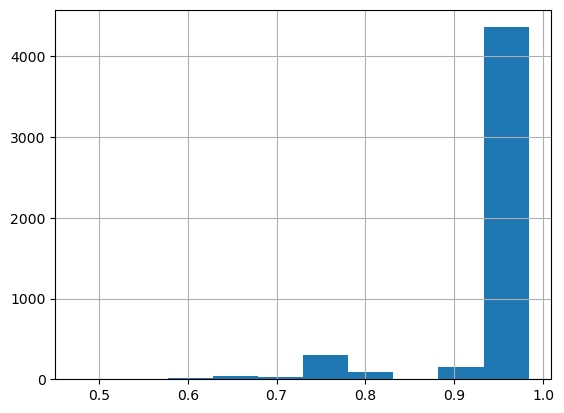

In [ ]:
df_test['pred_prob'].hist();

In [ ]:
df_test[df_test['pred_prob']<0.85][:500]

,transaction_id,sentence,sentence2,description_combined_processed,true_merchant_name_combined,merchant_name_combined,true_label,label,pred_merchant,pred_prob
4,9796686754,Wal-Mart Super WAL-SAMS SPRINGFIELD MO. Channe...,Wal-Mart Super WAL-SAMS SPRINGFIELD MO. Type: ...,Wal-Mart Super WAL-SAMS SPRINGFIELD MO,Walmart,Smith''s,0,0.310292,Wal Wal-martsuper,0.799137
11,9799290885,PURCHASE AUTHORIZED ON 05/14 WM SUPERC Wal-Mar...,PURCHASE AUTHORIZED ON 05/14 WM SUPERC Wal-Mar...,PURCHASE AUTHORIZED ON 05/14 WM SUPERC Wal-Mar...,Walmart,Synchrony,0,0.232759,Wal Wal-martsuper,0.775473
12,9798904474,Walmart.com Bentonville AR XX SIG PURCH 05/13 ...,Walmart.com Bentonville AR XX SIG PURCH 05/13 ...,Walmart.com Bentonville AR XX SIG PURCH 05/13 ...,Walmart,QuikTrip,0,0.075148,Wal Wal-martsuper,0.751793
17,9801927063,PURCHASE AUTHORIZED ON 05/11 WALMART.COM 800-9...,PURCHASE AUTHORIZED ON 05/11 WALMART.COM 800-9...,PURCHASE AUTHORIZED ON 05/11 WALMART.COM 800-9...,Walmart,Cash App,0,0.078535,Wal Wal-martsuper,0.735269
28,9799263021,05/13 22:02 WAL-MART # JONESBORO AR CKCD DEBIT...,05/13 22:02 WAL-MART # JONESBORO AR CKCD DEBIT...,05/13 22:02 WAL-MART # JONESBORO AR CKCD DEBIT,Walmart,Marathon Petroleum,0,0.257865,Wal Wal-martsuper,0.751371
...,...,...,...,...,...,...,...,...,...,...
4960,9807244423,PURCHASE AUTHORIZED ON 05/14 WM SUPERC Wal-Mar...,PURCHASE AUTHORIZED ON 05/14 WM SUPERC Wal-Mar...,PURCHASE AUTHORIZED ON 05/14 WM SUPERC Wal-Mar...,Walmart,Spinstersis,0,0.051089,Wal Wal-martsuper,0.772779
4965,9808452776,Walmart.com 05/14 #XXXXX REFUND Walmart.com Be...,Walmart.com 05/14 #XXXXX REFUND Walmart.com Be...,Walmart.com 05/14 #XXXXX REFUND Walmart.com Be...,Walmart,K Stop Convenience,0,0.018743,Wal Wal-martsuper,0.713919
4971,9798778036,Point of Sale Debit L341 TIME 04:30 PM DATE 05...,Point of Sale Debit L341 TIME 04:30 PM DATE 05...,Point of Sale Debit L341 TIME 04:30 PM DATE 05...,Walmart,Ross Stores,0,0.114881,Wal Wal-martsuper,0.766499
4981,9807593604,CHECKCARD WALMART STA ELENA LA LIBERTAD XXXXX ...,CHECKCARD WALMART STA ELENA LA LIBERTAD XXXXX ...,CHECKCARD WALMART STA ELENA LA LIBERTAD XXXXX ...,Walmart,Lyft,0,0.116438,Wal Wal-martsuper,0.751746


In [ ]:
df_test.shape

(5000, 10)

In [ ]:
df_test['sentence'][100:150]

100    Deposit Debit Ca Earnin CEEEE_B Palo Alto CA D...
101    Zelle payment from AMY HAYES for \"vanishing b...
102    EARNIN CHGFC_B PALO ALTO CA 05/14. Channel: No...
103    PURCHASE AUTHORIZED ON 05/13 MCDONALD''S F IRV...
104    Debit Card Credit EARNIN CCHGA_B PALO ALTO CA....
105    Zelle payment from SUSAN BRODBECK BACsggj269q0...
106    POS Payment McDonalds 154-XXX VA # . Channel: ...
107    ONLINE TRANSFER FROM HUDSON A WAY2SAVE SAVINGS...
108    EARNIN CDHJA_B PALO ALTO CA 05/14. Channel: No...
109    Earnin CEGJA_B Palo Alto CA. Channel: None. Am...
110    ONLINE TRANSFER FROM BENNETT T WAY2SAVE SAVING...
111    Zelle payment from ALEXIS GAUDET BACxe32r3prx....
112    PURCHASE AMZN Mktp US*SY1BN Amzn.com/billWA XX...
113    CASH APP*ERIC LOLA BAR. Channel: None. Amount:...
114    Zelle payment from SHAVONNE MORENO BACpwpbspl0...
115    McDonalds 05-12 BROOKSVILLE FL DEBIT CARD PURC...
116    CHECKCARD CASH APP*WE DESIG XXXXX CA XXXXX XXX...
117    AMZN Mktp US*WN8Q06S Amz

In [ ]:
model.encode(df_test['sentence'][istart:istart+batch_size].tolist())

array([[-0.00816036,  0.27537555,  0.14324246, ...,  0.0999889 ,
        -0.0035936 ,  0.07809736],
       [ 0.02443847, -0.07863627,  0.01445072, ...,  0.02271993,
         0.03442278,  0.02410999],
       [-0.01848849,  0.26305526,  0.12530893, ...,  0.09496655,
         0.00565742,  0.07274164],
       ...,
       [ 0.02032459, -0.06118753,  0.01493401, ..., -0.00625443,
         0.10024939,  0.12695931],
       [-0.01988285, -0.1525213 ,  0.0045229 , ..., -0.01461221,
         0.02463034,  0.0660398 ],
       [-0.01051987, -0.06855395,  0.00723861, ..., -0.00558885,
         0.0144608 ,  0.05602989]], dtype=float32)

In [ ]:
df_test.loc[istart:istart+batch_size-1,'pred_merchant'].shape

(100,)

In [ ]:
df_test.loc[0:100,'label'].shape

(101,)

In [ ]:
df_test[0:100].shape

(100, 10)

In [ ]:
istart+batch_size

100

In [ ]:

len(predicted_merchant)

100

In [ ]:
tx_embedding = model.encode(df_test['sentence'][0:2])

In [ ]:
tx_embedding.shape

(2, 768)

torch.Size([2, 85500])

torch.return_types.max(
values=tensor([0.9616, 0.9750]),
indices=tensor([117,  17]))

tensor([117,  17])

In [ ]:
df_test['merchant_name_combined']

0         Wells Fargo
1         McDonald''s
2            Cash App
3             Verizon
4            Smith''s
            ...      
4995    Chumba Casino
4996            Zelle
4997           Crenco
4998          Empower
4999            Zelle
Name: merchant_name_combined, Length: 5000, dtype: string

In [ ]:
matched_merchants = similarities.max(axis=1)
matched_merchants

NameError: name 'similarities' is not defined

In [ ]:
similarity_score = matched_merchants[0]
similarity_score

tensor([0.9629, 0.9737])

In [ ]:
matched_merchants

NameError: name 'matched_merchants' is not defined

Load model

In [ ]:
print(sentence_transformers.__version__)

3.0.0


In [ ]:
from sentence_transformers import SentenceTransformerModelCardData
from datasets import load_dataset


In [ ]:
# 1. Load a model to finetune with 2. (Optional) model card data
model = SentenceTransformer(
    "microsoft/mpnet-base",
    model_card_data=SentenceTransformerModelCardData(
        language="en",
        license="apache-2.0",
        model_name="MPNet base trained on AllNLI triplets",
    )
)

# 3. Load a dataset to finetune on
dataset = load_dataset("sentence-transformers/all-nli",'pair-score')

No sentence-transformers model found with name microsoft/mpnet-base. Creating a new one with mean pooling.
Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.bias', 'mpnet.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Generating train split:   0%|          | 0/942069 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/19657 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/19656 [00:00<?, ? examples/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'score'],
        num_rows: 942069
    })
    dev: Dataset({
        features: ['sentence1', 'sentence2', 'score'],
        num_rows: 19657
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'score'],
        num_rows: 19656
    })
})

In [ ]:
train_dataset = dataset['train']

In [ ]:
train_dataset[0]

{'sentence1': 'A person on a horse jumps over a broken down airplane.',
 'sentence2': 'A person is training his horse for a competition.',
 'score': 0.5}

In [ ]:
#train_dataloader = DataLoader(train_examples, shuffle=True, batch_size = 128)

In [ ]:
len(train_dataloader)

668

In [ ]:
#train_loss = losses.CosineSimilarityLoss(model)

In [ ]:
train_loss

NameError: name 'train_loss' is not defined

## Tune the model

In [ ]:
model.fit(train_objectives = [(train_dataloader, train_loss)], epochs = 1 , warmup_steps = 100)

Detected kernel version 4.14.343, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss
500,0.020500


In [ ]:
# save model

## Evaluation

In [ ]:
trx_descriptions = df_val['sentence'].tolist()
merchants = df_val['merchant_name_combined'].tolist()
trx_embeddings = model.encode(trx_descriptions)
merchants_embeddings = model.encode(merchants)

In [ ]:
print(trx_embeddings.shape)
print(merchants_embeddings.shape)

(9500, 768)
(9500, 768)


In [ ]:
import numpy as np

In [ ]:
## look into numba
cosine_similarity(trx_embeddings, merchants_embeddings).shape
df_val['cos_similarity']=np.diag(cosine_similarity(trx_embeddings, merchants_embeddings))

In [ ]:
df_val

,transaction_id,sentence,sentence2,description_combined_processed,true_merchant_name_combined,merchant_name_combined,true_label,label,cos_similarity
0,9798760350,Debit Purchase Wal-mart Super Cbrookings Sd 05...,Debit Purchase Wal-mart Super Cbrookings Sd 05...,Debit Purchase Wal-mart Super Cbrookings Sd 05...,Walmart,Exotic S Shop,0,0.328529,0.000262
1,9806775557,MONEY TRANSFER AUTHORIZED ON 05/13 CASH APP*JE...,MONEY TRANSFER AUTHORIZED ON 05/13 CASH APP*JE...,MONEY TRANSFER AUTHORIZED ON 05/13 CASH APP*JE...,Cash App,Acorns,0,0.265679,-0.010028
2,9798728894,MONEY TRANSFER AUTHORIZED ON 05/13 FROM Earnin...,MONEY TRANSFER AUTHORIZED ON 05/13 FROM Earnin...,MONEY TRANSFER AUTHORIZED ON 05/13 FROM Earnin...,Earnin,PayPal,0,0.207873,-0.003231
3,9799291124,MONEY TRANSFER AUTHORIZED ON 05/13 CASH APP*JE...,MONEY TRANSFER AUTHORIZED ON 05/13 CASH APP*JE...,MONEY TRANSFER AUTHORIZED ON 05/13 CASH APP*JE...,Cash App,Wells Fargo,0,0.008904,0.001403
4,9799976650,Instant Pmt from Earnin RDBFA_B on 05/14 Ref# ...,Instant Pmt from Earnin RDBFA_B on 05/14 Ref# ...,Instant Pmt from Earnin RDBFA_B on 05/14 Ref# ...,Earnin,Venmo,0,0.054398,-0.010100
...,...,...,...,...,...,...,...,...,...
9495,9799636891,PURCHASE RETURN AUTHORIZED ON 05/13 AMZN Mktp ...,PURCHASE RETURN AUTHORIZED ON 05/13 AMZN Mktp ...,PURCHASE RETURN AUTHORIZED ON 05/13 AMZN Mktp ...,Amazon,TGI Friday''s,0,0.102636,0.001885
9496,9799365097,"AMZN Mktp US GE69A,2YL3 Amzn com WA,05-13-24,C...","AMZN Mktp US GE69A,2YL3 Amzn com WA,05-13-24,C...","AMZN Mktp US GE69A,2YL3 Amzn com WA,05-13-24,C...",Amazon,Amazon,1,0.840733,0.995985
9497,9814848095,ONLINE TRANSFER FROM NAME N WELLS FARGO CLEAR ...,ONLINE TRANSFER FROM NAME N WELLS FARGO CLEAR ...,ONLINE TRANSFER FROM NAME N WELLS FARGO CLEAR ...,Wells Fargo,Wells Fargo,1,0.888943,0.988127
9498,9799827250,MCDONALD''S F ROCKY RIVER OH 05/13. Channel: i...,MCDONALD''S F ROCKY RIVER OH 05/13. Type: merc...,MCDONALD''S F ROCKY RIVER OH 05/13,McDonald''s,Coca-Cola,0,0.085374,-0.001350


In [ ]:
while True:
    pass

KeyboardInterrupt: 

In [ ]:
validate_data[['label', 'true_label','cos_similarity']]

In [ ]:
# reducer = umap.UMAP(n_epochs=400,  n_neighbors=150, min_dist=0.1)
# reducer.fit(merchants_embeddings
# )
# embedding_2d = reducer.transform(merchants_embeddings)
# fig = px.scatter(embedding_2d, x=0, y=1,opacity=0.05, height=500, hover_name=names)
# fig.show()